In [3]:
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    AdaBoostClassifier, ExtraTreesClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix
)
from scipy.stats import mode
import joblib

warnings.filterwarnings("ignore")




In [4]:
import pandas as pd

# Load your datasets
check3 = pd.read_csv("check3.csv")
rurality = pd.read_csv("All_Subjects_RURALITY_07Mar2025.csv")

# Step 1: Identify one-hot encoded SITE columns
site_columns = [col for col in check3.columns if col.startswith("SITE_")]

# Step 2: Create SITE → RUCA mapping
site_ruca_map = rurality[["SITEID", "RUCA"]].dropna().drop_duplicates()
site_to_ruca = {f"SITE_{int(row.SITEID)}": int(row.RUCA) for _, row in site_ruca_map.iterrows()}

# Step 3: Replace SITE columns with RUCA columns
for site_col in site_columns:
    if site_col in site_to_ruca:
        ruca_val = site_to_ruca[site_col]
        ruca_col = f"RUCA_{ruca_val}"
        # Create RUCA column if it doesn't exist
        if ruca_col not in check3.columns:
            check3[ruca_col] = 0
        # OR the values (make sure all are integers)
        check3[ruca_col] = check3[ruca_col].astype(int) | check3[site_col].fillna(0).astype(int)

# Step 4: Drop old SITE columns
check3.drop(columns=site_columns, inplace=True)

# Step 5: Add a single RURALITY category label per row
def get_ruca_label(ruca):
    if ruca == 2:
        return "Urban"
    elif ruca == 1:
        return "Rural"
    else:
        return "Unknown"

# Extract RUCA value for each row
def extract_ruca_value(row):
    for col in row.index:
        if col.startswith("RUCA_") and row[col] == 1:
            return int(col.replace("RUCA_", ""))
    return None

check3["RUCA_VALUE"] = check3.apply(extract_ruca_value, axis=1)
check3["RURALITY_LABEL"] = check3["RUCA_VALUE"].apply(get_ruca_label)
check3["RURALITY_LABEL"] = check3["RURALITY_LABEL"].astype("category")

# Optional: Save
check3.to_csv("DATA.csv", index=False)




In [ ]:
import pandas as pd

df = pd.read_csv("DATA.csv")

dx_cols = [col for col in df.columns if col.startswith("DX_VISIT")]

dx_cols_sorted = sorted(dx_cols, key=lambda x: int(x.split("VISIT")[1]))

# Apply row-wise forward fill (LOCF) for DX columns
df[dx_cols_sorted] = df[dx_cols_sorted].apply(lambda row: row.ffill(axis=0), axis=1)

df.to_csv("DATA.csv", index=False)



In [7]:
# Load your datasets
check3 = pd.read_csv("check3.csv")
rurality = pd.read_csv("All_Subjects_RURALITY_07Mar2025.csv")

# Identify one-hot SITE columns
site_columns = [col for col in check3.columns if col.startswith("SITE_")]

# Create SITE to RUCA mapping
site_ruca_map = rurality[["SITEID", "RUCA"]].dropna().drop_duplicates()
site_to_ruca = {f"SITE_{int(row.SITEID)}": int(row.RUCA) for _, row in site_ruca_map.iterrows()}

# Replace SITE columns with RUCA columns
for site_col in site_columns:
    if site_col in site_to_ruca:
        ruca_val = site_to_ruca[site_col]
        ruca_col = f"RUCA_{ruca_val}"
        if ruca_col not in check3.columns:
            check3[ruca_col] = 0
        check3[ruca_col] = check3[ruca_col].astype(int) | check3[site_col].fillna(0).astype(int)

# Drop SITE columns
check3.drop(columns=site_columns, inplace=True)

# Extract the RUCA value from the one-hot columns
def extract_ruca_value(row):
    for col in row.index:
        if col.startswith("RUCA_") and row[col] == 1:
            return int(col.replace("RUCA_", ""))
    return None

check3["RUCA_VALUE"] = check3.apply(extract_ruca_value, axis=1)

# Add binary flags
check3["RUCA_URBAN"] = check3["RUCA_VALUE"].apply(lambda x: 1 if x == 2 else 0)
check3["RUCA_RURAL"] = check3["RUCA_VALUE"].apply(lambda x: 1 if x == 1 else 0)
check3["RUCA_UNKNOWN"] = check3["RUCA_VALUE"].apply(lambda x: 1 if pd.isna(x) or x not in [1,2] else 0)

check3.drop(columns=["RUCA_1", "RUCA_2", "RUCA_VALUE"], inplace=True)

# Optional: save to CSV
check3.to_csv("DATA.csv", index=False)


In [44]:

df = pd.read_csv("DATA.csv")

# === Define feature groups ===
biomarkers = ['APOE4', 'ABETA', 'TAU', 'PTAU']
cognitive = ['CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE']
demographics = [
    'PTGENDER_Male', 'PTETHCAT_Not Hisp/Latino', 'PTETHCAT_Unknown',
    'PTRACCAT_Asian', 'PTRACCAT_Black', 'PTRACCAT_Hawaiian/Other PI',
    'PTRACCAT_More than one', 'PTRACCAT_Unknown', 'PTRACCAT_White',
    'PTMARRY_Married', 'PTMARRY_Widowed', 'PTMARRY_Never married', 'PTMARRY_Unknown'
]
rurality = ['RUCA_URBAN', 'RUCA_RURAL', 'RUCA_UNKNOWN']
other = ['PTEDUCAT', 'AGE']

# === LOCF (Last Observation Carried Forward) ===
all_vars = biomarkers + cognitive
visit_cols = []
for var in all_vars:
    for v in range(1, 5):
        col = f"{var}_VISIT{v}"
        if col in df.columns:
            visit_cols.append(col)

var_groups = defaultdict(list)
for col in visit_cols:
    base = col.split("_VISIT")[0]
    var_groups[base].append(col)

for base, cols in var_groups.items():
    cols_sorted = sorted(cols, key=lambda x: int(x.split("VISIT")[1]))
    df[cols_sorted] = df[cols_sorted].apply(lambda row: row.ffill(axis=0), axis=1)

# === Build dataset across visits ===
all_visit_data = []
for visit in range(1, 5):
    visit_bio = [f"{v}_VISIT{visit}" for v in biomarkers if f"{v}_VISIT{visit}" in df.columns]
    visit_cog = [f"{v}_VISIT{visit}" for v in cognitive if f"{v}_VISIT{visit}" in df.columns]
    target = f"DX_VISIT{visit}"
    if target not in df.columns:
        continue

    predictors = demographics + rurality + visit_bio + visit_cog + other
    subset = df[predictors + [target]].copy()
    subset.dropna(subset=[target], inplace=True)
    subset['VISIT'] = visit
    subset.rename(columns={target: 'DX'}, inplace=True)
    all_visit_data.append(subset)


combined_df = pd.concat(all_visit_data, axis=0)


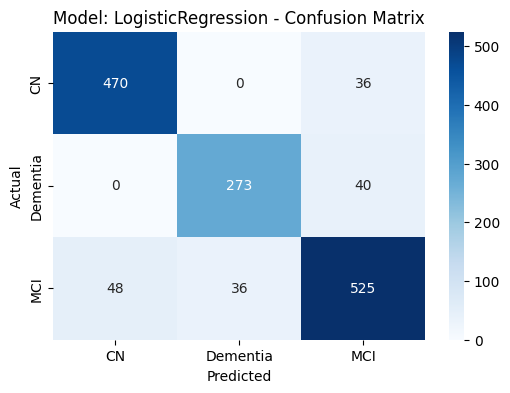

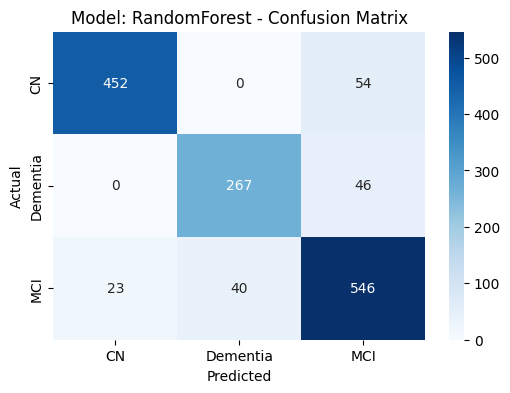

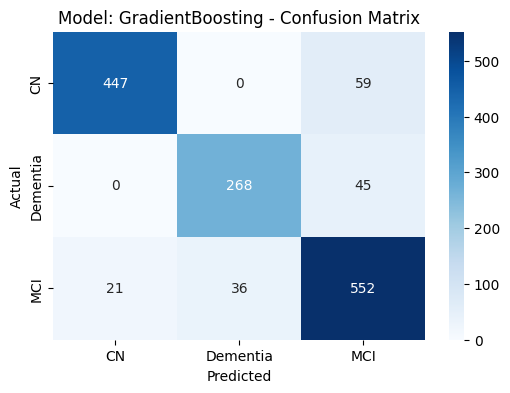

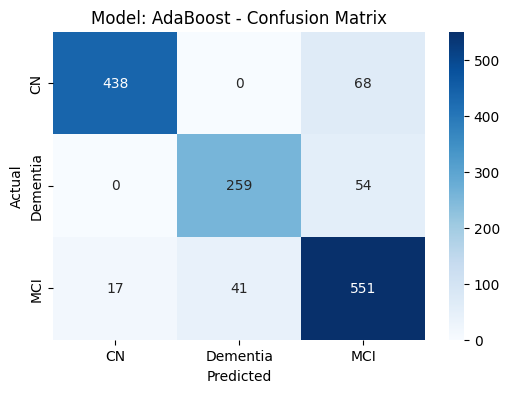

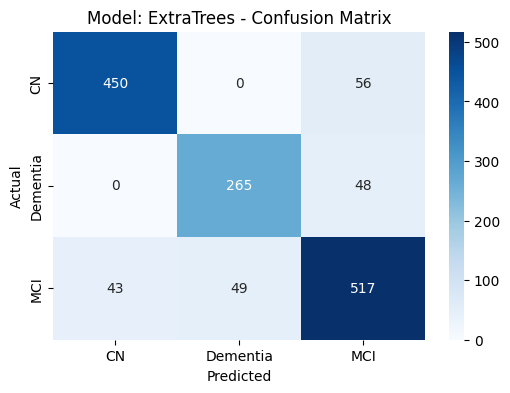

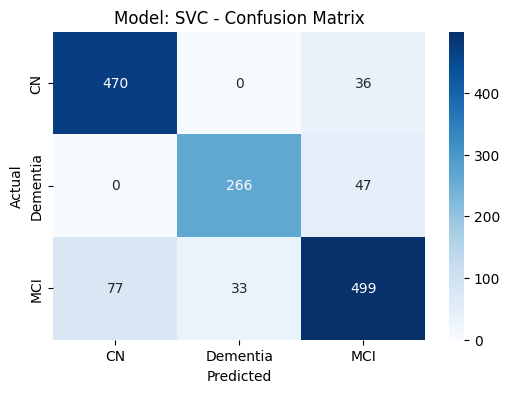

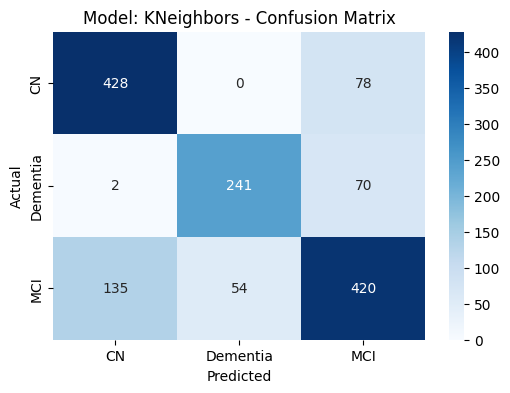

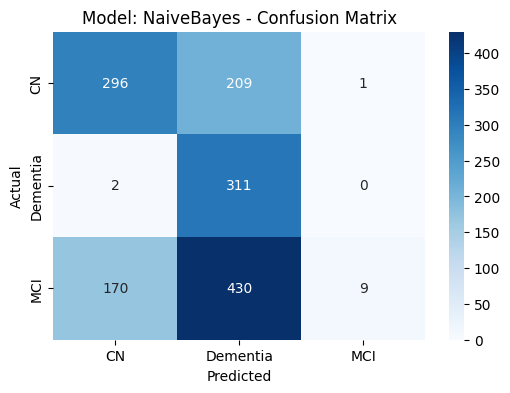

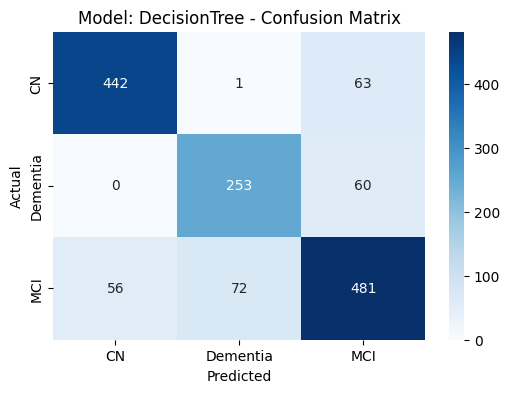

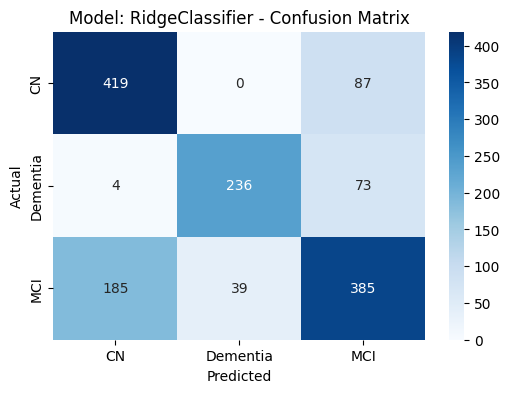

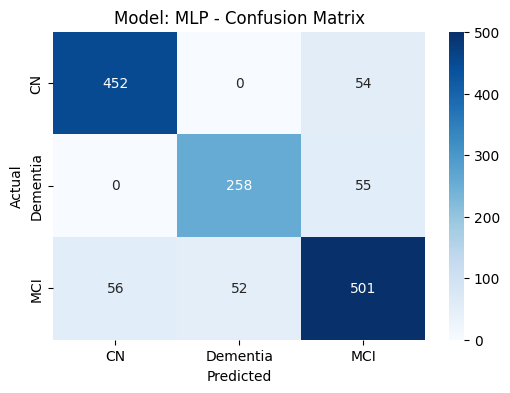

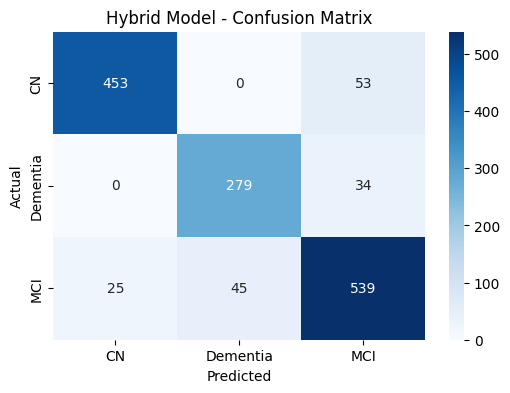


Aggregated Model Performance (Test Set & CV):

LogisticRegression:
  CV Mean Accuracy : 0.8872
  Test Accuracy     : 0.8880
  Precision         : 0.8881
  Recall            : 0.8877
  F1 Score          : 0.8879

RandomForest:
  CV Mean Accuracy : 0.8860
  Test Accuracy     : 0.8859
  Precision         : 0.8888
  Recall            : 0.8810
  F1 Score          : 0.8843

GradientBoosting:
  CV Mean Accuracy : 0.8912
  Test Accuracy     : 0.8873
  Precision         : 0.8927
  Recall            : 0.8820
  F1 Score          : 0.8864

AdaBoost:
  CV Mean Accuracy : 0.8462
  Test Accuracy     : 0.8739
  Precision         : 0.8816
  Recall            : 0.8660
  F1 Score          : 0.8721

ExtraTrees:
  CV Mean Accuracy : 0.8649
  Test Accuracy     : 0.8627
  Precision         : 0.8631
  Recall            : 0.8616
  F1 Score          : 0.8623

SVC:
  CV Mean Accuracy : 0.8606
  Test Accuracy     : 0.8648
  Precision         : 0.8688
  Recall            : 0.8660
  F1 Score          : 0.8666

KNe

In [45]:

# === Preprocessing pipeline: impute + scale ===
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

X_raw = combined_df.drop(columns=['DX'])
y_raw = combined_df['DX'].astype(str)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y_raw)
joblib.dump(le, "models/label_encoder_all_visits.pkl")

# Train-test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, stratify=y, test_size=0.2, random_state=42)

# Fit preprocessing pipeline on training data
pipeline.fit(X_train_raw)
joblib.dump(pipeline, "models/preprocessing_pipeline_all_visits.pkl")

# Transform both train and test data
X_train = pipeline.transform(X_train_raw)
X_test = pipeline.transform(X_test_raw)

# === Models ===
models = {
    "LogisticRegression": LogisticRegression(max_iter=5000),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "SVC": SVC(probability=True, random_state=42),
    "KNeighbors": KNeighborsClassifier(),
    "NaiveBayes": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RidgeClassifier": RidgeClassifier(),
    "MLP": MLPClassifier(random_state=42, max_iter=500)
}

os.makedirs("models", exist_ok=True)
model_results = {}

# === Train + Evaluate Models ===
for model_name, model in models.items():
    # Cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    
    # Train
    model.fit(X_train, y_train)
    joblib.dump(model, f"models/{model_name}_all_visits.pkl")
    
    # Predict on test set
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    model_results[model_name] = {
        "cv_scores": scores,
        "cv_mean": np.mean(scores),
        "accuracy": acc,
        "precision": report["macro avg"]["precision"],
        "recall": report["macro avg"]["recall"],
        "f1_score": report["macro avg"]["f1-score"],
        "confusion_matrix": cm,
        "labels": le.classes_
    }

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Model: {model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# === Hybrid Voting Model (RF, GB, NB) ===
rf_preds = models["RandomForest"].predict(X_test)
gb_preds = models["GradientBoosting"].predict(X_test)
nb_preds = models["NaiveBayes"].predict(X_test)

all_preds = np.vstack([rf_preds, gb_preds, nb_preds])
hybrid_preds = mode(all_preds, axis=0, keepdims=True).mode.ravel()

hybrid_acc = accuracy_score(y_test, hybrid_preds)
hybrid_report = classification_report(y_test, hybrid_preds, output_dict=True)
hybrid_cm = confusion_matrix(y_test, hybrid_preds)

model_results["HybridModel"] = {
    "accuracy": hybrid_acc,
    "precision": hybrid_report["macro avg"]["precision"],
    "recall": hybrid_report["macro avg"]["recall"],
    "f1_score": hybrid_report["macro avg"]["f1-score"],
    "confusion_matrix": hybrid_cm,
    "labels": le.classes_
}

joblib.dump(
    (models["RandomForest"], models["GradientBoosting"], models["NaiveBayes"]),
    "models/hybrid_models_all_visits.pkl"
)

plt.figure(figsize=(6, 4))
sns.heatmap(hybrid_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Hybrid Model - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# === Summary Printout ===
print("\nAggregated Model Performance (Test Set & CV):\n")
for model_name, metrics in model_results.items():
    print(f"{model_name}:")
    if "cv_mean" in metrics:
        print(f"  CV Mean Accuracy : {metrics['cv_mean']:.4f}")
    print(f"  Test Accuracy     : {metrics['accuracy']:.4f}")
    print(f"  Precision         : {metrics['precision']:.4f}")
    print(f"  Recall            : {metrics['recall']:.4f}")
    print(f"  F1 Score          : {metrics['f1_score']:.4f}\n")



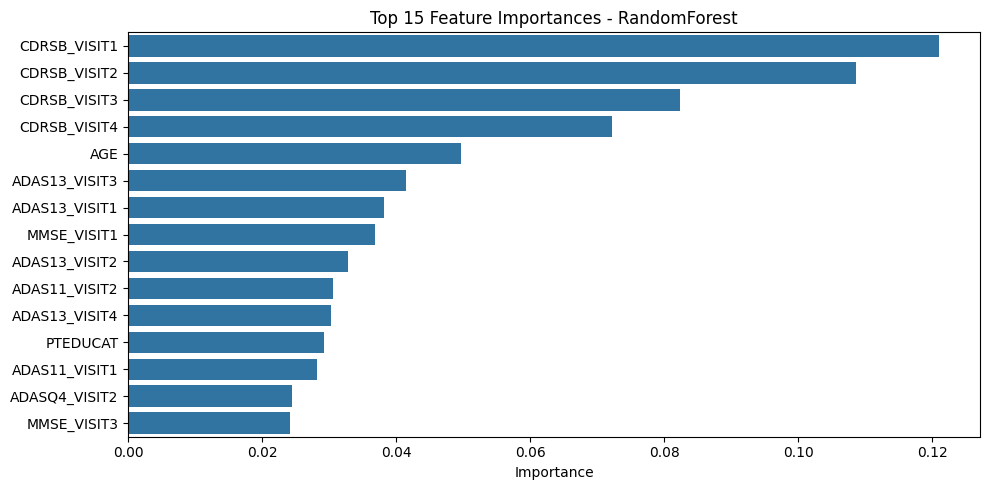

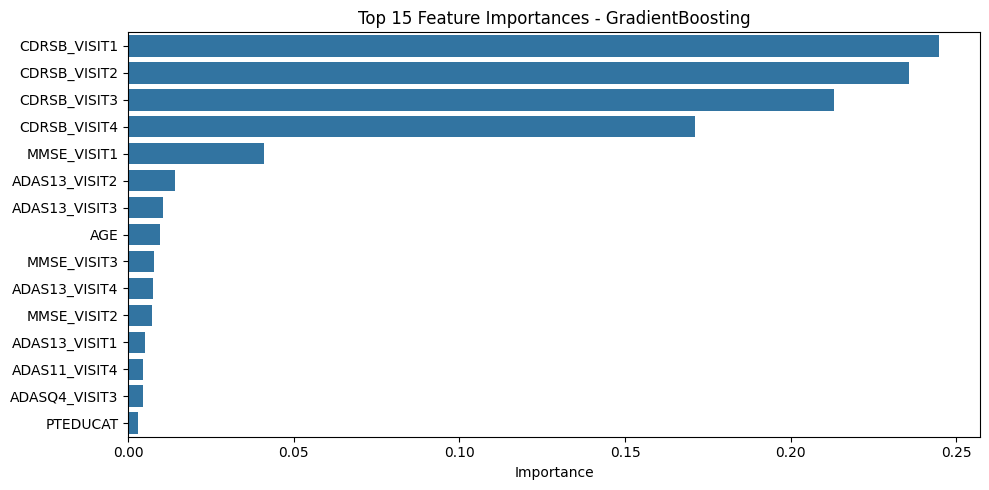

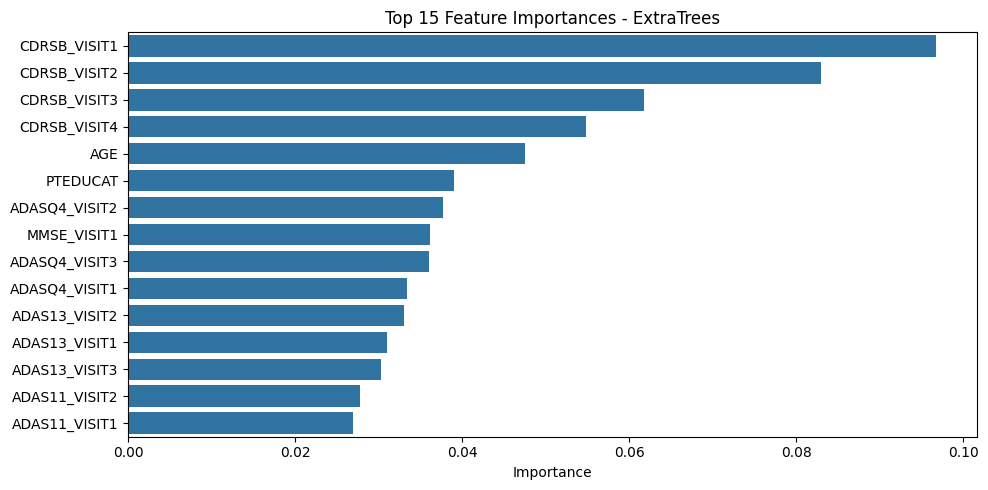

In [46]:
# === Feature Importance for tree-based models ===
tree_models = ["RandomForest", "GradientBoosting", "ExtraTrees"]

for model_name in tree_models:
    if model_name not in models:
        continue
    model = models[model_name]
    importances = model.feature_importances_
    feature_names = X_train_raw.columns
    indices = np.argsort(importances)[-15:][::-1]  # Top 15

    plt.figure(figsize=(10, 5))
    sns.barplot(x=importances[indices], y=np.array(feature_names)[indices])
    plt.title(f"Top 15 Feature Importances - {model_name}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()


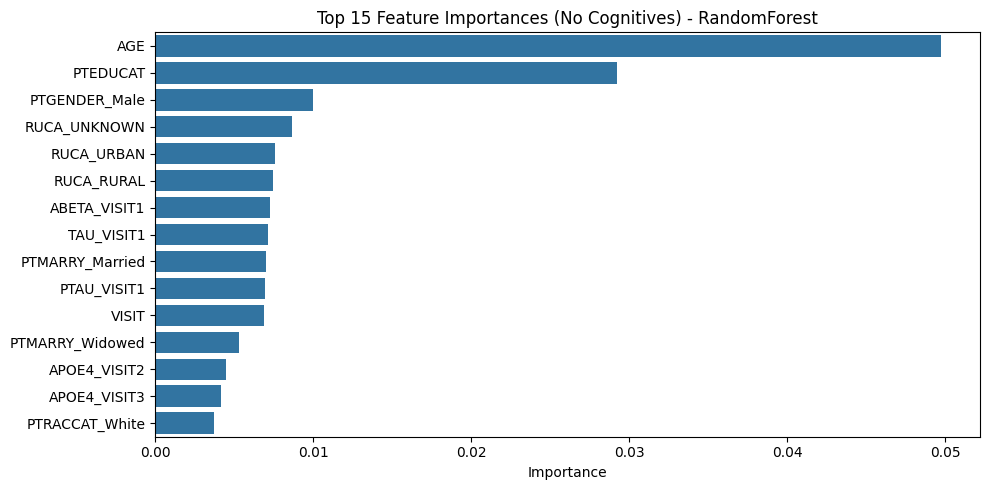

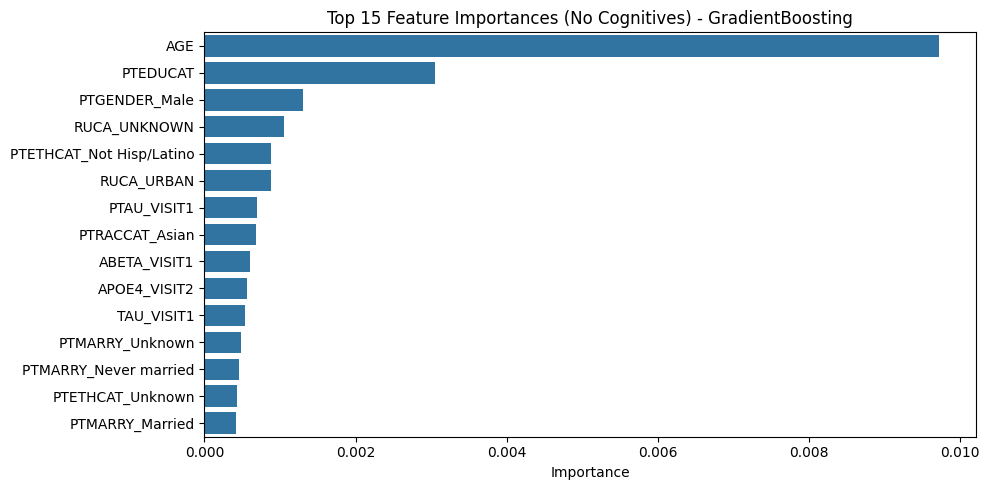

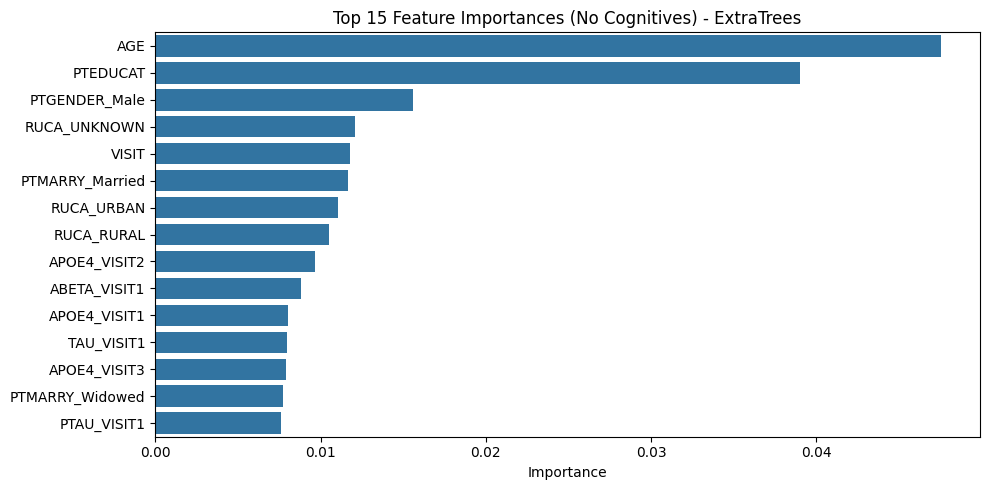

In [47]:
tree_models = ["RandomForest", "GradientBoosting", "ExtraTrees"]

for model_name in tree_models:
    model = models.get(model_name)
    if model is None:
        continue

    importances = model.feature_importances_
    feature_names = X_train_raw.columns

    # Exclude cognitive features
    filtered = [(name, imp) for name, imp in zip(feature_names, importances)
                if not any(cog in name for cog in cognitive)]

    # Sort and take top 15
    filtered_sorted = sorted(filtered, key=lambda x: x[1], reverse=True)[:15]
    names, values = zip(*filtered_sorted)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=values, y=names)
    plt.title(f"Top 15 Feature Importances (No Cognitives) - {model_name}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()


In [119]:
rf_model = models["RandomForest"]  # This is already trained
probs = rf_model.predict_proba(X_test)

import numpy as np
print("✅ Mean predicted probabilities per class (CN, MCI, AD):")
print(np.round(np.mean(probs, axis=0), 4))


✅ Mean predicted probabilities per class (CN, MCI, AD):
[0.3488 0.2189 0.4323]


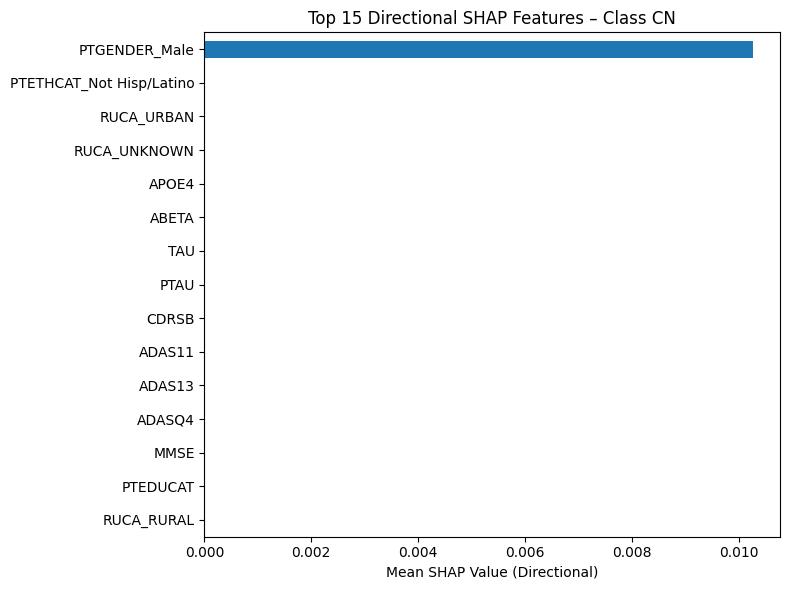

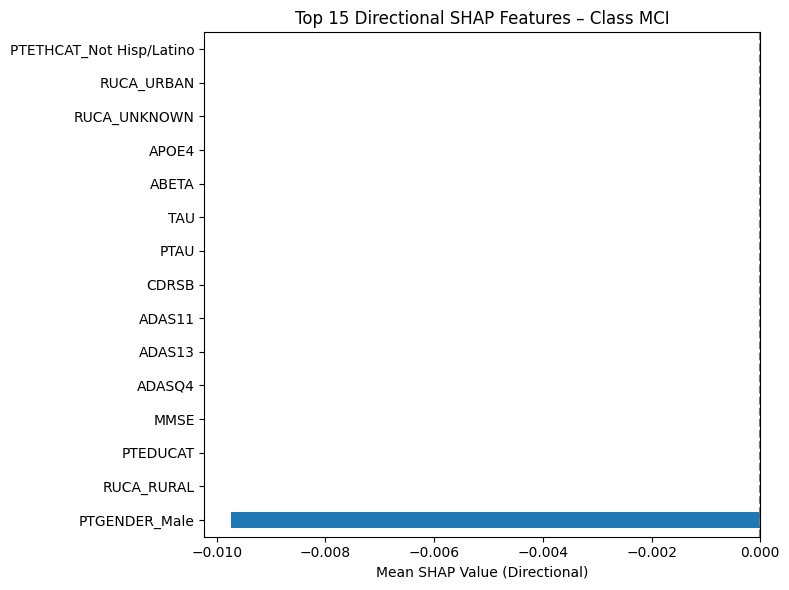

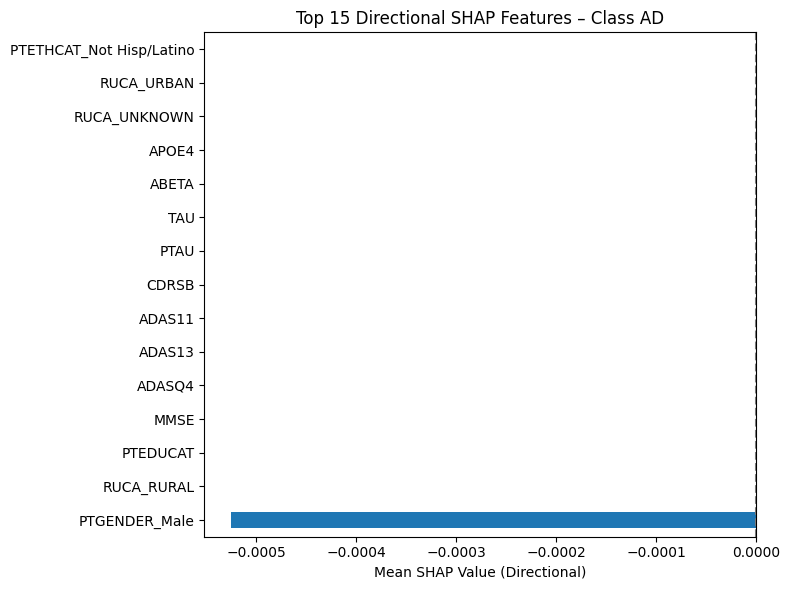

In [121]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Step 1: Compute directional mean SHAP values per class
mean_shap_directional = {}

for i, class_name in enumerate(class_labels):  # e.g., ['CN', 'MCI', 'AD']
    shap_array = shap_vals[:, :, i]
    
    # Fix: convert Explanation object to NumPy array if needed
    if hasattr(shap_array, 'values'):
        shap_array = shap_array.values

    shap_mean = shap_array.mean(axis=0)  # average over samples
    mean_shap_directional[class_name] = pd.Series(shap_mean, index=feature_cols)

# Step 2: Plot top 15 directional SHAP features per class
for class_name, shap_series in mean_shap_directional.items():
    top_features = shap_series.abs().sort_values(ascending=False).head(15).index
    shap_series_top = shap_series[top_features].sort_values()

    plt.figure(figsize=(8, 6))
    shap_series_top.plot(kind='barh')
    plt.title(f"Top 15 Directional SHAP Features – Class {class_name}")
    plt.xlabel("Mean SHAP Value (Directional)")
    plt.axvline(0, color='gray', linestyle='--')
    plt.tight_layout()
    plt.show()


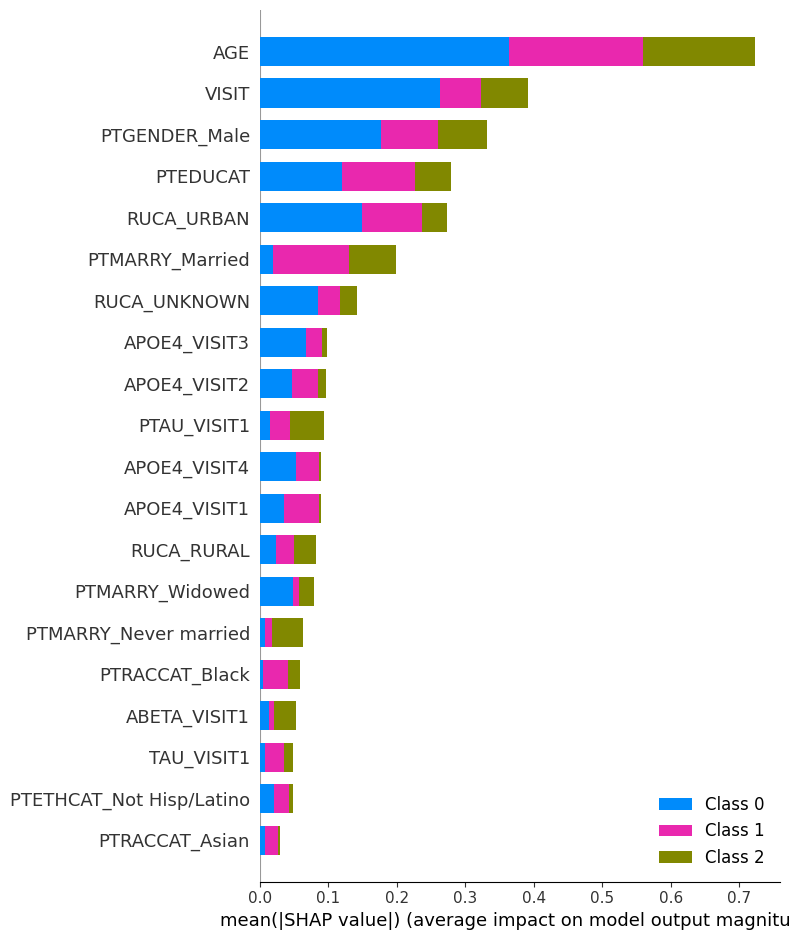

In [48]:
import xgboost as xgb
import shap

# Train model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

# SHAP explainer (works for multiclass!)
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

# Exclude cognitive columns
non_cognitive_idx = [i for i, name in enumerate(X_test_raw.columns) if not any(cog in name for cog in cognitive)]

# Summary plot without cognitive variables
shap.summary_plot(shap_values[:, non_cognitive_idx], X_test_raw.iloc[:, non_cognitive_idx])


Class 0


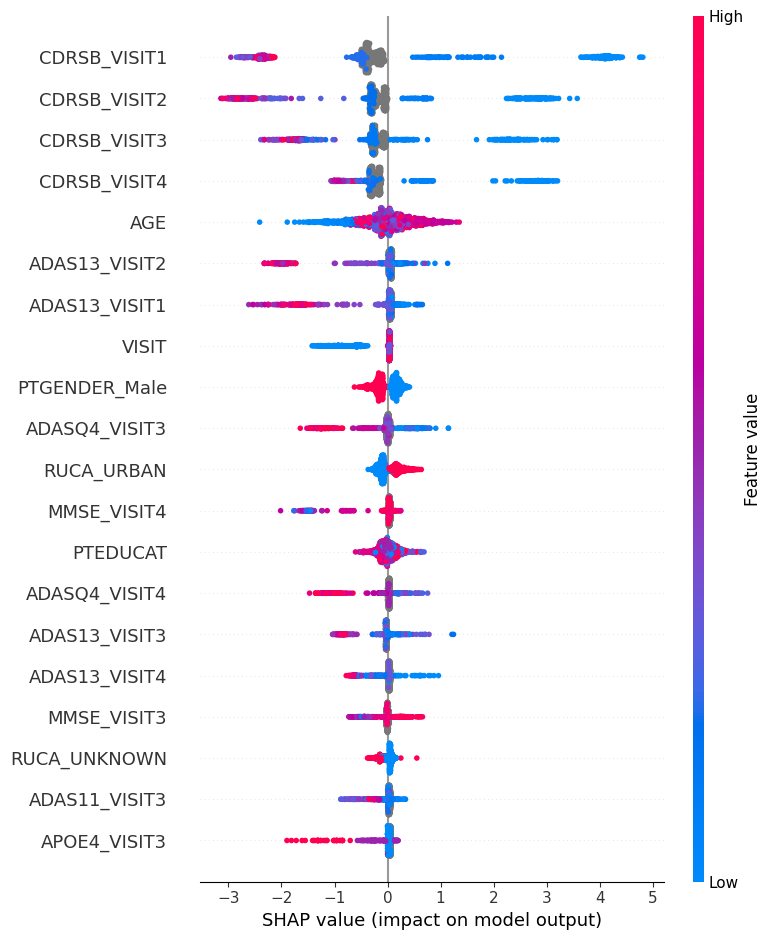

Class 1


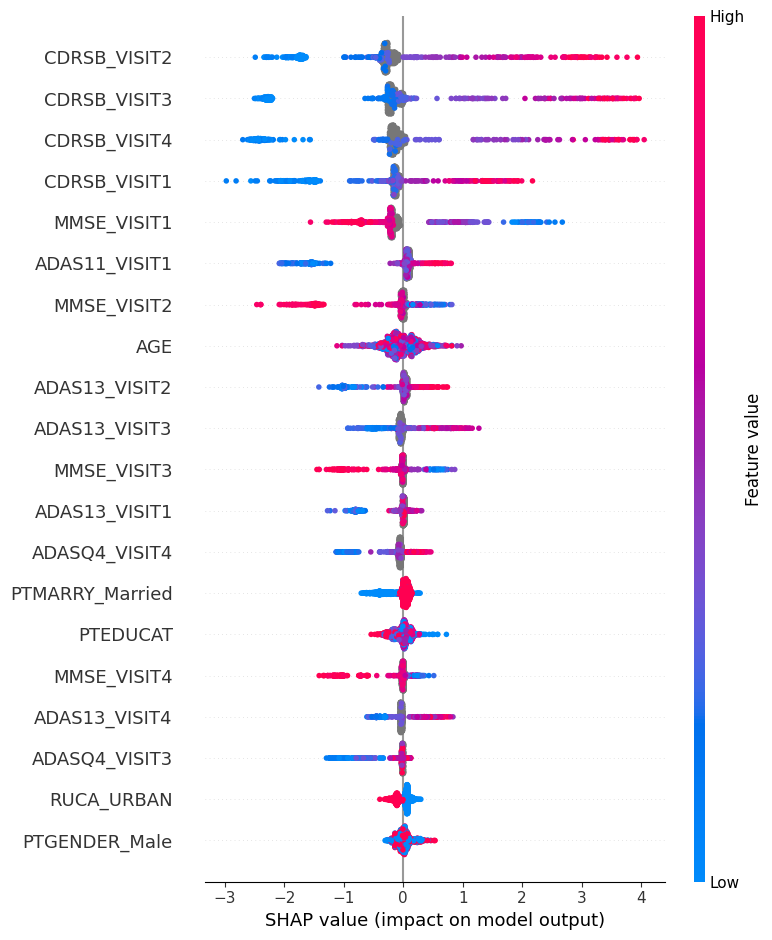

Class 2


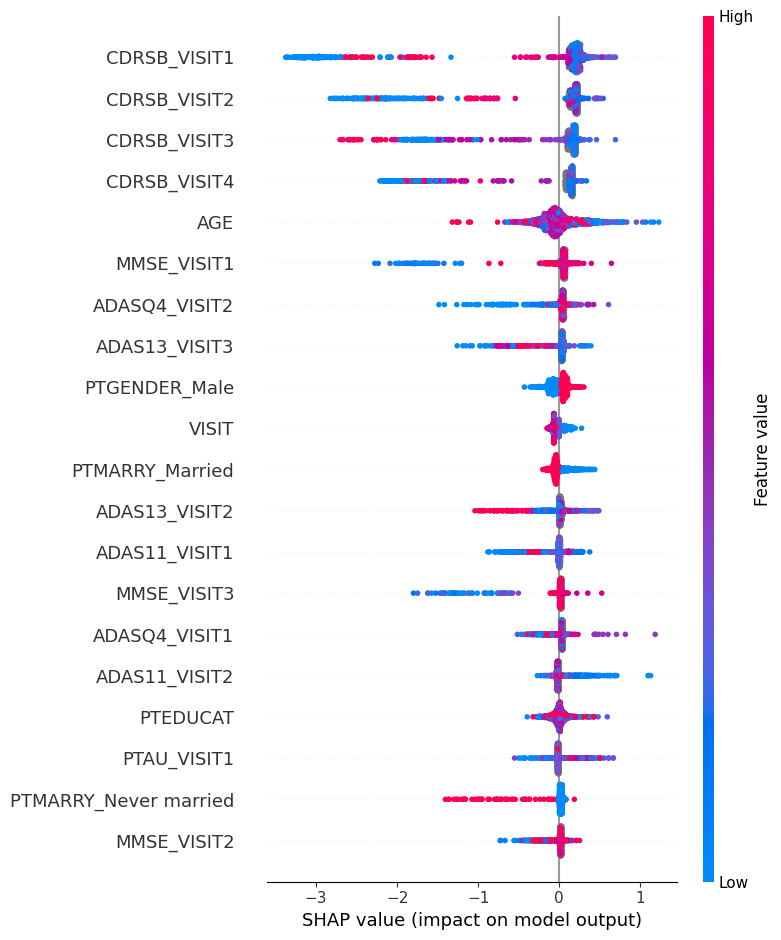

In [49]:
for i in range(shap_values.shape[2]):
    print(f"Class {i}")
    shap.summary_plot(shap_values[:, :, i], X_test_raw, plot_type="dot")


In [129]:
import shap
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Load model and label encoder ===
rf_model = joblib.load("RandomForest_all_visits.pkl")
label_encoder = joblib.load("label_encoder_all_visits.pkl")

# === Load test data ===
X_test_raw = pd.read_csv("check.csv")  # Replace with your actual file

# === Drop non-numeric columns (like IDs) ===
X_test_numeric = X_test_raw.select_dtypes(include=[np.number])
feature_names = X_test_numeric.columns.tolist()

# === SHAP computation using Random Forest ===
explainer = shap.TreeExplainer(rf_model, model_output="raw")
shap_vals = explainer.shap_values(X_test_numeric)



In [134]:
# If accidentally passing a row:
X_test_numeric = X_test_numeric if len(X_test_numeric.shape) == 2 else X_test_numeric.reshape(1, -1)
# === SHAP computation using Random Forest ===
explainer = shap.TreeExplainer(rf_model, model_output="raw")
shap_vals = explainer.shap_values(X_test_numeric)


In [165]:
# SHAP analysis script for Gradient Boosting classifier with and without cognitive variables
# Run locally in Python environment with SHAP and scikit-learn installed

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split

# === Configuration ===
CATEGORICAL_SUBGROUPS = [
    'PTGENDER_Male', 'RUCA_URBAN', 'RUCA_RURAL', 'RUCA_UNKNOWN',
    'PTRACCAT_Asian', 'PTRACCAT_Black', 'PTRACCAT_White',
    'PTMARRY_Married'
]
EDUCATION_BIN = [0, 12, 16, 25]
EDUCATION_LABEL = ['Low (≤12)', 'Mid (13–16)', 'High (17+)']
AGE_BIN = [0, 65, 75, 120]
AGE_LABEL = ['<65', '65–75', '75+']
DIAGNOSIS_COL = 'DX_VISIT1'
EXCLUDE_KEYWORDS = ['CDRSB', 'ADAS', 'MMSE']

# === Load Data ===
df = pd.read_csv("DATA.csv")
df['EDU_GROUP'] = pd.cut(df['PTEDUCAT'], bins=EDUCATION_BIN, labels=EDUCATION_LABEL)
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=AGE_BIN, labels=AGE_LABEL)

# Identify feature sets
all_features = [col for col in df.columns if df[col].dtype in [np.float64, np.int64] and not col.startswith("Unnamed")]
cognitive_cols = [col for col in all_features if any(key in col for key in EXCLUDE_KEYWORDS)]
non_cognitive_cols = [col for col in all_features if col not in cognitive_cols]


# Directory for plots
os.makedirs("shap_outputs", exist_ok=True)

# === Plotting Function ===
def plot_shap_bar(values, features, group_label, title_prefix):
    shap_df = pd.DataFrame(values, columns=features)
    shap_mean = shap_df.mean().sort_values()
    shap_df_mean = shap_mean[abs(shap_mean) > 0].sort_values(key=abs, ascending=False).head(10)

    ax = shap_df_mean.plot(kind='barh', figsize=(10, 6))
    plt.axvline(0, color='gray', linestyle='--')
    plt.title(f"{title_prefix}: {group_label}")
    plt.xlabel("Mean SHAP Value (directional)")
    plt.tight_layout()
    fname = f"shap_outputs/{title_prefix}_{group_label}.png".replace(" ", "_").replace("\u2264", "le")
    plt.savefig(fname)
    plt.clf()

# === Function to run SHAP pipeline ===
def run_shap_pipeline(feature_set, feature_label):
    columns = feature_set + [DIAGNOSIS_COL, 'EDU_GROUP', 'AGE_GROUP'] + CATEGORICAL_SUBGROUPS
    df_model = df[columns].dropna()

    X = df_model[feature_set]
    y = df_model[DIAGNOSIS_COL]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

    model = HistGradientBoostingClassifier(random_state=42)
    model.fit(X_train, y_train)

    explainer = shap.Explainer(model.predict_proba, X_train)
    shap_values = explainer(X_test)

    # Diagnosis-based SHAP
    for diagnosis in y_test.unique():
        idx = y_test == diagnosis
        if idx.sum() < 30:
                print(f"⏭️ Skipping subgroup {var}={val} due to small size (n={idx.sum()})")
                continue
        plot_shap_bar(
            shap_values.values[idx, :, y_test.unique().tolist().index(diagnosis)],
            X_test.columns,
            group_label=f"{diagnosis}_{feature_label}",
            title_prefix=f"Diagnosis_{feature_label}"
        )

    # Subgroup-based SHAP
    for var in CATEGORICAL_SUBGROUPS + ['EDU_GROUP', 'AGE_GROUP']:
        if var not in df_model.columns:
            continue
        series = df_model[var]
        if isinstance(series, pd.DataFrame):
            print(f"⚠️ {var} is a DataFrame with shape {series.shape}. Using only the first column.")
            series = series.iloc[:, 0]
        else:
            print(f"✅ {var} is a Series with dtype {series.dtype}")
        unique_vals = series.dropna().unique().tolist()
        print(f"🔍 Subgroup {var} has values: {unique_vals}")
        for val in unique_vals:
            idx = (df_model.loc[X_test.index, var] == val).values
            if idx.sum() < 30:
                continue
            label = f"{var}={val}_{feature_label}"
            shap_mean = shap_values.values[idx].mean(axis=0)
            plot_shap_bar(
                shap_mean,
                X_test.columns,
                group_label=label,
                title_prefix=f"Subgroup_{feature_label}"
            )
print(f"🔎 DEBUG: Type of idx = {type(idx)}")
print(f"        idx content (first 5): {idx[:5] if hasattr(idx, '__getitem__') else idx}")

print("SHAP shape:", shap_values.values.shape)
print("X_test shape:", X_test.shape)



🔎 DEBUG: Type of idx = <class 'int'>
        idx content (first 5): 2
SHAP shape: (1428, 27, 3)
X_test shape: (1428, 27)


In [167]:
# SHAP analysis script for Gradient Boosting classifier with and without cognitive variables
# Run locally in Python environment with SHAP and scikit-learn installed

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split

# === Configuration ===
CATEGORICAL_SUBGROUPS = [
    'PTGENDER_Male', 'RUCA_URBAN', 'RUCA_RURAL', 'RUCA_UNKNOWN',
    'PTRACCAT_Asian', 'PTRACCAT_Black', 'PTRACCAT_White',
    'PTMARRY_Married'
]
EDUCATION_BIN = [0, 12, 16, 25]
EDUCATION_LABEL = ['Low (≤12)', 'Mid (13–16)', 'High (17+)']
AGE_BIN = [0, 65, 75, 120]
AGE_LABEL = ['<65', '65–75', '75+']
DIAGNOSIS_COL = 'DX_VISIT1'
EXCLUDE_KEYWORDS = ['CDRSB', 'ADAS', 'MMSE']

# === Load Data ===
df = pd.read_csv("DATA.csv")
df['EDU_GROUP'] = pd.cut(df['PTEDUCAT'], bins=EDUCATION_BIN, labels=EDUCATION_LABEL)
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=AGE_BIN, labels=AGE_LABEL)

# Identify feature sets
all_features = [col for col in df.columns if df[col].dtype in [np.float64, np.int64] and not col.startswith("Unnamed")]
cognitive_cols = [col for col in all_features if any(key in col for key in EXCLUDE_KEYWORDS)]
non_cognitive_cols = [col for col in all_features if col not in cognitive_cols]

# Directory for plots
os.makedirs("shap_outputs", exist_ok=True)

# === Plotting Function ===
def plot_shap_bar(values, features, group_label, title_prefix):
    shap_df = pd.DataFrame(values, columns=features)
    shap_mean = shap_df.mean().sort_values()
    shap_df_mean = shap_mean[abs(shap_mean) > 0].sort_values(key=abs, ascending=False).head(10)

    ax = shap_df_mean.plot(kind='barh', figsize=(10, 6))
    plt.axvline(0, color='gray', linestyle='--')
    plt.title(f"{title_prefix}: {group_label}")
    plt.xlabel("Mean SHAP Value (directional)")
    plt.tight_layout()
    fname = f"shap_outputs/{title_prefix}_{group_label}.png".replace(" ", "_").replace("\u2264", "le")
    plt.savefig(fname)
    plt.clf()

# === Function to run SHAP pipeline ===
def run_shap_pipeline(feature_set, feature_label):
    columns = feature_set + [DIAGNOSIS_COL, 'EDU_GROUP', 'AGE_GROUP'] + CATEGORICAL_SUBGROUPS
    df_model = df[columns].dropna()

    X = df_model[feature_set]
    y = df_model[DIAGNOSIS_COL]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

    model = HistGradientBoostingClassifier(random_state=42)
    model.fit(X_train, y_train)

    explainer = shap.Explainer(model.predict_proba, X_train)
    shap_values = explainer(X_test)

    # Diagnosis-based SHAP
    for diagnosis in y_test.unique():
        idx = y_test == diagnosis
        if idx.sum() < 30:
                print(f"⏭️ Skipping subgroup {var}={val} due to small size (n={idx.sum()})")
                continue
        plot_shap_bar(
            shap_values.values[idx, :, y_test.unique().tolist().index(diagnosis)],
            X_test.columns,
            group_label=f"{diagnosis}_{feature_label}",
            title_prefix=f"Diagnosis_{feature_label}"
        )

    # Subgroup-based SHAP
    for var in CATEGORICAL_SUBGROUPS + ['EDU_GROUP', 'AGE_GROUP']:
        if var not in df_model.columns:
            continue
        series = df_model[var]
        if isinstance(series, pd.DataFrame):
            print(f"⚠️ {var} is a DataFrame with shape {series.shape}. Using only the first column.")
            series = series.iloc[:, 0]
        else:
            print(f"✅ {var} is a Series with dtype {series.dtype}")
        unique_vals = series.dropna().unique().tolist()
        print(f"🔍 Subgroup {var} has values: {unique_vals}")
        for val in unique_vals:
            if var in df_model.columns and var in X_test.columns:
                subgroup_values = X_test[var]
            else:
                subgroup_values = X_test.merge(df_model[[var]], left_index=True, right_index=True, how='left')[var]
            idx = (subgroup_values == val)
            if isinstance(idx, pd.Series):
                idx = idx.values
            print(f"🔎 DEBUG idx type: {type(idx)}, shape: {idx.shape}, true count: {np.sum(idx)}")
            if idx.sum() < 30:
                continue
            label = f"{var}={val}_{feature_label}"
            shap_mean = shap_values.values[idx].mean(axis=0)
            plot_shap_bar(
                shap_mean,
                X_test.columns,
                group_label=label,
                title_prefix=f"Subgroup_{feature_label}"
            )

# === Run SHAP for non-cognitive and full feature set ===
run_shap_pipeline(non_cognitive_cols, "NonCognitive")
run_shap_pipeline(all_features, "WithCognitive")

print("SHAP analysis completed. Plots saved in ./shap_outputs")


PermutationExplainer explainer: 295it [05:15,  1.11s/it]                         


⚠️ PTGENDER_Male is a DataFrame with shape (980, 2). Using only the first column.
🔍 Subgroup PTGENDER_Male has values: [1.0, 0.0]
🔎 DEBUG idx type: <class 'pandas.core.frame.DataFrame'>, shape: (294, 2), true count: PTGENDER_Male    157
PTGENDER_Male    157
dtype: int64


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

<Figure size 1000x600 with 0 Axes>

In [151]:
# SHAP analysis script for Gradient Boosting classifier with and without cognitive variables
# Run locally in Python environment with SHAP and scikit-learn installed

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split

# === Configuration ===
CATEGORICAL_SUBGROUPS = [
    'PTGENDER_Male', 'RUCA_URBAN', 'RUCA_RURAL', 'RUCA_UNKNOWN',
    'PTRACCAT_Asian', 'PTRACCAT_Black', 'PTRACCAT_White',
    'PTMARRY_Married'
]
EDUCATION_BIN = [0, 12, 16, 25]
EDUCATION_LABEL = ['Low (≤12)', 'Mid (13–16)', 'High (17+)']
AGE_BIN = [0, 65, 75, 120]
AGE_LABEL = ['<65', '65–75', '75+']
DIAGNOSIS_COL = 'DX_VISIT1'
EXCLUDE_KEYWORDS = ['CDRSB', 'ADAS', 'MMSE']

# === Load Data ===
df = pd.read_csv("DATA.csv")
df['EDU_GROUP'] = pd.cut(df['PTEDUCAT'], bins=EDUCATION_BIN, labels=EDUCATION_LABEL)
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=AGE_BIN, labels=AGE_LABEL)

# Identify feature sets
all_features = [col for col in df.columns if df[col].dtype in [np.float64, np.int64] and not col.startswith("Unnamed")]
cognitive_cols = [col for col in all_features if any(key in col for key in EXCLUDE_KEYWORDS)]
non_cognitive_cols = [col for col in all_features if col not in cognitive_cols]

# Directory for plots
os.makedirs("shap_outputs", exist_ok=True)

# === Plotting Function ===
def plot_shap_bar(values, features, group_label, title_prefix):
    shap_df = pd.DataFrame(values, columns=features)
    shap_mean = shap_df.mean().sort_values()
    shap_df_mean = shap_mean[abs(shap_mean) > 0].sort_values(key=abs, ascending=False).head(10)

    ax = shap_df_mean.plot(kind='barh', figsize=(10, 6))
    plt.axvline(0, color='gray', linestyle='--')
    plt.title(f"{title_prefix}: {group_label}")
    plt.xlabel("Mean SHAP Value (directional)")
    plt.tight_layout()
    fname = f"shap_outputs/{title_prefix}_{group_label}.png".replace(" ", "_").replace("\u2264", "le")
    plt.savefig(fname)
    plt.clf()

# === Function to run SHAP pipeline ===
def run_shap_pipeline(feature_set, feature_label):
    columns = feature_set + [DIAGNOSIS_COL, 'EDU_GROUP', 'AGE_GROUP'] + CATEGORICAL_SUBGROUPS
    df_model = df[columns].dropna()

    X = df_model[feature_set]
    y = df_model[DIAGNOSIS_COL]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

    model = HistGradientBoostingClassifier(random_state=42)
    model.fit(X_train, y_train)

    explainer = shap.Explainer(model.predict_proba, X_train)
    shap_values = explainer(X_test)

    # Diagnosis-based SHAP
    for diagnosis in y_test.unique():
        idx = y_test == diagnosis
        if idx.sum() < 30:
            continue
        plot_shap_bar(
            shap_values.values[idx, :, y_test.unique().tolist().index(diagnosis)],
            X_test.columns,
            group_label=f"{diagnosis}_{feature_label}",
            title_prefix=f"Diagnosis_{feature_label}"
        )

    # Subgroup-based SHAP
    for var in CATEGORICAL_SUBGROUPS + ['EDU_GROUP', 'AGE_GROUP']:
        if var not in df_model.columns:
            continue
        unique_vals = df_model[var].dropna().unique().tolist()
        for val in unique_vals:
            idx = df_model.loc[X_test.index, var] == val
            if idx.sum() < 30:
                continue
            label = f"{var}={val}_{feature_label}"
            shap_mean = shap_values.values[idx].mean(axis=2)
            plot_shap_bar(
                shap_mean,
                X_test.columns,
                group_label=label,
                title_prefix=f"Subgroup_{feature_label}"
            )




In [155]:
# SHAP analysis script for Gradient Boosting classifier with and without cognitive variables
# Run locally in Python environment with SHAP and scikit-learn installed

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split

# === Configuration ===
CATEGORICAL_SUBGROUPS = [
    'PTGENDER_Male', 'RUCA_URBAN', 'RUCA_RURAL', 'RUCA_UNKNOWN',
    'PTRACCAT_Asian', 'PTRACCAT_Black', 'PTRACCAT_White',
    'PTMARRY_Married'
]
EDUCATION_BIN = [0, 12, 16, 25]
EDUCATION_LABEL = ['Low (≤12)', 'Mid (13–16)', 'High (17+)']
AGE_BIN = [0, 65, 75, 120]
AGE_LABEL = ['<65', '65–75', '75+']
DIAGNOSIS_COL = 'DX_VISIT1'
EXCLUDE_KEYWORDS = ['CDRSB', 'ADAS', 'MMSE']

# === Load Data ===
df = pd.read_csv("DATA.csv")
df['EDU_GROUP'] = pd.cut(df['PTEDUCAT'], bins=EDUCATION_BIN, labels=EDUCATION_LABEL)
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=AGE_BIN, labels=AGE_LABEL)

# Identify feature sets
all_features = [col for col in df.columns if df[col].dtype in [np.float64, np.int64] and not col.startswith("Unnamed")]
cognitive_cols = [col for col in all_features if any(key in col for key in EXCLUDE_KEYWORDS)]
non_cognitive_cols = [col for col in all_features if col not in cognitive_cols]

# Directory for plots
os.makedirs("shap_outputs", exist_ok=True)

# === Plotting Function ===
def plot_shap_bar(values, features, group_label, title_prefix):
    shap_df = pd.DataFrame(values, columns=features)
    shap_mean = shap_df.mean().sort_values()
    shap_df_mean = shap_mean[abs(shap_mean) > 0].sort_values(key=abs, ascending=False).head(10)

    ax = shap_df_mean.plot(kind='barh', figsize=(10, 6))
    plt.axvline(0, color='gray', linestyle='--')
    plt.title(f"{title_prefix}: {group_label}")
    plt.xlabel("Mean SHAP Value (directional)")
    plt.tight_layout()
    fname = f"shap_outputs/{title_prefix}_{group_label}.png".replace(" ", "_").replace("\u2264", "le")
    plt.savefig(fname)
    plt.clf()

# === Function to run SHAP pipeline ===
def run_shap_pipeline(feature_set, feature_label):
    columns = feature_set + [DIAGNOSIS_COL, 'EDU_GROUP', 'AGE_GROUP'] + CATEGORICAL_SUBGROUPS
    df_model = df[columns].dropna()

    X = df_model[feature_set]
    y = df_model[DIAGNOSIS_COL]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

    model = HistGradientBoostingClassifier(random_state=42)
    model.fit(X_train, y_train)

    explainer = shap.Explainer(model.predict_proba, X_train)
    shap_values = explainer(X_test)

    # Diagnosis-based SHAP
    for diagnosis in y_test.unique():
        idx = y_test == diagnosis
        if idx.sum() < 30:
            continue
        plot_shap_bar(
            shap_values.values[idx, :, y_test.unique().tolist().index(diagnosis)],
            X_test.columns,
            group_label=f"{diagnosis}_{feature_label}",
            title_prefix=f"Diagnosis_{feature_label}"
        )

    # Subgroup-based SHAP
    for var in CATEGORICAL_SUBGROUPS + ['EDU_GROUP', 'AGE_GROUP']:
        if var not in df_model.columns:
            continue
        unique_vals = df_model[var].dropna().unique().tolist()
        for val in unique_vals:
            idx = df_model.loc[X_test.index, var] == val
            if idx.sum() < 30:
                continue
            label = f"{var}={val}_{feature_label}"
            shap_mean = shap_values.values[idx].mean(axis=2)
            plot_shap_bar(
                shap_mean,
                X_test.columns,
                group_label=label,
                title_prefix=f"Subgroup_{feature_label}"
            )

    # Subgroup-based SHAP
    for var in CATEGORICAL_SUBGROUPS + ['EDU_GROUP', 'AGE_GROUP']:
        print(f"\n🔍 Checking subgroup column: {var}")
        if var not in df_model.columns:
            print(f"⚠️ {var} not in df_model.columns. Skipping.")
            continue

        print(f"✔️ {var} is in df_model. Type: {type(df_model[var])}")

        # Check whether this is a Series or DataFrame
        if isinstance(df_model[var], pd.DataFrame):
            print(f"❌ {var} is unexpectedly a DataFrame with shape {df_model[var].shape}")
        else:
            print(f"✅ {var} is a Series with dtype {df_model[var].dtype}")

        # Try calling unique directly and catch errors
        try:
            unique_vals = df_model[var].dropna().unique().tolist()
            print(f"➡️ Unique values in {var}: {unique_vals}")
        except Exception as e:
            print(f"🚫 Failed to get unique values for {var}: {e}")
            continue


In [169]:
# SHAP analysis script for Gradient Boosting classifier with and without cognitive variables
# Run locally in Python environment with SHAP and scikit-learn installed

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split

# === Configuration ===
CATEGORICAL_SUBGROUPS = [
    'PTGENDER_Male', 'RUCA_URBAN', 'RUCA_RURAL', 'RUCA_UNKNOWN',
    'PTRACCAT_Asian', 'PTRACCAT_Black', 'PTRACCAT_White',
    'PTMARRY_Married'
]
EDUCATION_BIN = [0, 12, 16, 25]
EDUCATION_LABEL = ['Low (≤12)', 'Mid (13–16)', 'High (17+)']
AGE_BIN = [0, 65, 75, 120]
AGE_LABEL = ['<65', '65–75', '75+']
DIAGNOSIS_COL = 'DX_VISIT1'
EXCLUDE_KEYWORDS = ['CDRSB', 'ADAS', 'MMSE']

# === Load Data ===
df = pd.read_csv("DATA.csv")
df['EDU_GROUP'] = pd.cut(df['PTEDUCAT'], bins=EDUCATION_BIN, labels=EDUCATION_LABEL)
df['AGE_GROUP'] = pd.cut(df['AGE'], bins=AGE_BIN, labels=AGE_LABEL)

# Identify feature sets
all_features = [col for col in df.columns if df[col].dtype in [np.float64, np.int64] and not col.startswith("Unnamed")]
cognitive_cols = [col for col in all_features if any(key in col for key in EXCLUDE_KEYWORDS)]
non_cognitive_cols = [col for col in all_features if col not in cognitive_cols]

# Directory for plots
os.makedirs("shap_outputs", exist_ok=True)

# === Plotting Function ===
def plot_shap_bar(values, features, group_label, title_prefix):
    shap_df = pd.DataFrame(values, columns=features)
    shap_mean = shap_df.mean().sort_values()
    shap_df_mean = shap_mean[abs(shap_mean) > 0].sort_values(key=abs, ascending=False).head(10)

    ax = shap_df_mean.plot(kind='barh', figsize=(10, 6))
    plt.axvline(0, color='gray', linestyle='--')
    plt.title(f"{title_prefix}: {group_label}")
    plt.xlabel("Mean SHAP Value (directional)")
    plt.tight_layout()
    fname = f"shap_outputs/{title_prefix}_{group_label}.png".replace(" ", "_").replace("\u2264", "le")
    plt.savefig(fname)
    plt.clf()

# === Function to run SHAP pipeline ===
def run_shap_pipeline(feature_set, feature_label):
    columns = feature_set + [DIAGNOSIS_COL, 'EDU_GROUP', 'AGE_GROUP'] + CATEGORICAL_SUBGROUPS
    df_model = df[columns].dropna()

    X = df_model[feature_set]
    y = df_model[DIAGNOSIS_COL]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

    model = HistGradientBoostingClassifier(random_state=42)
    model.fit(X_train, y_train)

    explainer = shap.Explainer(model.predict_proba, X_train)
    shap_values = explainer(X_test)

    # Diagnosis-based SHAP
    for diagnosis in y_test.unique():
        idx = y_test == diagnosis
        if isinstance(idx, (pd.Series, np.ndarray)) and idx.sum() < 30:
                print(f"⏭️ Skipping subgroup {var}={val} due to small size (n={idx.sum()})")
                continue
        plot_shap_bar(
            shap_values.values[idx, :, y_test.unique().tolist().index(diagnosis)],
            X_test.columns,
            group_label=f"{diagnosis}_{feature_label}",
            title_prefix=f"Diagnosis_{feature_label}"
        )

    # Subgroup-based SHAP
    for var in CATEGORICAL_SUBGROUPS + ['EDU_GROUP', 'AGE_GROUP']:
        if var not in df_model.columns:
            continue
        series = df_model[var]
        if isinstance(series, pd.DataFrame):
            print(f"⚠️ {var} is a DataFrame with shape {series.shape}. Using only the first column.")
            series = series.iloc[:, 0]
        else:
            print(f"✅ {var} is a Series with dtype {series.dtype}")
        unique_vals = series.dropna().unique().tolist()
        print(f"🔍 Subgroup {var} has values: {unique_vals}")
        for val in unique_vals:
            if var in df_model.columns and var in X_test.columns:
                subgroup_values = X_test[var]
            else:
                subgroup_values = X_test.merge(df_model[[var]], left_index=True, right_index=True, how='left')[var]
            idx = (subgroup_values == val)
            if isinstance(idx, pd.Series):
                idx = idx.values
            elif isinstance(idx, (int, float)):
                print(f"❌ ERROR: idx was accidentally overwritten as scalar: {idx}")
                continue
            print(f"🔎 DEBUG idx type: {type(idx)}, shape: {idx.shape}, true count: {np.sum(idx)}")
            if idx.sum() < 30:
                continue
            label = f"{var}={val}_{feature_label}"
            shap_mean = shap_values.values[idx].mean(axis=0)
            plot_shap_bar(
                shap_mean,
                X_test.columns,
                group_label=label,
                title_prefix=f"Subgroup_{feature_label}"
            )

# === Run SHAP for non-cognitive and full feature set ===
run_shap_pipeline(non_cognitive_cols, "NonCognitive")
run_shap_pipeline(all_features, "WithCognitive")

print("SHAP analysis completed. Plots saved in ./shap_outputs")


PermutationExplainer explainer: 295it [04:09,  1.11it/s]                         


⚠️ PTGENDER_Male is a DataFrame with shape (980, 2). Using only the first column.
🔍 Subgroup PTGENDER_Male has values: [1.0, 0.0]
🔎 DEBUG idx type: <class 'pandas.core.frame.DataFrame'>, shape: (294, 2), true count: PTGENDER_Male    157
PTGENDER_Male    157
dtype: int64


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

<Figure size 1000x600 with 0 Axes>

In [ ]:


# === Run SHAP for non-cognitive and full feature set ===
run_shap_pipeline(non_cognitive_cols, "NonCognitive")
run_shap_pipeline(all_features, "WithCognitive")

print("SHAP analysis completed. Plots saved in ./shap_outputs")


In [138]:
import matplotlib.pyplot as plt

for class_name, shap_series in shap_directional.items():
    top_features = shap_series.abs().sort_values(ascending=False).head(15).index
    shap_series_top = shap_series[top_features].sort_values()

    plt.figure(figsize=(8, 6))
    shap_series_top.plot(kind='barh')
    plt.title(f"Top 15 Directional SHAP Features – Class {class_name}")
    plt.xlabel("Mean SHAP Value (Directional)")
    plt.tight_layout()
    plt.savefig(f"shap_directional_RF_{class_name}.png")
    plt.show()


TypeError: bad operand type for abs(): 'ellipsis'

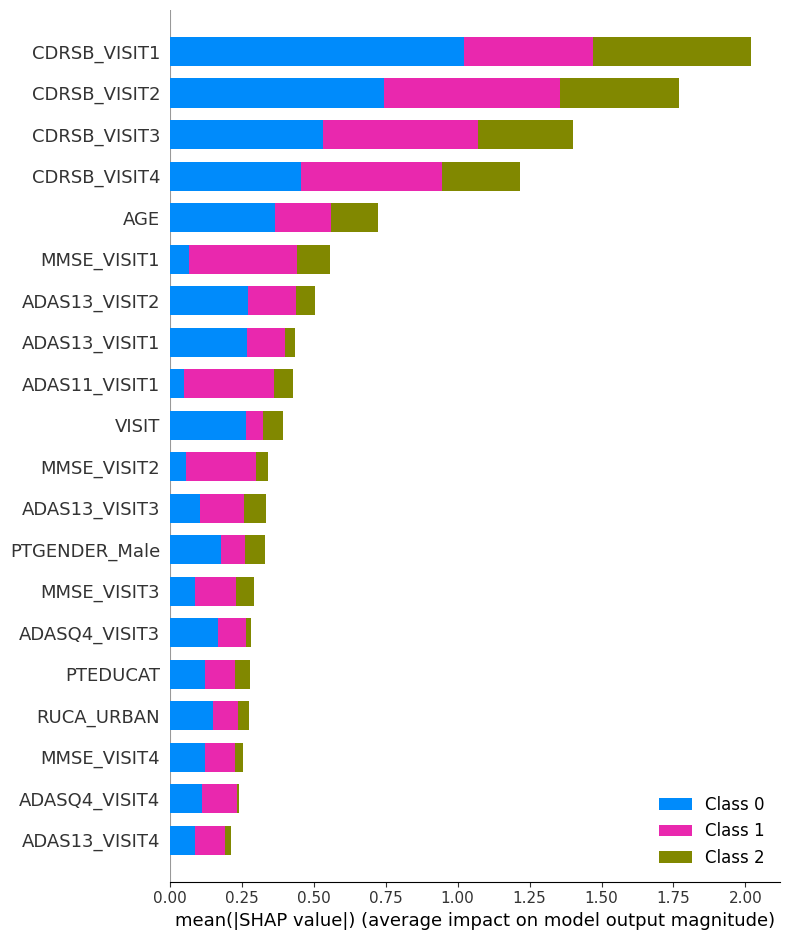

In [50]:
# SHAP values already computed, e.g.
# explainer = shap.Explainer(xgb_model)
# shap_values = explainer(X_test)

# Summary plot with ALL variables (cognitive included)
shap.summary_plot(shap_values, X_test_raw)


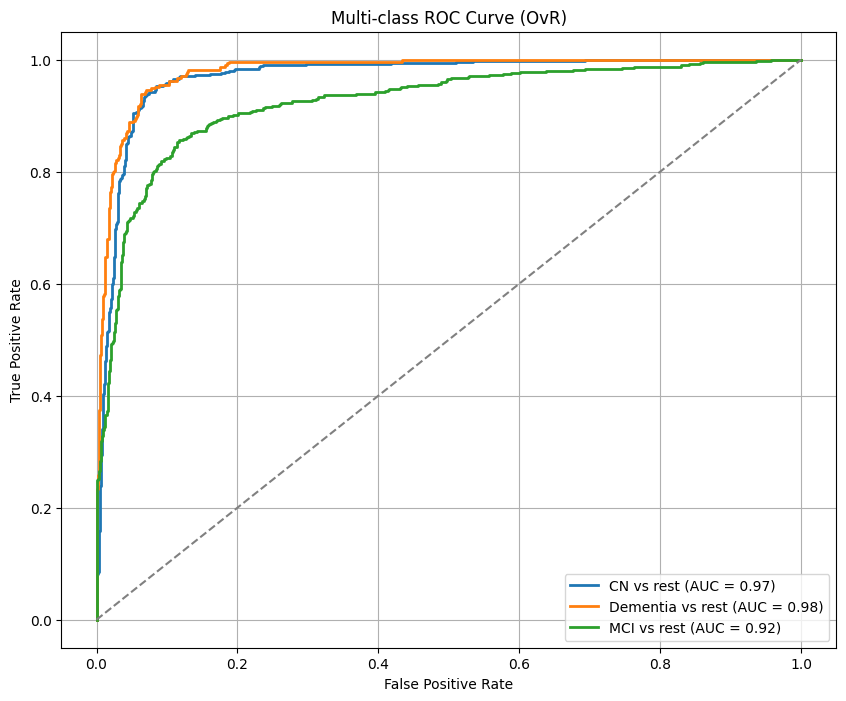

In [51]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

# Binarize labels
y_test_bin = label_binarize(y_test, classes=range(len(le.classes_)))
n_classes = y_test_bin.shape[1]

# Example with Logistic Regression (use other models too)
clf = OneVsRestClassifier(LogisticRegression(max_iter=5000))
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)

# Compute ROC and AUC
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{le.classes_[i]} vs rest (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve (OvR)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



In [52]:
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

X_raw = combined_df.drop(columns=['DX'])
y_raw = combined_df['DX'].astype(str)

le = LabelEncoder()
y = le.fit_transform(y_raw)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, stratify=y, test_size=0.2, random_state=42)
pipeline.fit(X_train_raw)
X_train = pipeline.transform(X_train_raw)
X_test = pipeline.transform(X_test_raw)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Decode for fairness compatibility
y_test_decoded = le.inverse_transform(y_test)
X_test_raw_with_labels = X_test_raw.copy()
X_test_raw_with_labels["DX"] = y_test_decoded


In [53]:
explainer = shap.TreeExplainer(rf_model)
os.makedirs("shap_plots", exist_ok=True)

for group_var in ['PTGENDER_Male', 'PTEDUCAT']:
    if group_var not in X_test_raw.columns:
        continue
    for val in X_test_raw[group_var].dropna().unique():
        mask = X_test_raw[group_var] == val
        data_subset = X_test[mask][:300]
        if data_subset.shape[0] < 20:
            continue
        shap_values = explainer.shap_values(data_subset)
        shap.summary_plot(shap_values, data_subset, feature_names=X_test_raw.columns, show=False)
        plt.title(f"SHAP Summary: {group_var} = {val}")
        plt.savefig(f"shap_plots/shap_{group_var}_{val}.png")
        plt.close()


<Figure size 640x480 with 0 Axes>

In [54]:
for edu_level in sorted(X_test_raw['PTEDUCAT'].dropna().unique()):
    mask = X_test_raw['PTEDUCAT'] == edu_level
    X_sub = X_test[mask]
    if X_sub.shape[0] < 30:
        continue  # skip small groups

    shap_vals = explainer.shap_values(X_sub)
    shap.summary_plot(
        shap_vals, X_sub, feature_names=X_test_raw.columns,
        show=False
    )
    plt.title(f"SHAP Summary - Education = {edu_level} years")
    plt.tight_layout()
    plt.savefig(f"shap_education_{edu_level}.png")
    plt.close()


<Figure size 640x480 with 0 Axes>

In [ ]:
explainer = shap.TreeExplainer(rf_model)
os.makedirs("shap_plots", exist_ok=True)

for group_var in ['PTGENDER_Male', 'PTEDUCAT']:
    if group_var not in X_test_raw.columns:
        continue

    for val in X_test_raw[group_var].dropna().unique():
        mask = X_test_raw[group_var] == val
        data_subset = X_test[mask][:300]  # Already preprocessed
        if data_subset.shape[0] < 20:
            continue

        shap_values = explainer.shap_values(data_subset)  # Multiclass → list of arrays

        # === Global SHAP summary across all classes (your original code) ===
        shap.summary_plot(shap_values, data_subset, feature_names=X_test_raw.columns, show=False)
        plt.title(f"SHAP Summary: {group_var} = {val} (All Classes)")
        plt.savefig(f"shap_plots/shap_{group_var}_{val}_ALL.png")
        plt.close()

        # === Class-specific SHAP summaries (NEW) ===
        for class_idx, class_name in zip([0, 1, 2], ['CN', 'MCI', 'AD']):
            shap_class_vals = shap_values[class_idx]

            shap.summary_plot(shap_class_vals, data_subset, feature_names=X_test_raw.columns, show=False)
            plt.title(f"SHAP Summary: {group_var} = {val} → {class_name}")
            plt.tight_layout()
            plt.savefig(f"shap_plots/shap_{group_var}_{val}_{class_name}.png")
            plt.close()


In [ ]:
for edu_level in sorted(X_test_raw['PTEDUCAT'].dropna().unique()):
    mask = X_test_raw['PTEDUCAT'] == edu_level
    X_sub = X_test[mask]
    if X_sub.shape[0] < 30:
        continue  # skip small groups

    shap_vals = explainer.shap_values(X_sub)  # List for multiclass

    # === Global SHAP summary (all classes aggregated) ===
    shap.summary_plot(
        shap_vals, X_sub, feature_names=X_test_raw.columns, show=False
    )
    plt.title(f"SHAP Summary - Education = {edu_level} years (All Classes)")
    plt.tight_layout()
    plt.savefig(f"shap_education_{edu_level}_ALL.png")
    plt.close()

    # === Class-specific SHAP summaries ===
    for class_idx, class_name in zip([0, 1, 2], ['CN', 'MCI', 'AD']):
        shap_class_vals = shap_vals[class_idx]
        shap.summary_plot(
            shap_class_vals, X_sub, feature_names=X_test_raw.columns, show=False
        )
        plt.title(f"SHAP Summary - Education = {edu_level} years → {class_name}")
        plt.tight_layout()
        plt.savefig(f"shap_education_{edu_level}_{class_name}.png")
        plt.close()


In [ ]:
explainer = shap.TreeExplainer(rf_model)
os.makedirs("shap_plots", exist_ok=True)

for group_var in ['PTGENDER_Male', 'PTEDUCAT']:
    if group_var not in X_test_raw.columns:
        continue

    for val in X_test_raw[group_var].dropna().unique():
        mask = X_test_raw[group_var] == val
        data_subset = X_test[mask][:300]  # Already preprocessed
        if data_subset.shape[0] < 20:
            continue

        shap_values = explainer.shap_values(data_subset)  # Multiclass → list of arrays

        # === Global SHAP summary across all classes (your original code) ===
        shap.summary_plot(shap_values, data_subset, feature_names=X_test_raw.columns, show=False)
        plt.title(f"SHAP Summary: {group_var} = {val} (All Classes)")
        plt.savefig(f"shap_plots/shap_{group_var}_{val}_ALL.png")
        plt.close()

        # === Class-specific SHAP summaries (NEW) ===
        for class_idx, class_name in zip([0, 1, 2], ['CN', 'MCI', 'AD']):
            shap_class_vals = shap_values[class_idx]

            shap.summary_plot(shap_class_vals, data_subset, feature_names=X_test_raw.columns, show=False)
            plt.title(f"SHAP Summary: {group_var} = {val} → {class_name}")
            plt.tight_layout()
            plt.savefig(f"shap_plots/shap_{group_var}_{val}_{class_name}.png")
            plt.close()


In [55]:
print(top_features.index)  

Index(['PTGENDER_Male', 'PTETHCAT_Not Hisp/Latino', 'PTETHCAT_Unknown',
       'PTRACCAT_Asian', 'PTRACCAT_Black', 'PTRACCAT_Hawaiian/Other PI',
       'PTRACCAT_More than one', 'PTRACCAT_Unknown', 'PTRACCAT_White',
       'PTMARRY_Married'],
      dtype='object')


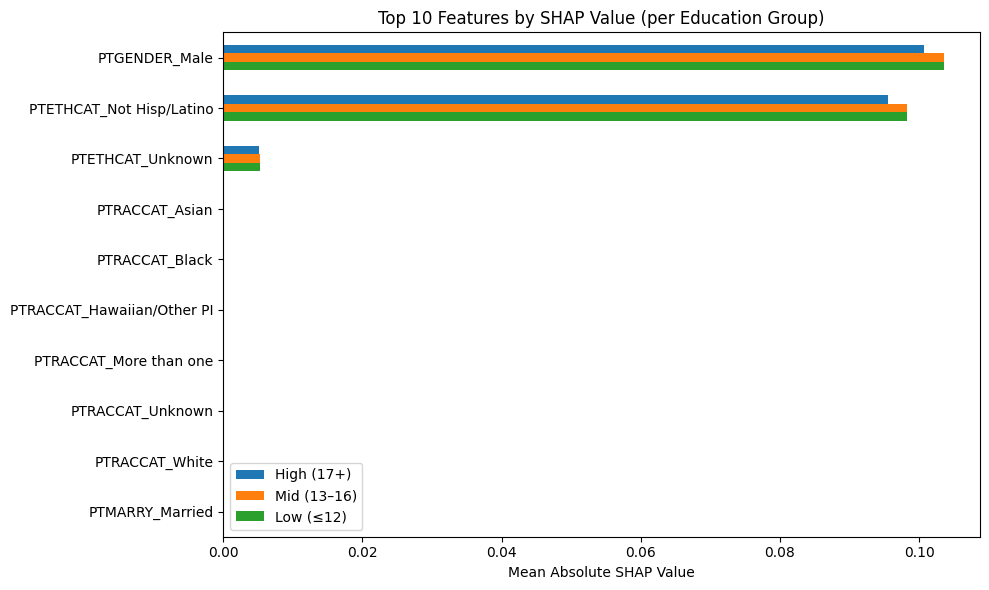

In [56]:
# reassign the numeric index
top_features.index = feature_cols[:len(top_features)]
feature_cols = X_train_raw.columns.tolist()


top_features.plot(kind='barh', figsize=(10, 6))
plt.gca().invert_yaxis()
plt.title("Top 10 Features by SHAP Value (per Education Group)")
plt.xlabel("Mean Absolute SHAP Value")
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

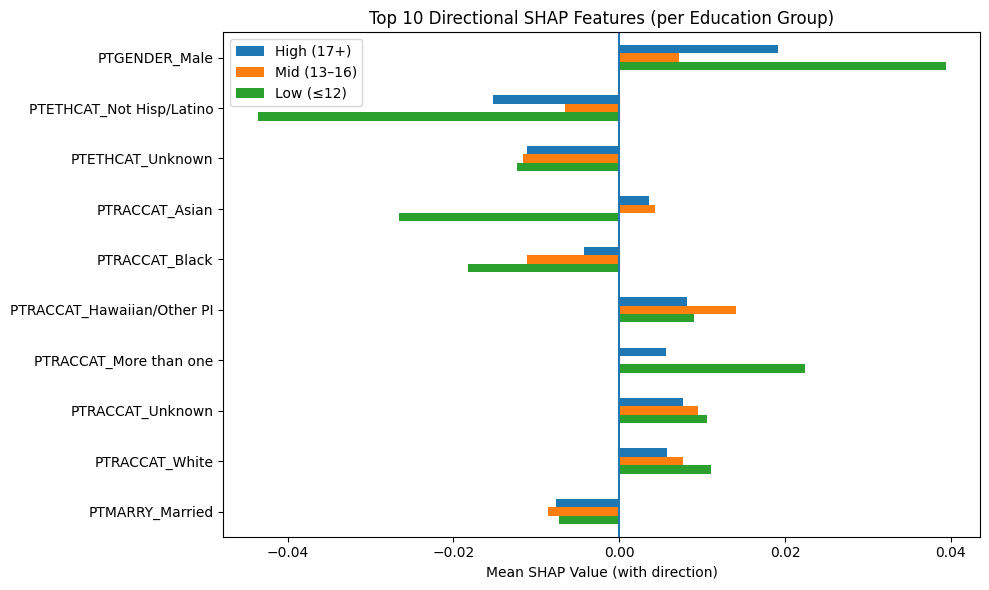

In [57]:
import matplotlib.pyplot as plt
# === Setup and SHAP Explainer ===
explainer = shap.TreeExplainer(rf_model)  # or xgb_model
os.makedirs("shap_plots", exist_ok=True)
feature_cols = X_train_raw.columns.tolist()

# === Grouping by education level ===
X_test_with_group = X_test_raw.copy()
X_test_with_group['EDU_GROUP'] = pd.cut(
    X_test_with_group['PTEDUCAT'],
    bins=[0, 12, 16, 25],
    labels=['Low (≤12)', 'Mid (13–16)', 'High (17+)']
)

# === Compute directional SHAP values per group ===
group_shap_means = {}

for group in X_test_with_group['EDU_GROUP'].dropna().unique():
    mask = X_test_with_group['EDU_GROUP'] == group
    X_sub_raw = X_test_with_group.loc[mask, feature_cols].copy()

    if X_sub_raw.shape[0] < 30:
        print(f"⏭️ Skipping {group} (too few samples: {X_sub_raw.shape[0]})")
        continue

    # Preprocess
    X_sub_transformed = pipeline.transform(X_sub_raw)

    # Compute SHAP values
    shap_vals = explainer.shap_values(X_sub_transformed)

    # === Mean signed SHAP ===
    if isinstance(shap_vals, list):  # multiclass
        shap_signed_mean = np.mean([class_vals.mean(axis=0) for class_vals in shap_vals], axis=0)
    else:
        shap_signed_mean = shap_vals.mean(axis=0)

    # Create SHAP DataFrame for this group
    shap_df = pd.DataFrame(
        shap_signed_mean.reshape(1, -1),
        columns=explainer.feature_names
    ).T
    shap_df.columns = [str(group)]
    shap_df.index.name = 'Feature'

    shap.summary_plot(shap_vals, X_sub_transformed, feature_names=explainer.feature_names, show=False, plot_type="dot")
    plt.title(f"SHAP Summary Plot - Education Group: {group}")
    plt.tight_layout()
    plt.savefig(f"shap_plots/shap_summary_{group}.png")
    plt.close()

    # Store result
    group_shap_means[group] = shap_df

# === Combine into one DataFrame ===
combined_shap_df = pd.concat(group_shap_means.values(), axis=1)

# === Find Top 10 features by mean ABS value ===
combined_shap_df['mean_abs_importance'] = combined_shap_df.abs().mean(axis=1)
top_features = combined_shap_df.sort_values('mean_abs_importance', ascending=False).head(10)
top_features.drop(columns='mean_abs_importance', inplace=True)

# reassign the numeric index
top_features.index = feature_cols[:len(top_features)]
feature_cols = X_train_raw.columns.tolist()

# === Plot Directional SHAP (Signed) ===
ax = top_features.plot(kind='barh', figsize=(10, 6))  # order matches group order
plt.axvline(0)
plt.gca().invert_yaxis()
plt.title("Top 10 Directional SHAP Features (per Education Group)")
plt.xlabel("Mean SHAP Value (with direction)")
plt.tight_layout()
plt.savefig("top10_shap_directional_by_edu.png")
plt.show()




In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# === Define groupings ===
X_test_with_group = X_test_raw.copy()

# Age groups
X_test_with_group['AGE_GROUP'] = pd.cut(
    X_test_with_group['AGE'],
    bins=[0, 65, 75, 120],
    labels=['65-', '65–75', '75+']
)
# === Subgroup variables (one-hot encoded dummies) ===
race_vars = [col for col in X_test_with_group.columns if col.startswith("PTRACCAT_")]
marry_vars = [col for col in X_test_with_group.columns if col.startswith("PTMARRY_")]
rural_vars = [col for col in X_test_with_group.columns if col.startswith("RUCA_")]
ethnicity_vars = [col for col in X_test_with_group.columns if col.startswith("PTETHCAT_")]

# SHAP storage
grouped_shap_data = {}

# === Define groupings to process ===
group_variables = {
    'AGE_GROUP': X_test_with_group['AGE_GROUP'].unique(),   # already defined earlier
    'PTGENDER_Male': [0, 1],

}

# Add binary subgroup dummies (only 1 is meaningful — 0 means "not in group")
for col in race_vars + marry_vars + rural_vars + ethnicity_vars:
    group_variables[col] = [1]

# === Compute SHAP values per group ===
for group_var, group_vals in group_variables.items():
    print(f"📊 SHAP for {group_var}")
    grouped_shap_data[group_var] = {}

    for val in group_vals:
        mask = X_test_with_group[group_var] == val
        label = f"{group_var}={val}"

        if mask.sum() < 30:
            print(f"⏭️ Skipping {label} (too few samples)")
            continue

        # Prepare subset
        X_sub_raw = X_test_raw.loc[mask, feature_cols]
        X_transformed = pipeline.transform(X_sub_raw)
        shap_vals = explainer.shap_values(X_transformed)

        # Aggregate SHAP values across samples & classes
        shap_combined = np.mean(shap_vals, axis=(0, 2))
        grouped_shap_data[group_var][label] = shap_combined




    


📊 SHAP for AGE_GROUP
📊 SHAP for PTGENDER_Male
📊 SHAP for PTRACCAT_Asian
📊 SHAP for PTRACCAT_Black
📊 SHAP for PTRACCAT_Hawaiian/Other PI
⏭️ Skipping PTRACCAT_Hawaiian/Other PI=1 (too few samples)
📊 SHAP for PTRACCAT_More than one
⏭️ Skipping PTRACCAT_More than one=1 (too few samples)
📊 SHAP for PTRACCAT_Unknown
⏭️ Skipping PTRACCAT_Unknown=1 (too few samples)
📊 SHAP for PTRACCAT_White
📊 SHAP for PTMARRY_Married
📊 SHAP for PTMARRY_Widowed
📊 SHAP for PTMARRY_Never married
📊 SHAP for PTMARRY_Unknown
⏭️ Skipping PTMARRY_Unknown=1 (too few samples)
📊 SHAP for RUCA_URBAN
📊 SHAP for RUCA_RURAL
📊 SHAP for RUCA_UNKNOWN
📊 SHAP for PTETHCAT_Not Hisp/Latino
📊 SHAP for PTETHCAT_Unknown
⏭️ Skipping PTETHCAT_Unknown=1 (too few samples)


In [74]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import os

# === Setup ===
explainer = shap.TreeExplainer(rf_model)  # or xgb_model
os.makedirs("shap_plots", exist_ok=True)
feature_cols = X_train_raw.columns.tolist()

# Add derived groupings
X_test_with_group = X_test_raw.copy()

# Education groups
X_test_with_group['EDU_GROUP'] = pd.cut(
    X_test_with_group['PTEDUCAT'],
    bins=[0, 12, 16, 25],
    labels=['Low (≤12)', 'Mid (13–16)', 'High (17+)']
)

# Age groups
X_test_with_group['AGE_GROUP'] = pd.cut(
    X_test_with_group['AGE'],
    bins=[0, 65, 75, 120],
    labels=['65-', '65–75', '75+']
)

# Binary dummy variables
race_vars = [col for col in X_test_with_group.columns if col.startswith("PTRACCAT_")]
marry_vars = [col for col in X_test_with_group.columns if col.startswith("PTMARRY_")]
rural_vars = [col for col in X_test_with_group.columns if col.startswith("RUCA_")]
ethnicity_vars = [col for col in X_test_with_group.columns if col.startswith("PTETHCAT_")]

# Define groups
group_variables = {
    'EDU_GROUP': X_test_with_group['EDU_GROUP'].unique(),
    'AGE_GROUP': X_test_with_group['AGE_GROUP'].unique(),
    'PTGENDER_Male': [0, 1]
}
for col in race_vars + marry_vars + rural_vars + ethnicity_vars:
    group_variables[col] = [1]

# === Compute directional SHAP (signed) per group × class ===
grouped_shap_data = {}
class_labels = ['CN', 'MCI', 'AD']  # Ensure this matches label encoding

for group_var, group_vals in group_variables.items():
    print(f"📊 SHAP for {group_var}")
    grouped_shap_data[group_var] = {}

    for val in group_vals:
        mask = X_test_with_group[group_var] == val
        label_base = f"{group_var}={val}"
        if mask.sum() < 30:
            print(f"⏭️ Skipping {label_base} (too few samples)")
            continue

        X_sub_raw = X_test_raw.loc[mask, feature_cols]
        X_transformed = pipeline.transform(X_sub_raw)
        shap_vals = explainer.shap_values(X_transformed)  # list of arrays

        for class_idx, class_name in enumerate(class_labels):
            shap_signed_mean = shap_vals[class_idx].mean(axis=0)
            full_label = f"{label_base} → {class_name}"
            grouped_shap_data[group_var][full_label] = shap_signed_mean
print(f"Label: {label}")
print(f"shap_vals shape: {np.shape(shap_vals)}")
print(f"feature_cols length: {len(feature_cols)}")


📊 SHAP for EDU_GROUP
📊 SHAP for AGE_GROUP
📊 SHAP for PTGENDER_Male
📊 SHAP for PTRACCAT_Asian
📊 SHAP for PTRACCAT_Black
📊 SHAP for PTRACCAT_Hawaiian/Other PI
⏭️ Skipping PTRACCAT_Hawaiian/Other PI=1 (too few samples)
📊 SHAP for PTRACCAT_More than one
⏭️ Skipping PTRACCAT_More than one=1 (too few samples)
📊 SHAP for PTRACCAT_Unknown
⏭️ Skipping PTRACCAT_Unknown=1 (too few samples)
📊 SHAP for PTRACCAT_White
📊 SHAP for PTMARRY_Married
📊 SHAP for PTMARRY_Widowed
📊 SHAP for PTMARRY_Never married
📊 SHAP for PTMARRY_Unknown
⏭️ Skipping PTMARRY_Unknown=1 (too few samples)
📊 SHAP for RUCA_URBAN
📊 SHAP for RUCA_RURAL
📊 SHAP for RUCA_UNKNOWN
📊 SHAP for PTETHCAT_Not Hisp/Latino
📊 SHAP for PTETHCAT_Unknown
⏭️ Skipping PTETHCAT_Unknown=1 (too few samples)
Label: EDU_GROUP=High (17+) → CN
shap_vals shape: (1383, 27, 3)
feature_cols length: 27


In [79]:
for group_var, shap_dict in grouped_shap_data.items():
    for label, shap_vals in shap_dict.items():
        print(f"{label} | SHAP shape: {np.shape(shap_vals)}")


EDU_GROUP=High (17+) → CN | SHAP shape: (3,)
EDU_GROUP=High (17+) → MCI | SHAP shape: (3,)
EDU_GROUP=High (17+) → AD | SHAP shape: (3,)
EDU_GROUP=Mid (13–16) → CN | SHAP shape: (3,)
EDU_GROUP=Mid (13–16) → MCI | SHAP shape: (3,)
EDU_GROUP=Mid (13–16) → AD | SHAP shape: (3,)
EDU_GROUP=Low (≤12) → CN | SHAP shape: (3,)
EDU_GROUP=Low (≤12) → MCI | SHAP shape: (3,)
EDU_GROUP=Low (≤12) → AD | SHAP shape: (3,)
AGE_GROUP=65–75 → CN | SHAP shape: (3,)
AGE_GROUP=65–75 → MCI | SHAP shape: (3,)
AGE_GROUP=65–75 → AD | SHAP shape: (3,)
AGE_GROUP=75+ → CN | SHAP shape: (3,)
AGE_GROUP=75+ → MCI | SHAP shape: (3,)
AGE_GROUP=75+ → AD | SHAP shape: (3,)
AGE_GROUP=65- → CN | SHAP shape: (3,)
AGE_GROUP=65- → MCI | SHAP shape: (3,)
AGE_GROUP=65- → AD | SHAP shape: (3,)
PTGENDER_Male=0 → CN | SHAP shape: (3,)
PTGENDER_Male=0 → MCI | SHAP shape: (3,)
PTGENDER_Male=0 → AD | SHAP shape: (3,)
PTGENDER_Male=1 → CN | SHAP shape: (3,)
PTGENDER_Male=1 → MCI | SHAP shape: (3,)
PTGENDER_Male=1 → AD | SHAP shape: (3,)

In [84]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import os

# === Setup ===
explainer = shap.TreeExplainer(rf_model)  # or xgb_model
feature_cols = X_train_raw.columns.tolist()
os.makedirs("shap_plots_grouped", exist_ok=True)

X_test_with_group = X_test_raw.copy()

# === Define Groups ===
X_test_with_group['EDU_GROUP'] = pd.cut(
    X_test_with_group['PTEDUCAT'],
    bins=[0, 12, 16, 25],
    labels=['Low (≤12)', 'Mid (13–16)', 'High (17+)']
)
X_test_with_group['AGE_GROUP'] = pd.cut(
    X_test_with_group['AGE'],
    bins=[0, 65, 75, 120],
    labels=['65-', '65–75', '75+']
)

race_vars = [col for col in X_test_with_group.columns if col.startswith("PTRACCAT_")]
marry_vars = [col for col in X_test_with_group.columns if col.startswith("PTMARRY_")]
rural_vars = [col for col in X_test_with_group.columns if col.startswith("RUCA_")]
ethnicity_vars = [col for col in X_test_with_group.columns if col.startswith("PTETHCAT_")]

group_variables = {
    'EDU_GROUP': X_test_with_group['EDU_GROUP'].unique(),
    'AGE_GROUP': X_test_with_group['AGE_GROUP'].unique(),
    'PTGENDER_Male': [0, 1]
}
for col in race_vars + marry_vars + rural_vars + ethnicity_vars:
    group_variables[col] = [1]

class_labels = ['CN', 'MCI', 'AD']
grouped_shap_data = {}

# === Compute SHAP ===
for group_var, group_vals in group_variables.items():
    print(f"\n📊 SHAP for {group_var}")
    grouped_shap_data[group_var] = {}

    for val in group_vals:
        mask = X_test_with_group[group_var] == val
        label_base = f"{group_var}={val}"
        if mask.sum() < 30:
            print(f"⏭️ Skipping {label_base} (too few samples)")
            continue

        X_sub_raw = X_test_raw.loc[mask, feature_cols]
        X_transformed = pipeline.transform(X_sub_raw)

        shap_vals_list = explainer.shap_values(X_transformed)  # list of 3 arrays

        for class_idx, class_name in enumerate(class_labels):
            shap_array = shap_vals_list[class_idx]  # shape: (n_samples, n_features)
            if shap_array.ndim == 2 and shap_array.shape[1] == len(feature_cols):
                shap_signed_mean = shap_array.mean(axis=0)
                full_label = f"{label_base} → {class_name}"
                grouped_shap_data[group_var][full_label] = shap_signed_mean
                print(f"✅ Stored SHAP for {full_label} | shape: {shap_signed_mean.shape}")
            else:
                print(f"⚠️ Skipping {label_base} → {class_name}: unexpected shape {shap_array.shape}")





📊 SHAP for EDU_GROUP
⚠️ Skipping EDU_GROUP=High (17+) → CN: unexpected shape (27, 3)
⚠️ Skipping EDU_GROUP=High (17+) → MCI: unexpected shape (27, 3)
⚠️ Skipping EDU_GROUP=High (17+) → AD: unexpected shape (27, 3)
⚠️ Skipping EDU_GROUP=Mid (13–16) → CN: unexpected shape (27, 3)
⚠️ Skipping EDU_GROUP=Mid (13–16) → MCI: unexpected shape (27, 3)
⚠️ Skipping EDU_GROUP=Mid (13–16) → AD: unexpected shape (27, 3)
⚠️ Skipping EDU_GROUP=Low (≤12) → CN: unexpected shape (27, 3)
⚠️ Skipping EDU_GROUP=Low (≤12) → MCI: unexpected shape (27, 3)
⚠️ Skipping EDU_GROUP=Low (≤12) → AD: unexpected shape (27, 3)

📊 SHAP for AGE_GROUP
⚠️ Skipping AGE_GROUP=65–75 → CN: unexpected shape (27, 3)
⚠️ Skipping AGE_GROUP=65–75 → MCI: unexpected shape (27, 3)
⚠️ Skipping AGE_GROUP=65–75 → AD: unexpected shape (27, 3)
⚠️ Skipping AGE_GROUP=75+ → CN: unexpected shape (27, 3)
⚠️ Skipping AGE_GROUP=75+ → MCI: unexpected shape (27, 3)
⚠️ Skipping AGE_GROUP=75+ → AD: unexpected shape (27, 3)
⚠️ Skipping AGE_GROUP=65- →

In [85]:
shap_vals_list = explainer.shap_values(X_transformed)

for class_idx, class_name in enumerate(class_labels):
    shap_array = shap_vals_list[class_idx]  # shape should be (n_samples, n_features)
    print(f"🧪 SHAP for class {class_name}: shape = {shap_array.shape}")


🧪 SHAP for class CN: shape = (27, 3)
🧪 SHAP for class MCI: shape = (27, 3)
🧪 SHAP for class AD: shape = (27, 3)


In [ ]:
# === Plot SHAP ===
for group_var, shap_dict in grouped_shap_data.items():
    for label, shap_vals in shap_dict.items():
        print(f"🔍 Plotting {label} | SHAP shape: {shap_vals.shape}")
        if not isinstance(shap_vals, np.ndarray) or shap_vals.ndim != 1 or len(shap_vals) != len(feature_cols):
            print(f"❌ Skipping {label}: SHAP shape mismatch")
            continue

        try:
            shap_df = pd.DataFrame({label: shap_vals}, index=feature_cols)
            top_features = shap_df[label].abs().sort_values(ascending=False).head(10).index
            shap_df_top = shap_df.loc[top_features]

            ax = shap_df_top.T.plot(kind='barh', figsize=(10, 6))
            plt.axvline(0, color='gray', linestyle='--')
            plt.title(f"Top 10 SHAP Features – {label}")
            plt.xlabel("Mean SHAP Value (directional)")
            plt.tight_layout()

            safe_label = label.replace(" ", "_").replace("→", "to").replace("≤", "le").replace("/", "_")
            plt.savefig(f"shap_plots_grouped/shap_{safe_label}.png")
            plt.close()
        except Exception as e:
            print(f"⚠️ Error while plotting {label}: {e}")

In [86]:
explainer = shap.TreeExplainer(rf_model, feature_perturbation="interventional")


In [87]:
grouped_shap_data = {}
class_labels = ['CN', 'MCI', 'AD']  # Your model's output classes

for group_var, group_vals in group_variables.items():
    print(f"\n📊 SHAP for {group_var}")
    grouped_shap_data[group_var] = {}

    for val in group_vals:
        mask = X_test_with_group[group_var] == val
        label_base = f"{group_var}={val}"
        if mask.sum() < 30:
            print(f"⏭️ Skipping {label_base} (too few samples)")
            continue

        X_sub_raw = X_test_raw.loc[mask, feature_cols]
        X_transformed = pipeline.transform(X_sub_raw)

        # Get raw SHAP values
        shap_vals_raw = explainer.shap_values(X_transformed)  # Expect list of 3 arrays

        # Check shape and transpose if necessary
        shap_vals = []
        for idx, sv in enumerate(shap_vals_raw):
            if sv.shape[1] == 3 and sv.shape[0] == len(feature_cols):  # e.g., (27, 3)
                print(f"⚠️ SHAP[{idx}] is transposed. Fixing...")
                sv = sv.T
            shap_vals.append(sv)

        for class_idx, class_name in enumerate(class_labels):
            shap_array = shap_vals[class_idx]  # shape should now be (n_samples, n_features)
            if shap_array.ndim == 2 and shap_array.shape[1] == len(feature_cols):
                shap_signed_mean = shap_array.mean(axis=0)  # shape (n_features,)
                full_label = f"{label_base} → {class_name}"
                grouped_shap_data[group_var][full_label] = shap_signed_mean
                print(f"✅ Stored SHAP for {full_label} | shape: {shap_signed_mean.shape}")
            else:
                print(f"❌ Skipping {label_base} → {class_name}: SHAP shape = {shap_array.shape}")



📊 SHAP for EDU_GROUP
⚠️ SHAP[0] is transposed. Fixing...
⚠️ SHAP[1] is transposed. Fixing...
⚠️ SHAP[2] is transposed. Fixing...
⚠️ SHAP[3] is transposed. Fixing...
⚠️ SHAP[4] is transposed. Fixing...
⚠️ SHAP[5] is transposed. Fixing...
⚠️ SHAP[6] is transposed. Fixing...
⚠️ SHAP[7] is transposed. Fixing...
⚠️ SHAP[8] is transposed. Fixing...
⚠️ SHAP[9] is transposed. Fixing...
⚠️ SHAP[10] is transposed. Fixing...
⚠️ SHAP[11] is transposed. Fixing...
⚠️ SHAP[12] is transposed. Fixing...
⚠️ SHAP[13] is transposed. Fixing...
⚠️ SHAP[14] is transposed. Fixing...
⚠️ SHAP[15] is transposed. Fixing...
⚠️ SHAP[16] is transposed. Fixing...
⚠️ SHAP[17] is transposed. Fixing...
⚠️ SHAP[18] is transposed. Fixing...
⚠️ SHAP[19] is transposed. Fixing...
⚠️ SHAP[20] is transposed. Fixing...
⚠️ SHAP[21] is transposed. Fixing...
⚠️ SHAP[22] is transposed. Fixing...
⚠️ SHAP[23] is transposed. Fixing...
⚠️ SHAP[24] is transposed. Fixing...
⚠️ SHAP[25] is transposed. Fixing...
⚠️ SHAP[26] is transposed.

In [88]:
import matplotlib.pyplot as plt
import os

os.makedirs("shap_plots_grouped", exist_ok=True)

for group_var, shap_dict in grouped_shap_data.items():
    for label, shap_vals in shap_dict.items():
        print(f"🔍 Plotting {label} | SHAP shape: {shap_vals.shape}")
        if not isinstance(shap_vals, np.ndarray) or shap_vals.ndim != 1 or len(shap_vals) != len(feature_cols):
            print(f"❌ Skipping {label}: SHAP shape mismatch")
            continue

        try:
            shap_df = pd.DataFrame({label: shap_vals}, index=feature_cols)
            top_features = shap_df[label].abs().sort_values(ascending=False).head(10).index
            shap_df_top = shap_df.loc[top_features]

            ax = shap_df_top.T.plot(kind='barh', figsize=(10, 6))
            plt.axvline(0, color='gray', linestyle='--')
            plt.title(f"Top 10 SHAP Features – {label}")
            plt.xlabel("Mean SHAP Value (directional)")
            plt.tight_layout()

            safe_label = label.replace(" ", "_").replace("→", "to").replace("≤", "le").replace("/", "_")
            plt.savefig(f"shap_plots_grouped/shap_{safe_label}.png")
            plt.close()
        except Exception as e:
            print(f"⚠️ Error while plotting {label}: {e}")


🔍 Plotting EDU_GROUP=High (17+) → CN | SHAP shape: (27,)
🔍 Plotting EDU_GROUP=High (17+) → MCI | SHAP shape: (27,)
🔍 Plotting EDU_GROUP=High (17+) → AD | SHAP shape: (27,)
🔍 Plotting EDU_GROUP=Mid (13–16) → CN | SHAP shape: (27,)
🔍 Plotting EDU_GROUP=Mid (13–16) → MCI | SHAP shape: (27,)
🔍 Plotting EDU_GROUP=Mid (13–16) → AD | SHAP shape: (27,)
🔍 Plotting EDU_GROUP=Low (≤12) → CN | SHAP shape: (27,)
🔍 Plotting EDU_GROUP=Low (≤12) → MCI | SHAP shape: (27,)
🔍 Plotting EDU_GROUP=Low (≤12) → AD | SHAP shape: (27,)
🔍 Plotting AGE_GROUP=65–75 → CN | SHAP shape: (27,)
🔍 Plotting AGE_GROUP=65–75 → MCI | SHAP shape: (27,)
🔍 Plotting AGE_GROUP=65–75 → AD | SHAP shape: (27,)
🔍 Plotting AGE_GROUP=75+ → CN | SHAP shape: (27,)
🔍 Plotting AGE_GROUP=75+ → MCI | SHAP shape: (27,)
🔍 Plotting AGE_GROUP=75+ → AD | SHAP shape: (27,)
🔍 Plotting AGE_GROUP=65- → CN | SHAP shape: (27,)
🔍 Plotting AGE_GROUP=65- → MCI | SHAP shape: (27,)
🔍 Plotting AGE_GROUP=65- → AD | SHAP shape: (27,)
🔍 Plotting PTGENDER_Male=

In [89]:
# Inspect SHAP values directly
label_to_check = 'PTETHCAT_Not Hisp/Latino=1 → AD'
print(f"\n🔍 {label_to_check}")
print(grouped_shap_data['PTETHCAT_Not Hisp/Latino'][label_to_check])
print("Mean absolute SHAP:", np.abs(grouped_shap_data['PTETHCAT_Not Hisp/Latino'][label_to_check]).mean())



🔍 PTETHCAT_Not Hisp/Latino=1 → AD
[4.07660017e-17 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00]
Mean absolute SHAP: 1.5098519142761098e-18


In [93]:
X_transformed = pipeline.transform(X_test_raw)
shap_vals = explainer.shap_values(X_transformed)

for class_idx, class_name in enumerate(['CN', 'MCI', 'AD']):
    shap_mean = np.mean(shap_vals[class_idx], axis=0)
    shap_df = pd.DataFrame({'Feature': feature_cols, 'SHAP': shap_mean})
    shap_df = shap_df.set_index('Feature').sort_values(by='SHAP', key=abs, ascending=False)
    shap_df.head(10).plot(kind='barh', legend=False, figsize=(8,6))
    plt.title(f"Top 10 Directional SHAP Values → {class_name}")
    plt.axvline(0, color='gray', linestyle='--')
    plt.tight_layout()
    plt.show()


ValueError: All arrays must be of the same length

⚠️ Transposing SHAP[0] from (27, 3)
⚠️ Transposing SHAP[1] from (27, 3)
⚠️ Transposing SHAP[2] from (27, 3)
⚠️ Transposing SHAP[3] from (27, 3)
⚠️ Transposing SHAP[4] from (27, 3)
⚠️ Transposing SHAP[5] from (27, 3)
⚠️ Transposing SHAP[6] from (27, 3)
⚠️ Transposing SHAP[7] from (27, 3)
⚠️ Transposing SHAP[8] from (27, 3)
⚠️ Transposing SHAP[9] from (27, 3)
⚠️ Transposing SHAP[10] from (27, 3)
⚠️ Transposing SHAP[11] from (27, 3)
⚠️ Transposing SHAP[12] from (27, 3)
⚠️ Transposing SHAP[13] from (27, 3)
⚠️ Transposing SHAP[14] from (27, 3)
⚠️ Transposing SHAP[15] from (27, 3)
⚠️ Transposing SHAP[16] from (27, 3)
⚠️ Transposing SHAP[17] from (27, 3)
⚠️ Transposing SHAP[18] from (27, 3)
⚠️ Transposing SHAP[19] from (27, 3)
⚠️ Transposing SHAP[20] from (27, 3)
⚠️ Transposing SHAP[21] from (27, 3)
⚠️ Transposing SHAP[22] from (27, 3)
⚠️ Transposing SHAP[23] from (27, 3)
⚠️ Transposing SHAP[24] from (27, 3)
⚠️ Transposing SHAP[25] from (27, 3)
⚠️ Transposing SHAP[26] from (27, 3)
⚠️ Transpos

AssertionError: Feature and SHAP matrices must have the same number of rows!

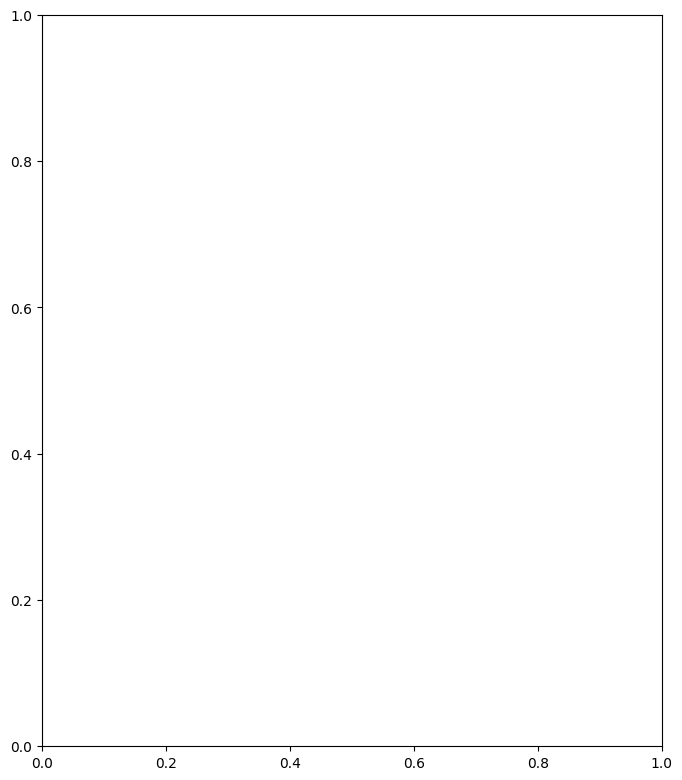

In [96]:
import shap
import matplotlib.pyplot as plt

# Step 1: Transform the test set
X_transformed = pipeline.transform(X_test_raw)

# Step 2: Compute SHAP values
shap_vals_raw = explainer.shap_values(X_transformed)  # may be (n_features, n_samples)
shap_vals = []

# Step 3: Ensure correct shape: (n_samples, n_features)
for i, sv in enumerate(shap_vals_raw):
    if sv.shape[0] == len(feature_cols):  # means it's (n_features, n_samples)
        print(f"⚠️ Transposing SHAP[{i}] from {sv.shape}")
        sv = sv.T
    shap_vals.append(sv)

# Step 4: Plot side-by-side
class_labels = ['CN', 'MCI', 'AD']
plt.figure(figsize=(18, 5))

for idx, class_name in enumerate(class_labels):
    plt.subplot(1, 3, idx + 1)
    shap.summary_plot(
        shap_vals[idx],
        features=X_transformed,  # use transformed data
        feature_names=feature_cols,
        show=False
    )

    plt.title(f"SHAP Summary – {class_name}")

plt.tight_layout()
plt.savefig("shap_summary_all_classes.png", bbox_inches='tight')
plt.show()


In [97]:
# Step 1: Transform data
X_transformed = pipeline.transform(X_test_raw)

# Step 2: Compute SHAP values
explainer = shap.TreeExplainer(rf_model, feature_perturbation="interventional")
shap_vals = explainer.shap_values(X_transformed)

# Optional: confirm correct shape
for i, class_name in enumerate(['CN', 'MCI', 'AD']):
    print(f"✅ SHAP[{class_name}] shape: {shap_vals[i].shape}")


✅ SHAP[CN] shape: (27, 3)
✅ SHAP[MCI] shape: (27, 3)
✅ SHAP[AD] shape: (27, 3)


In [98]:
X_transformed = pipeline.transform(X_test_raw)
print("✅ X_transformed shape:", X_transformed.shape)  # This must be (n_samples, n_features)


✅ X_transformed shape: (1428, 27)


In [99]:
import shap

# 1. Confirm your model is trained for multiclass (e.g., 3 classes)
# 2. Properly set the SHAP explainer using model output format
explainer = shap.TreeExplainer(rf_model, model_output="raw", feature_perturbation="interventional")

# 3. Use correct input shape (already confirmed: 1428, 27)
X_transformed = pipeline.transform(X_test_raw)

# 4. Get SHAP values
shap_vals = explainer.shap_values(X_transformed)  # Should return 3 arrays

# 5. Confirm SHAP output shape
for i, name in enumerate(['CN', 'MCI', 'AD']):
    print(f"✅ SHAP[{name}] shape:", shap_vals[i].shape)  # Should be (142_


✅ SHAP[CN] shape: (27, 3)
✅ SHAP[MCI] shape: (27, 3)
✅ SHAP[AD] shape: (27, 3)


In [106]:
explainer = shap.Explainer(rf_model, X_transformed, algorithm="tree")


In [107]:
shap_vals = explainer(X_transformed)

print("✅ SHAP shape:", shap_vals.values.shape)  # Should be (1428, 3, 27)


✅ SHAP shape: (1428, 27, 3)


In [108]:
shap_vals_by_class = shap_vals.values.transpose(2, 0, 1)  # ✅ shape: (3, 1428, 27)


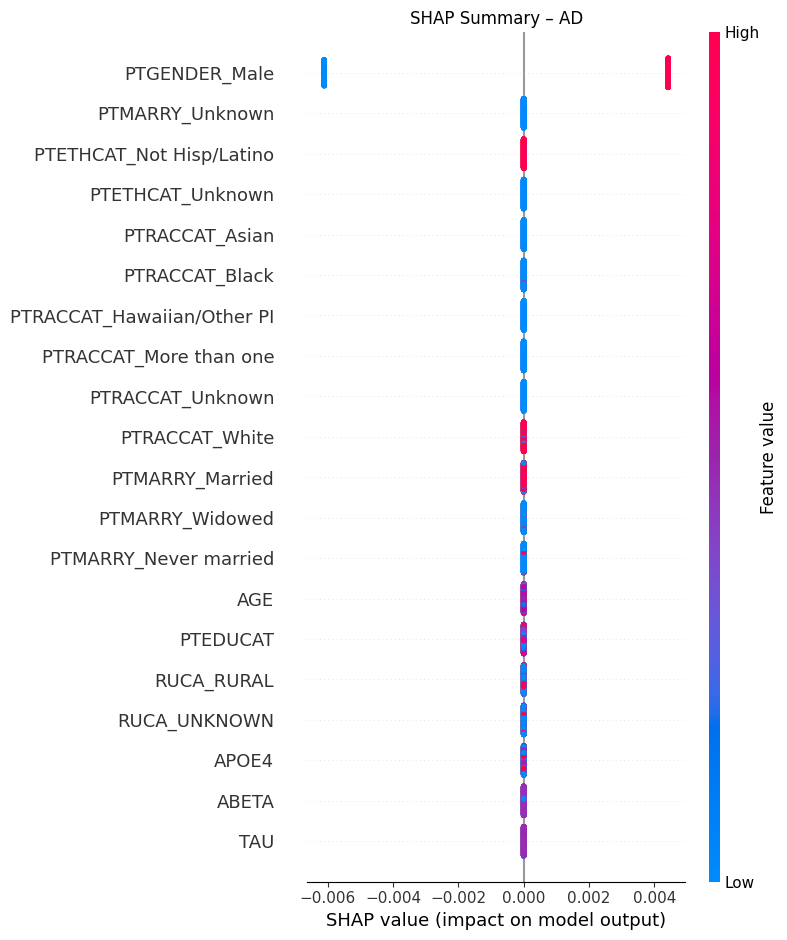

In [109]:
class_labels = ['CN', 'MCI', 'AD']
plt.figure(figsize=(18, 5))

for idx, class_name in enumerate(class_labels):
    plt.subplot(1, 3, idx + 1)
    shap.summary_plot(
        shap_vals_by_class[idx],          # shape: (samples, features)
        features=X_transformed,
        feature_names=feature_cols,
        show=False
    )
    plt.title(f"SHAP Summary – {class_name}")

plt.tight_layout()
plt.savefig("shap_summary_all_classes.png")
plt.show()


In [110]:
for idx, class_name in enumerate(['CN', 'MCI', 'AD']):
    shap.summary_plot(
        shap_vals_by_class[idx],
        features=X_transformed,
        feature_names=feature_cols,
        show=False
    )
    plt.title(f"SHAP Summary – {class_name}")
    plt.tight_layout()
    plt.savefig(f"shap_summary_{class_name}.png")
    plt.clf()


<Figure size 800x950 with 0 Axes>

In [115]:
print(pipeline.named_steps)


{'imputer': SimpleImputer(strategy='median'), 'scaler': StandardScaler(), 'select': SelectKBest(k=50)}


In [ ]:

# === Plot directional SHAP per group × class ===
for group_var, shap_dict in grouped_shap_data.items():
    for label, shap_vals in shap_dict.items():
        shap_df = pd.DataFrame({label: shap_vals}, index=feature_cols)
        top_features = shap_df[label].abs().sort_values(ascending=False).head(10).index
        shap_df_top = shap_df.loc[top_features]

        if shap_df_top.empty:
            print(f"⚠️ No SHAP values to plot for {label} (empty top features)")
            continue

        ax = shap_df_top.T.plot(kind='barh', figsize=(10, 6))
        plt.axvline(0, color='gray', linestyle='--')
        plt.title(f"Top 10 Directional SHAP – {label}")
        plt.xlabel("Mean SHAP Value (Signed)")
        plt.tight_layout()

        # Clean filename
        safe_label = label.replace(" ", "_").replace("≤", "le").replace("/", "_").replace("<", "").replace(">", "").replace("→", "to")
        plt.savefig(f"shap_plots/shap_grouped_{safe_label}.png")
        plt.show()


In [118]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train_raw)  # or whatever your training target is called
y_test_encoded = le.transform(y_test_raw)


NameError: name 'y_train_raw' is not defined

In [59]:
# === Plot Top 10 SHAP features per group ===
# === Plot Top 10 SHAP features per group ===

    
for group_var, shap_dict in grouped_shap_data.items():
    for label, shap_vals in shap_dict.items():
        shap_df = pd.DataFrame({label: shap_vals}, index=feature_cols)
        top_features = shap_df[label].abs().sort_values(ascending=False).head(10).index
        shap_df_top = shap_df.loc[top_features]
        if shap_df_top.empty:
            print(f"⚠️ No SHAP values to plot for {group_var} (empty top features)")
        continue

        shap_df_top.T.plot(kind='barh', figsize=(10, 6))
        plt.axvline(0, color='gray', linestyle='--')
        plt.title(f"Top 10 Features by SHAP Value – {label}")
        plt.xlabel("Mean SHAP Value (directional)")
        shap_df_top.T.plot(kind='barh', figsize=(10, 6))
        plt.tight_layout()
        plt.savefig(f"shap_grouped_{group_var}.png")
        plt.show()

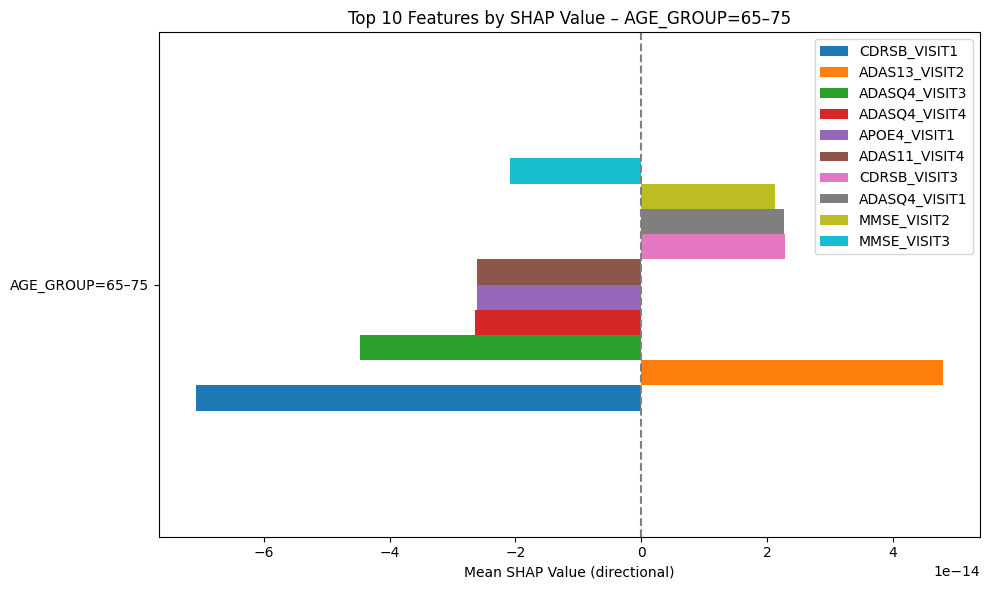

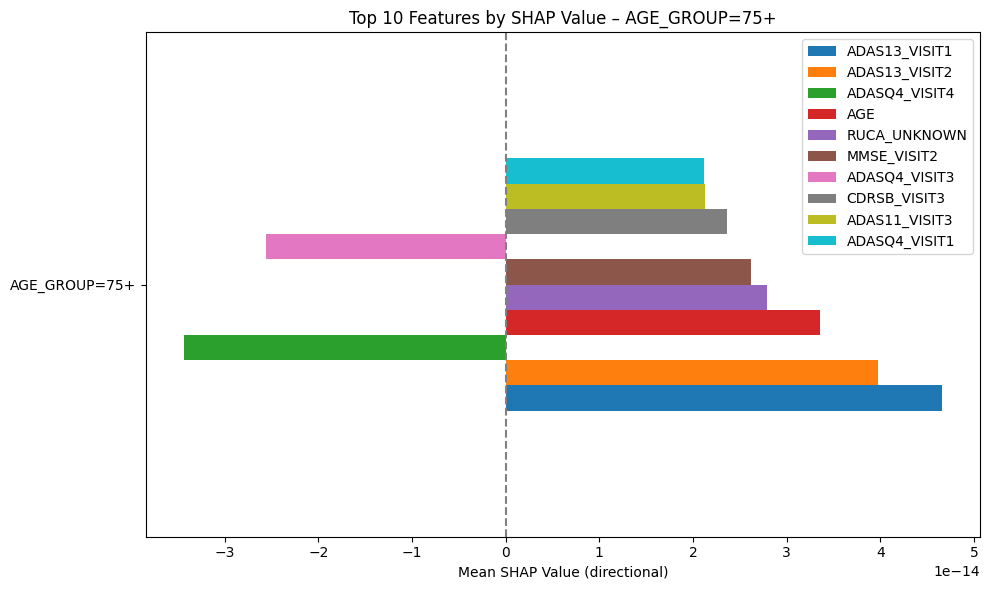

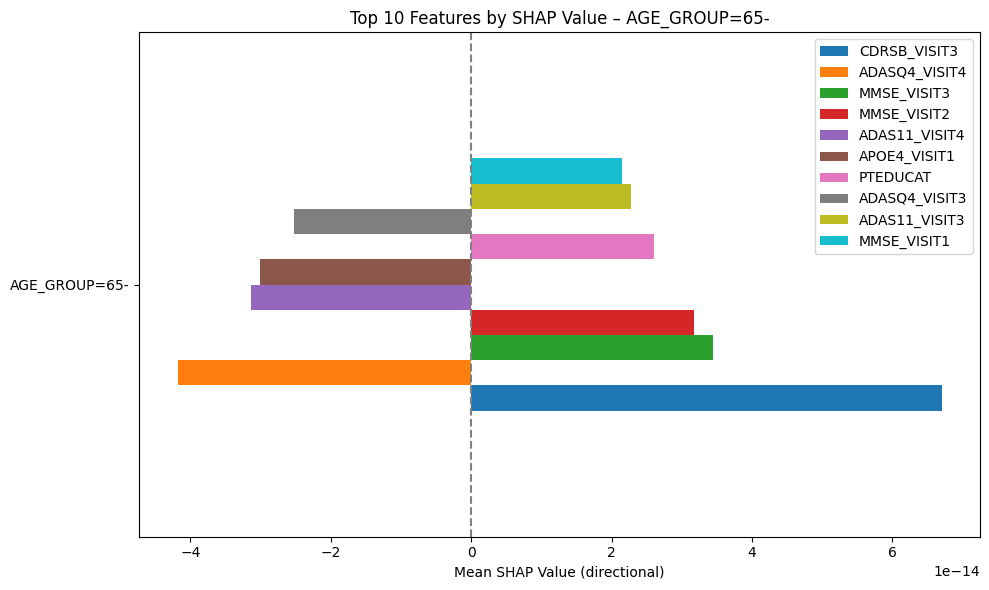

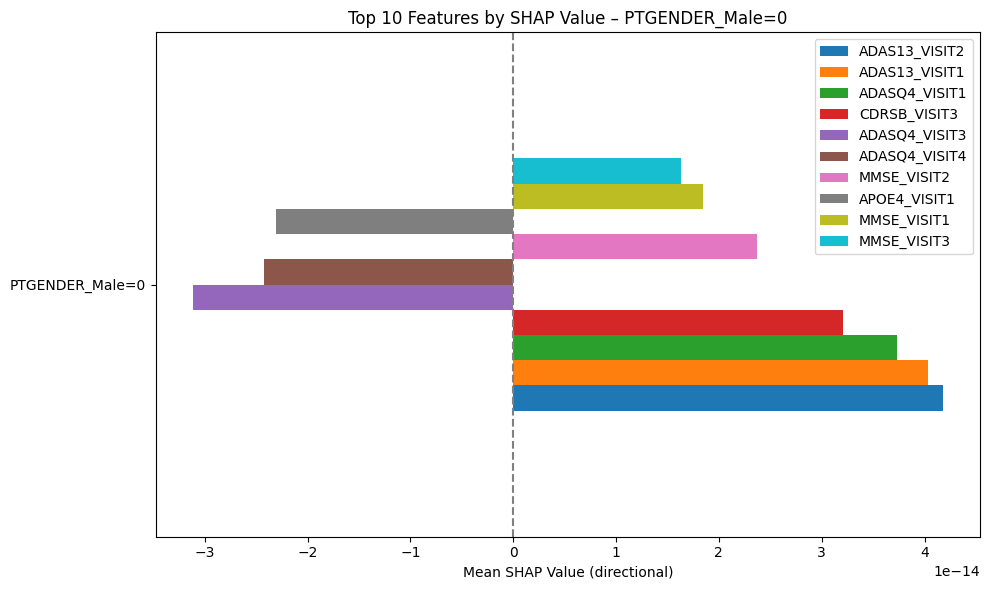

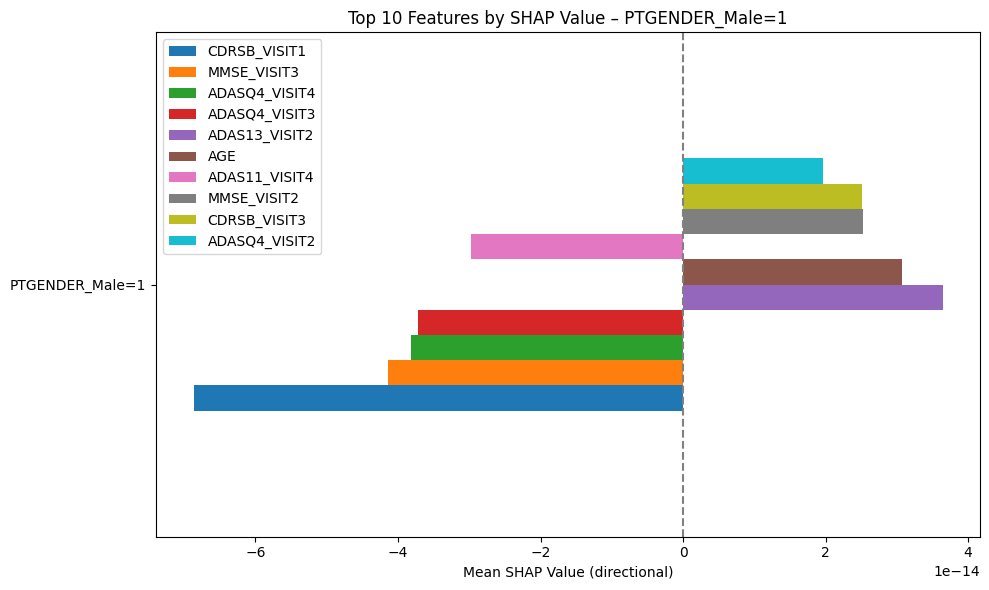

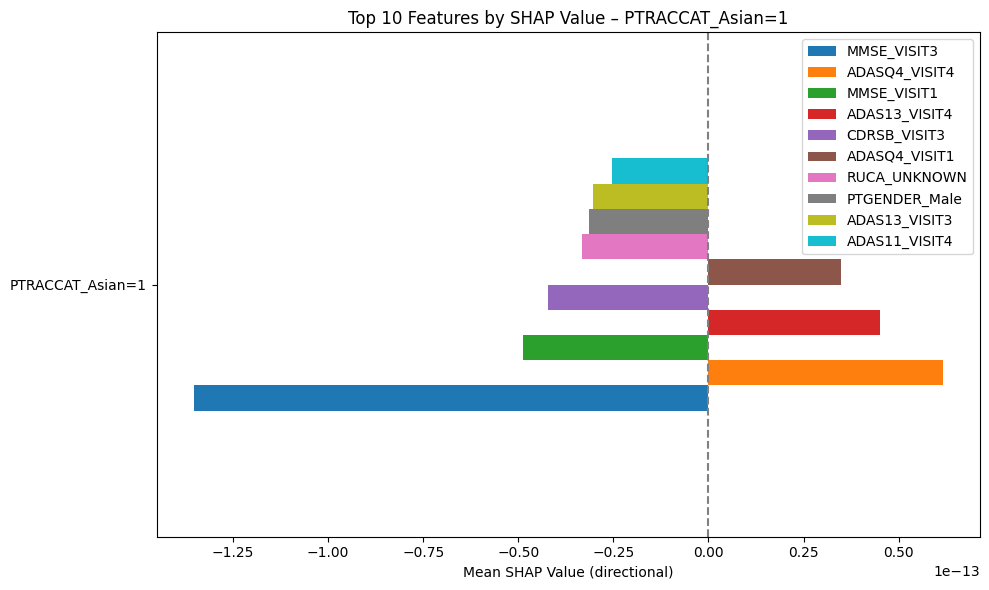

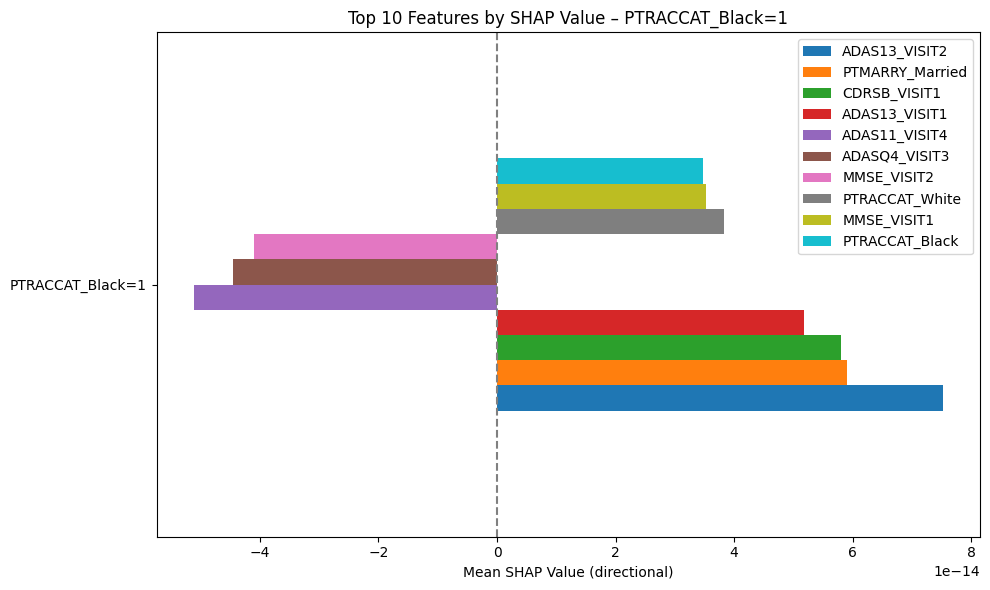

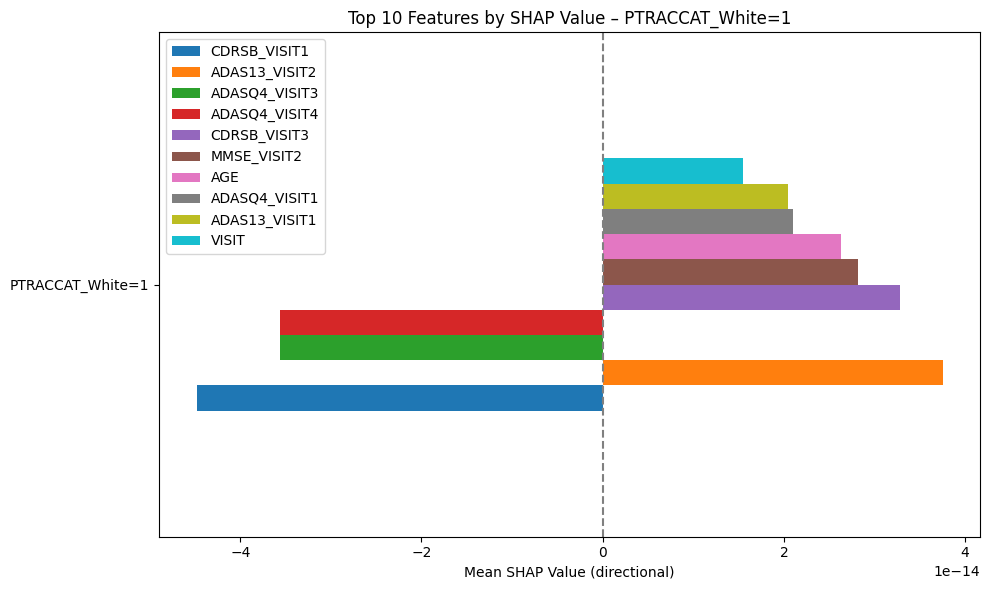

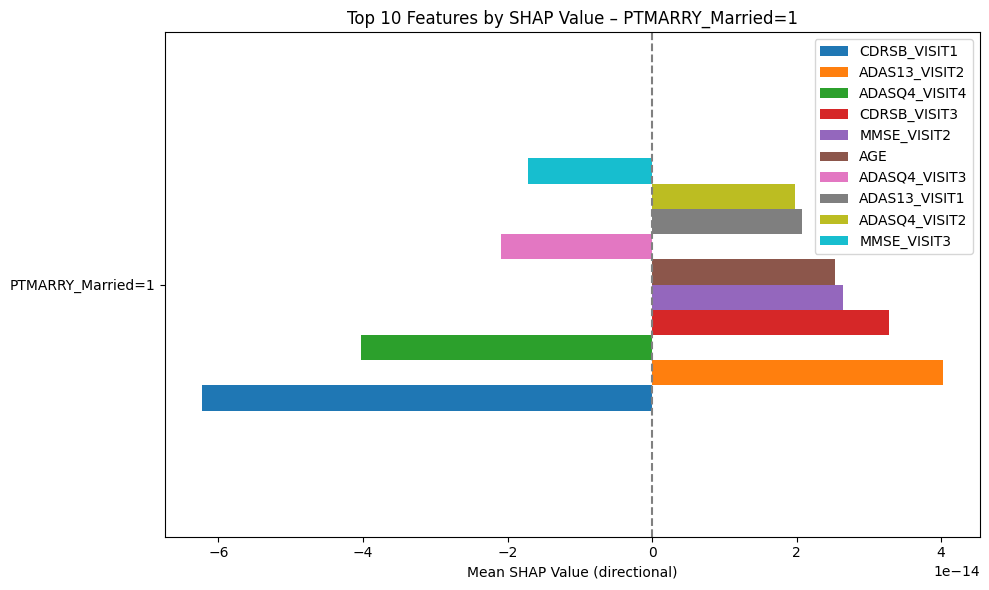

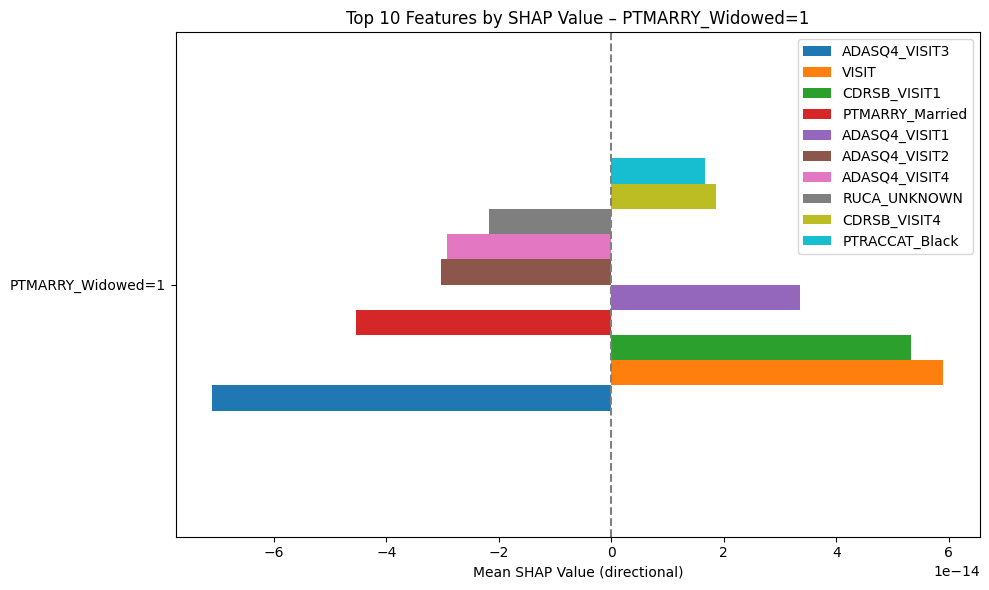

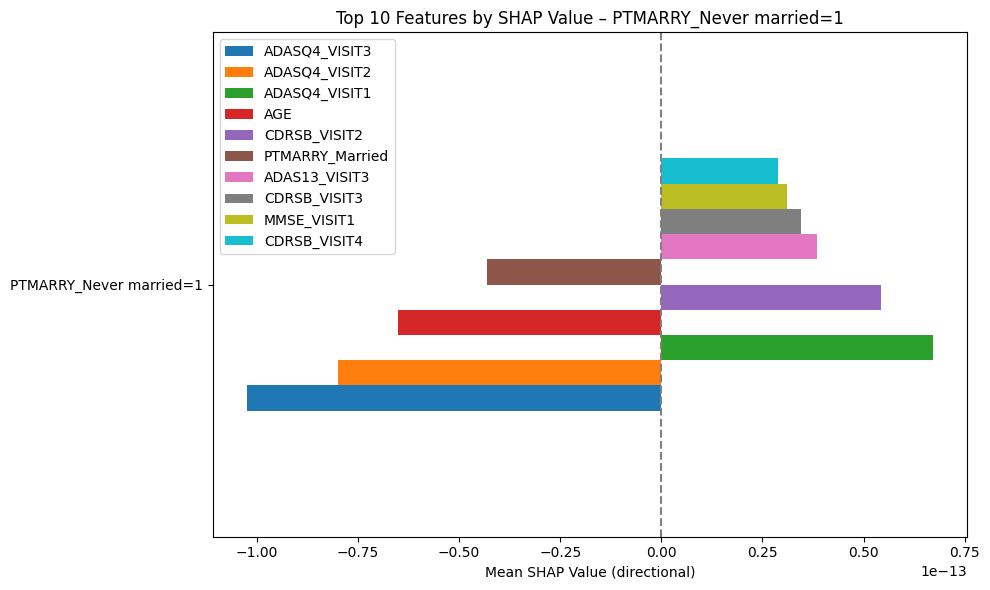

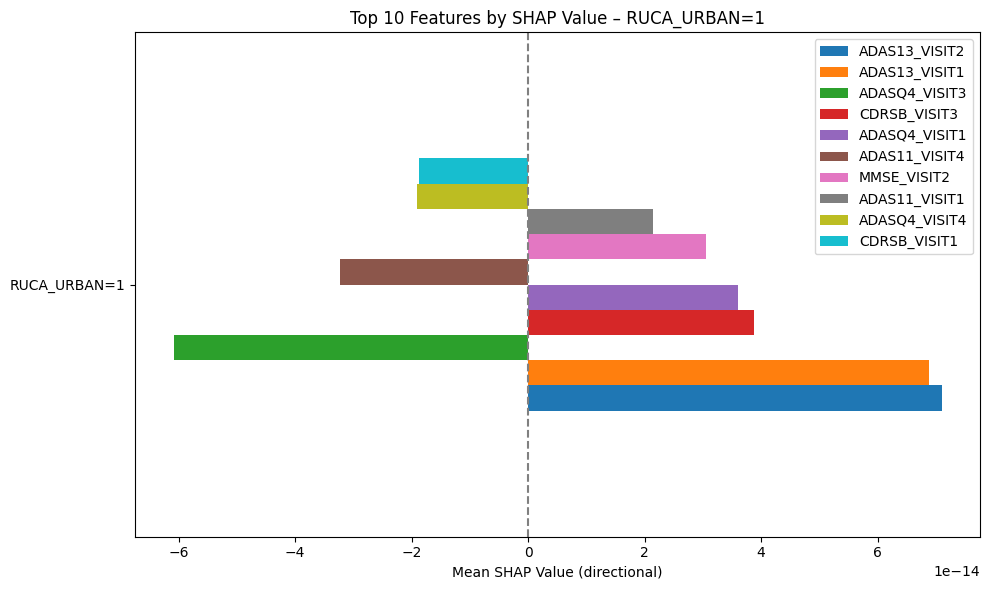

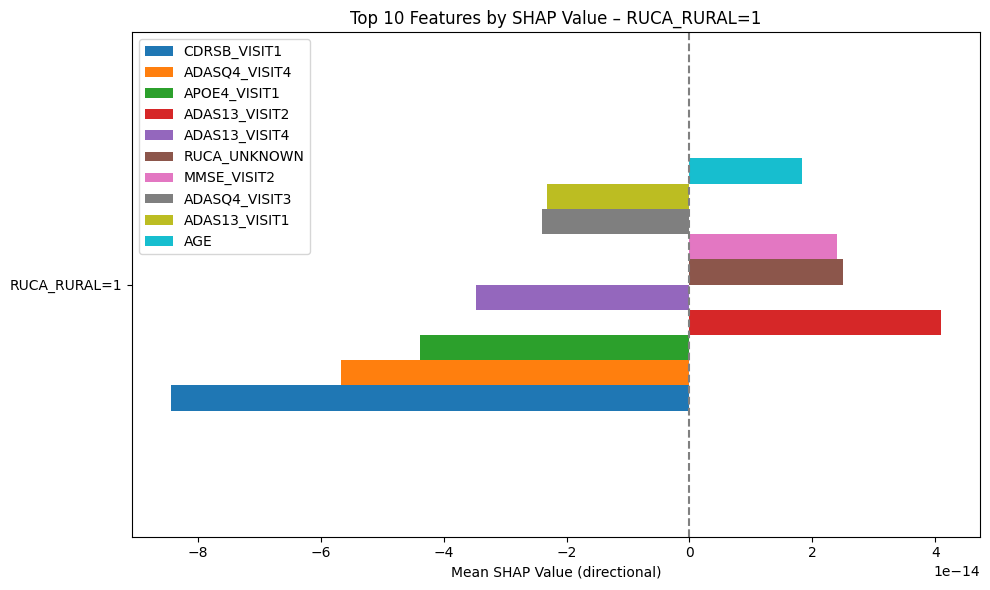

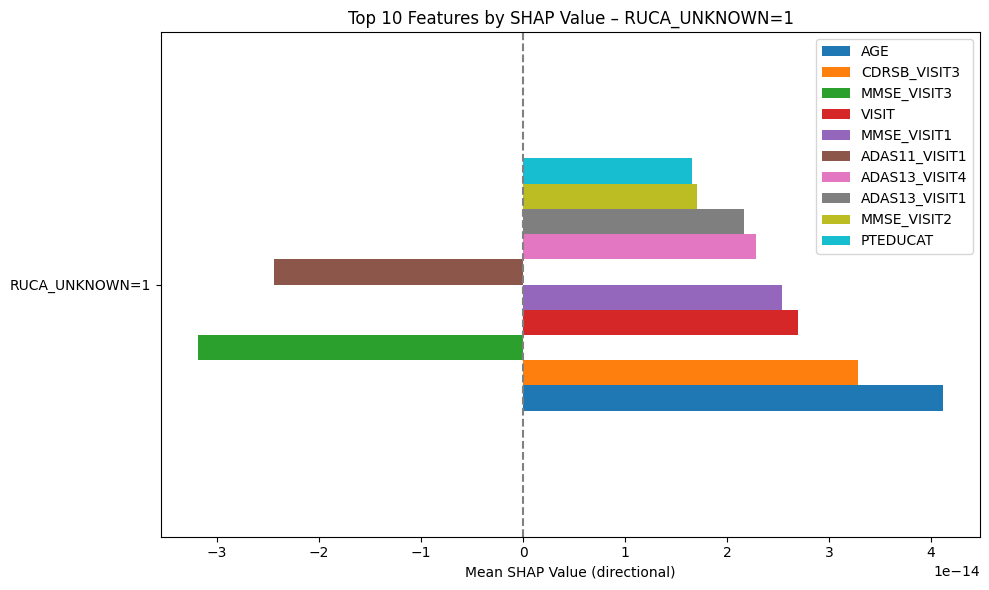

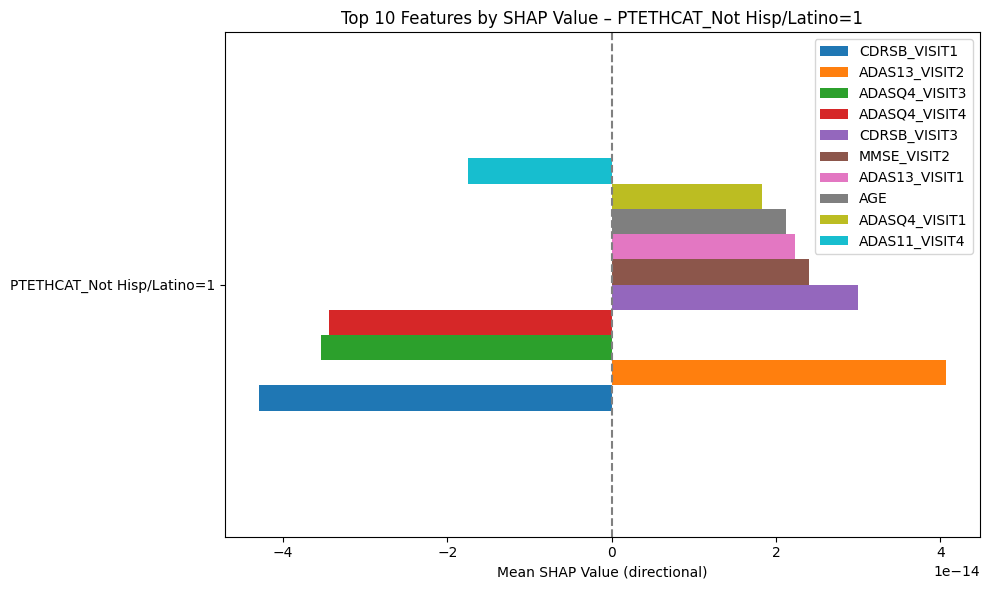

In [60]:
for group_var, shap_dict in grouped_shap_data.items():
    for label, shap_vals in shap_dict.items():
        shap_df = pd.DataFrame({label: shap_vals}, index=feature_cols)
        top_features = shap_df[label].abs().sort_values(ascending=False).head(10).index
        shap_df_top = shap_df.loc[top_features]

        if shap_df_top.empty:
            print(f"⚠️ No SHAP values to plot for {label} (empty top features)")
            continue

        ax = shap_df_top.T.plot(kind='barh', figsize=(10, 6))
        plt.axvline(0, color='gray', linestyle='--')
        plt.title(f"Top 10 Features by SHAP Value – {label}")
        plt.xlabel("Mean SHAP Value (directional)")
        plt.tight_layout()

        # Clean filename
        safe_label = label.replace(" ", "_").replace("≤", "le").replace("/", "_").replace("<", "").replace(">", "")
        plt.savefig(f"shap_grouped_{safe_label}.png")
        plt.show()  # Ensures plot shows up after saving


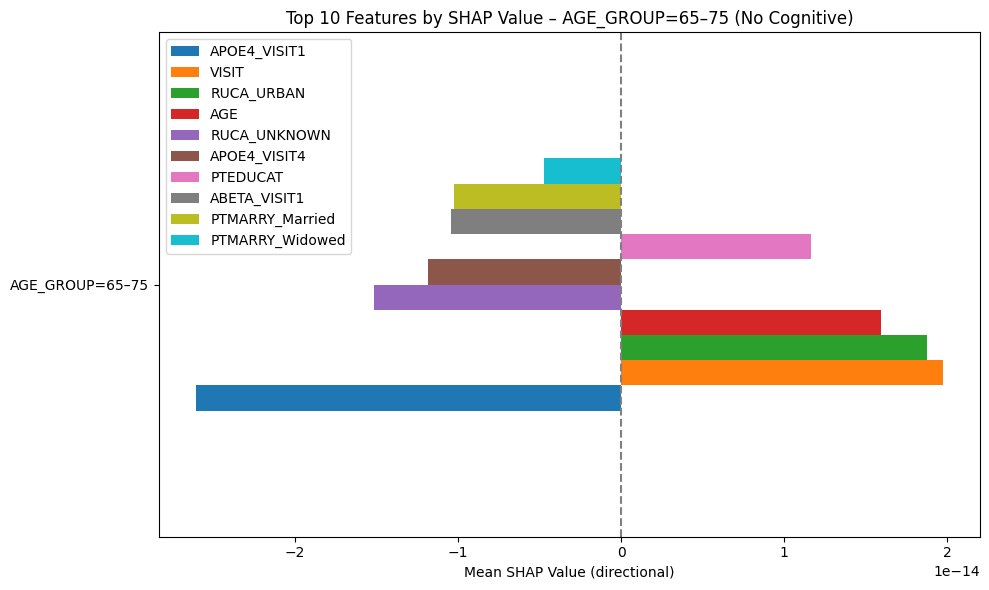

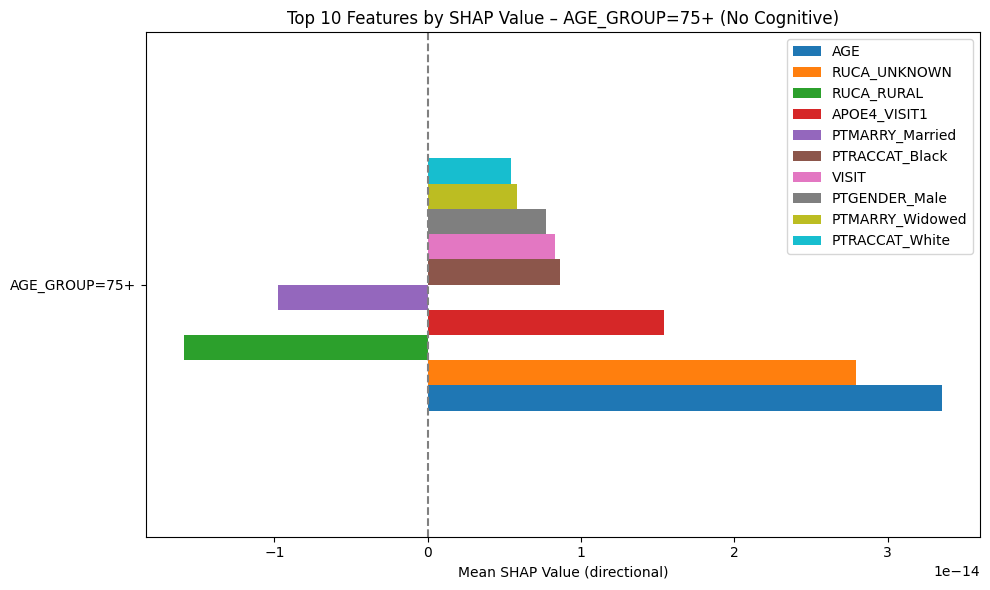

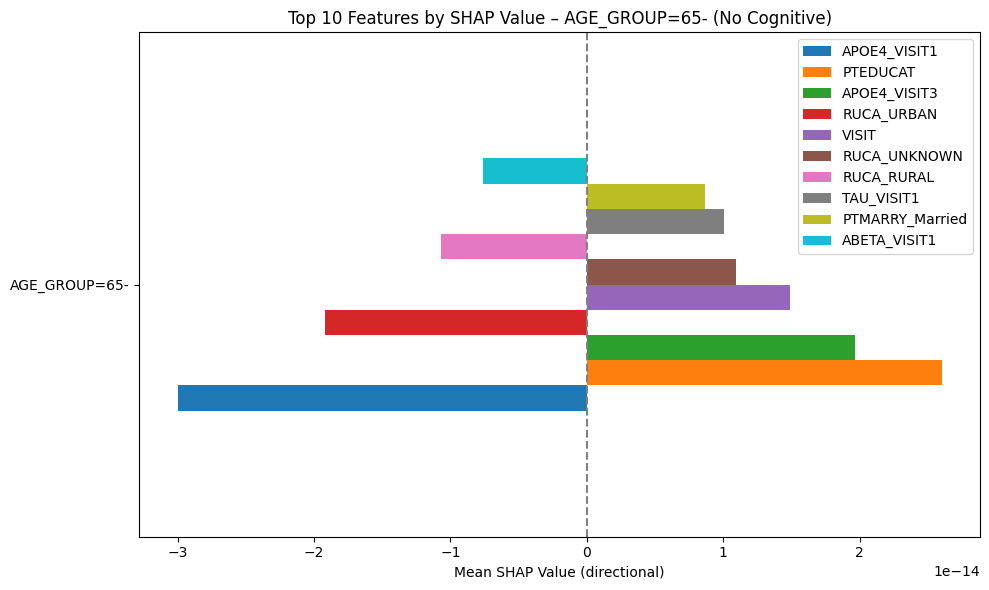

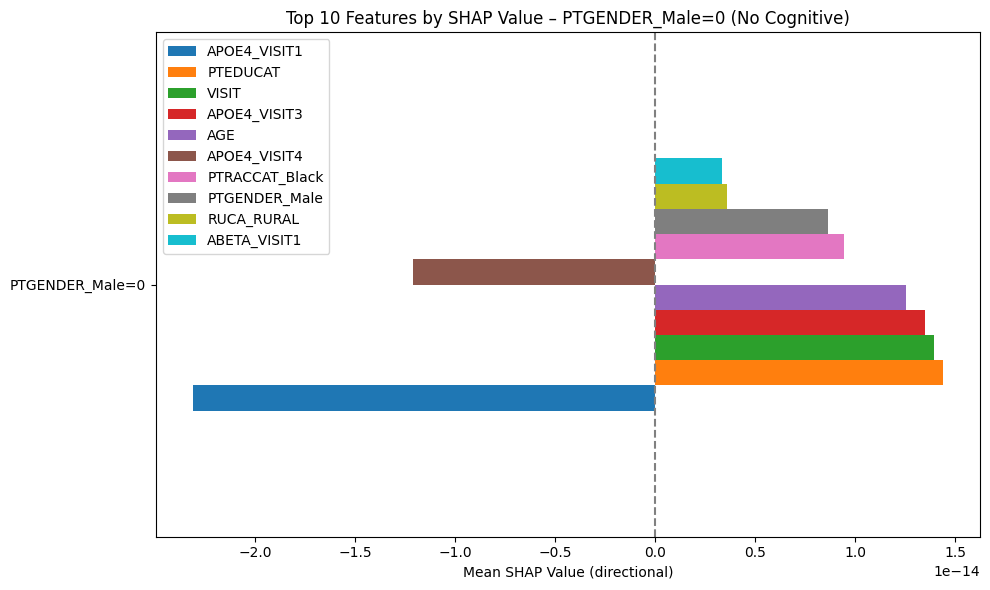

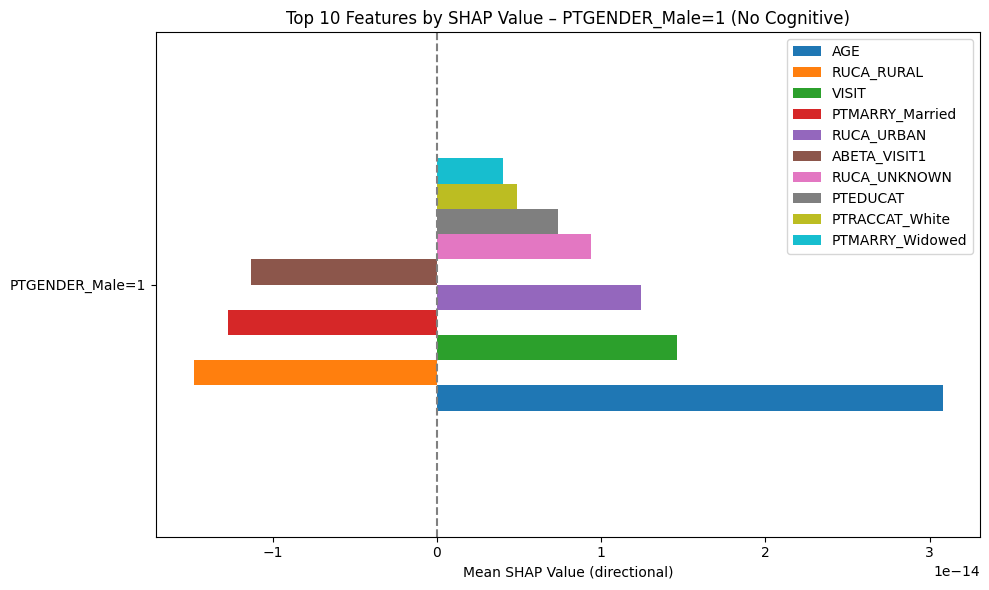

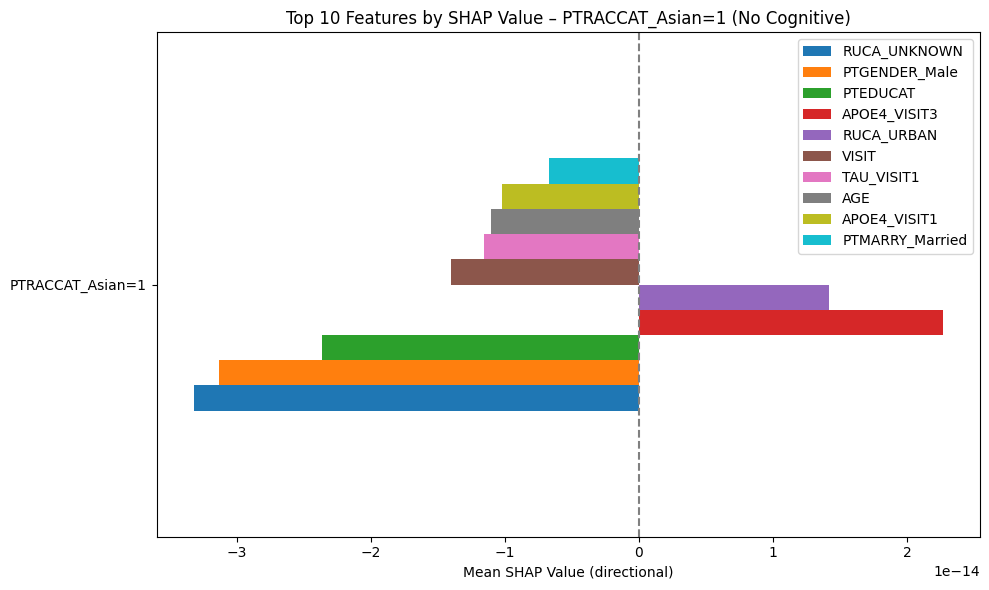

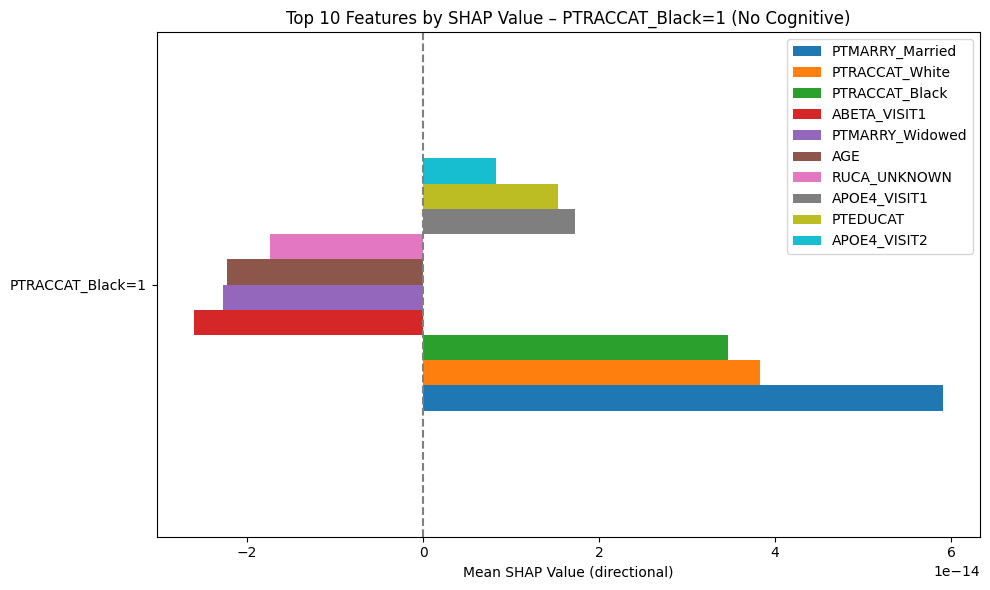

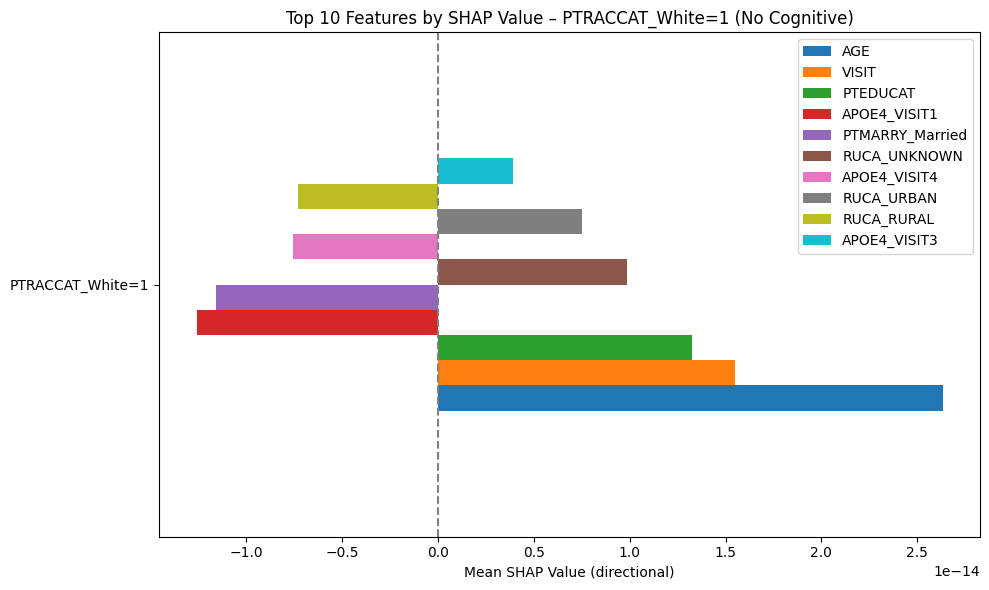

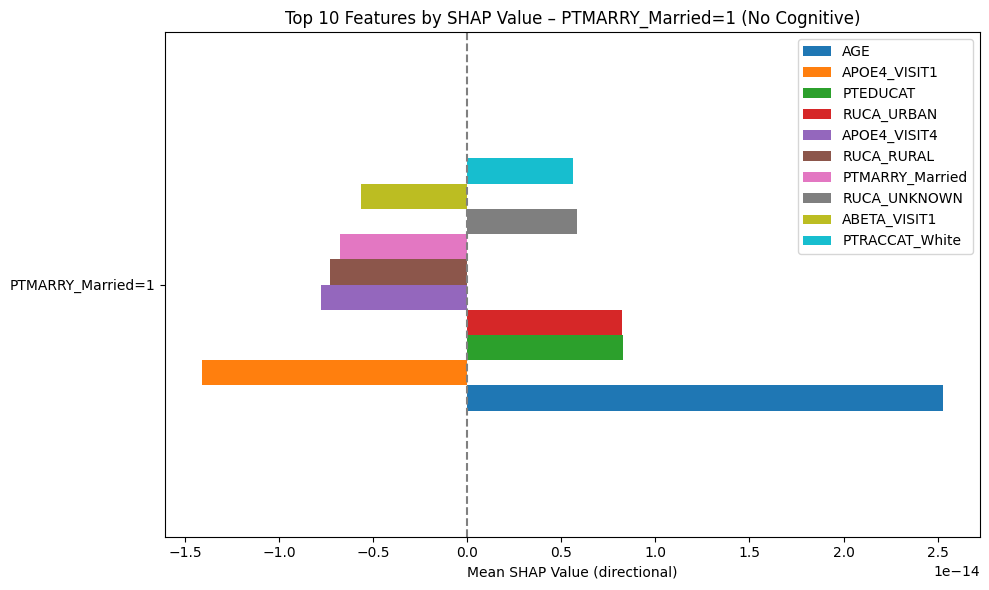

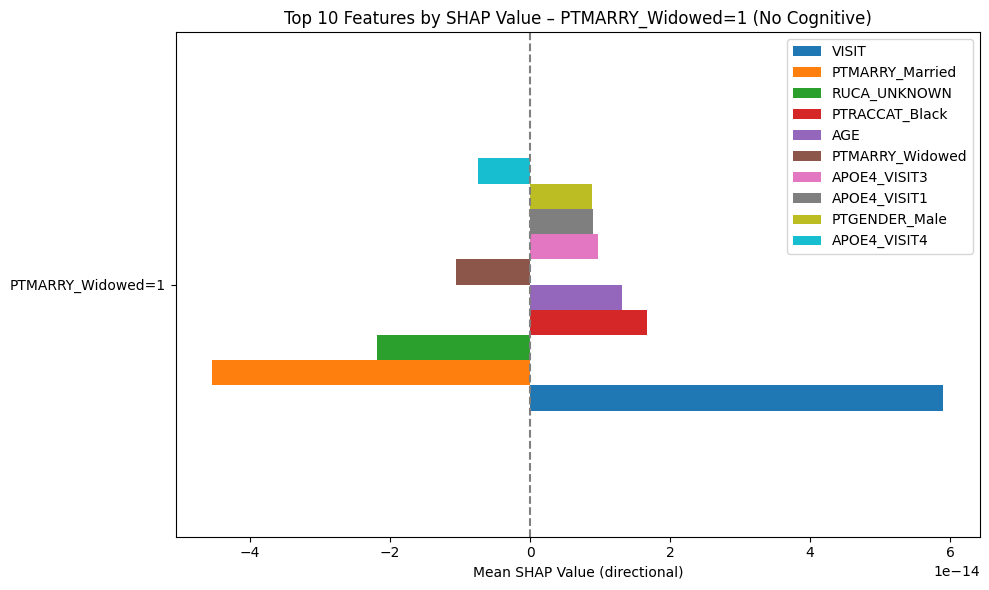

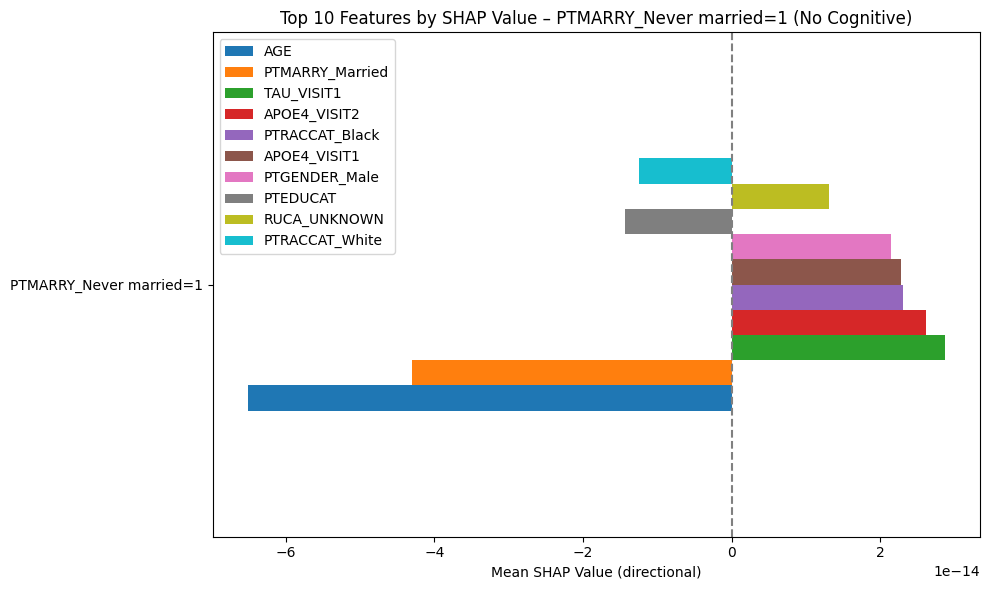

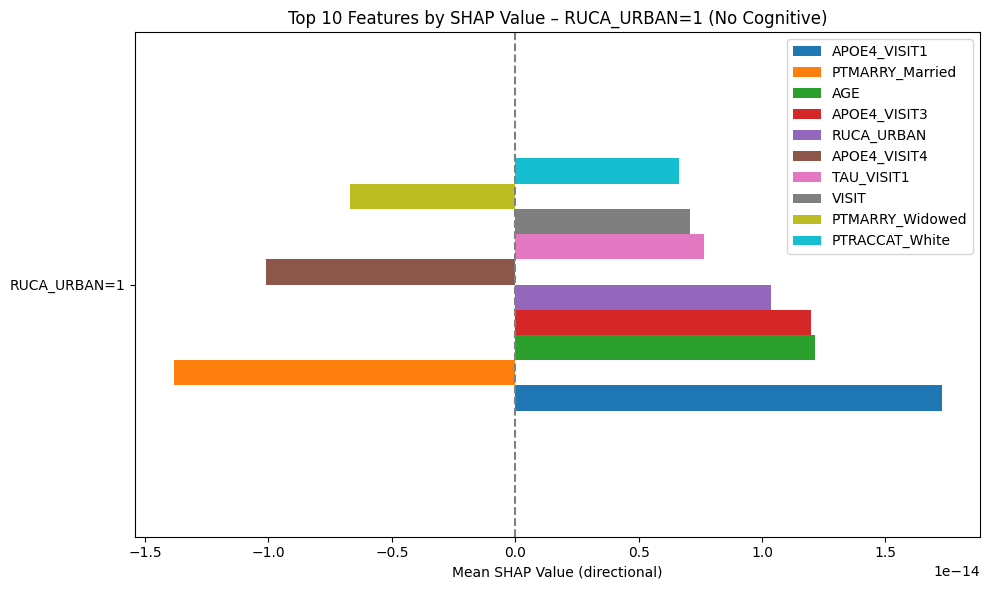

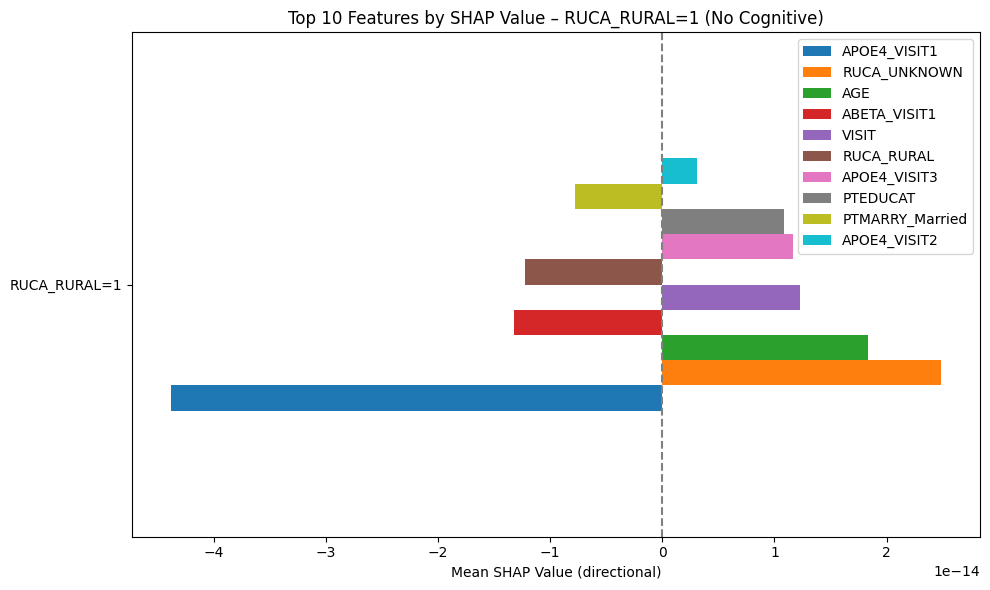

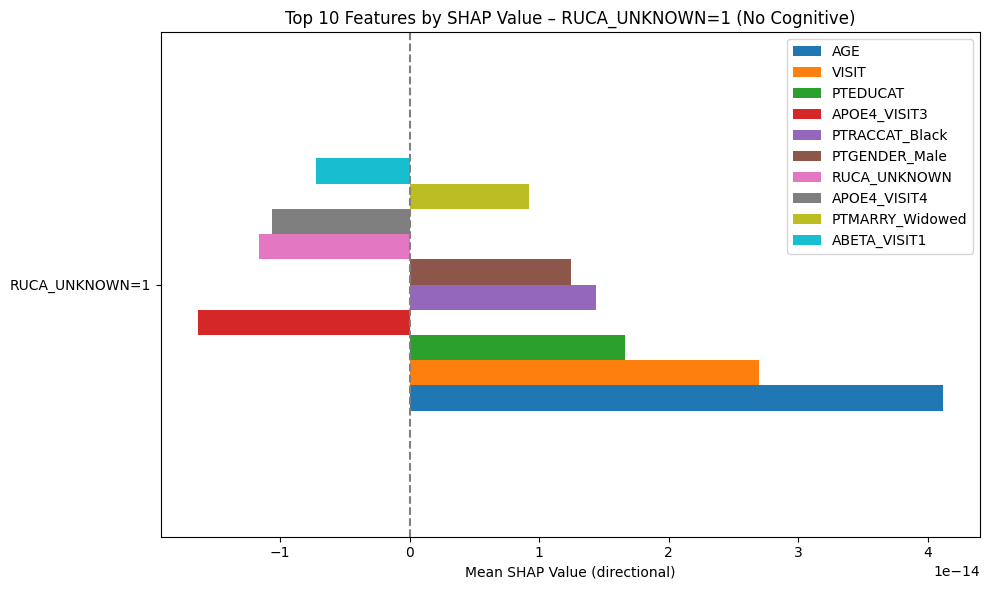

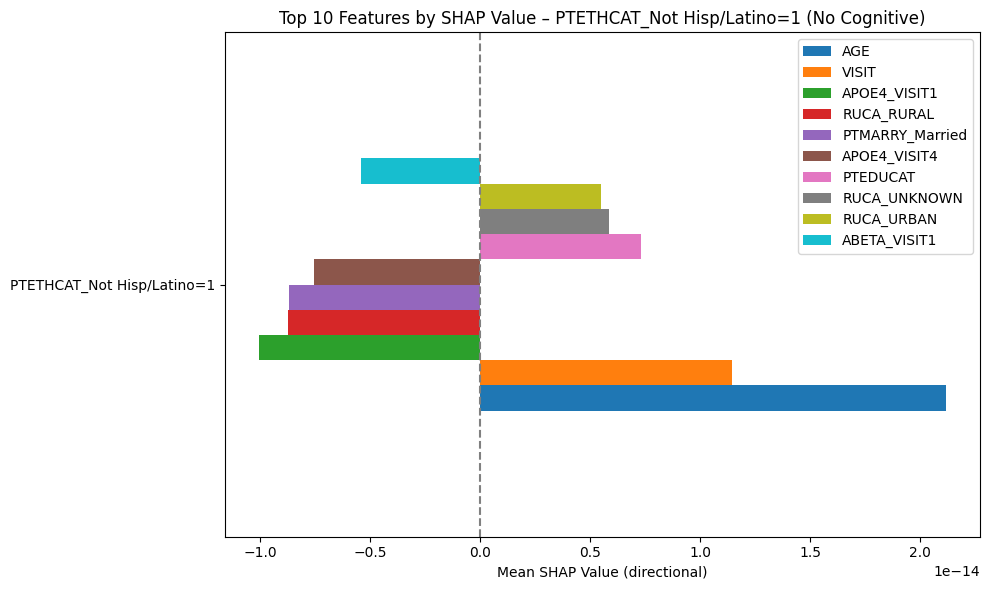

In [61]:
# === Cognitive base names ===
cognitive_base = ['CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE']

# === Modified plotting loop excluding cognitive features ===
for group_var, shap_dict in grouped_shap_data.items():
    for label, shap_vals in shap_dict.items():
        # Filter feature names that are NOT cognitive
        non_cog_features = [f for f in feature_cols if not any(cog in f for cog in cognitive_base)]

        # Create shap_df with non-cognitive features only
        shap_df = pd.DataFrame({label: shap_vals}, index=feature_cols)
        shap_df = shap_df.loc[non_cog_features]

        # Pick top 10 features by absolute value
        top_features = shap_df[label].abs().sort_values(ascending=False).head(10).index
        shap_df_top = shap_df.loc[top_features]

        if shap_df_top.empty:
            print(f"⚠️ No SHAP values to plot for {label} (empty top features)")
            continue

        # Bar plot (directional)
        ax = shap_df_top.T.plot(kind='barh', figsize=(10, 6))
        plt.axvline(0, color='gray', linestyle='--')
        plt.title(f"Top 10 Features by SHAP Value – {label} (No Cognitive)")
        plt.xlabel("Mean SHAP Value (directional)")
        plt.tight_layout()

        # Clean filename
        safe_label = label.replace(" ", "_").replace("≤", "le").replace("/", "_").replace("<", "").replace(">", "")
        plt.savefig(f"shap_grouped_nocog_{safe_label}.png")
        plt.show()


In [62]:
def get_feature_names_from_pipeline(pipeline, input_features):
    output_features = []
    for name, step in pipeline.named_steps.items():
        if hasattr(step, 'get_feature_names_out'):
            try:
                names = step.get_feature_names_out(input_features)
            except:
                names = step.get_feature_names_out()
        else:
            names = input_features  # passthrough or unknown
        input_features = names  # update input for next step
        output_features = names
    return output_features


📊 Processing: PTGENDER_Male
📊 Processing: PTRACCAT_Asian
📊 Processing: PTRACCAT_Black
📊 Processing: PTRACCAT_Hawaiian/Other PI
📊 Processing: PTRACCAT_More than one
📊 Processing: PTRACCAT_Unknown
📊 Processing: PTRACCAT_White
📊 Processing: EDU_GROUP
✅ Saved: shap_pteducat_by_subgroup.csv


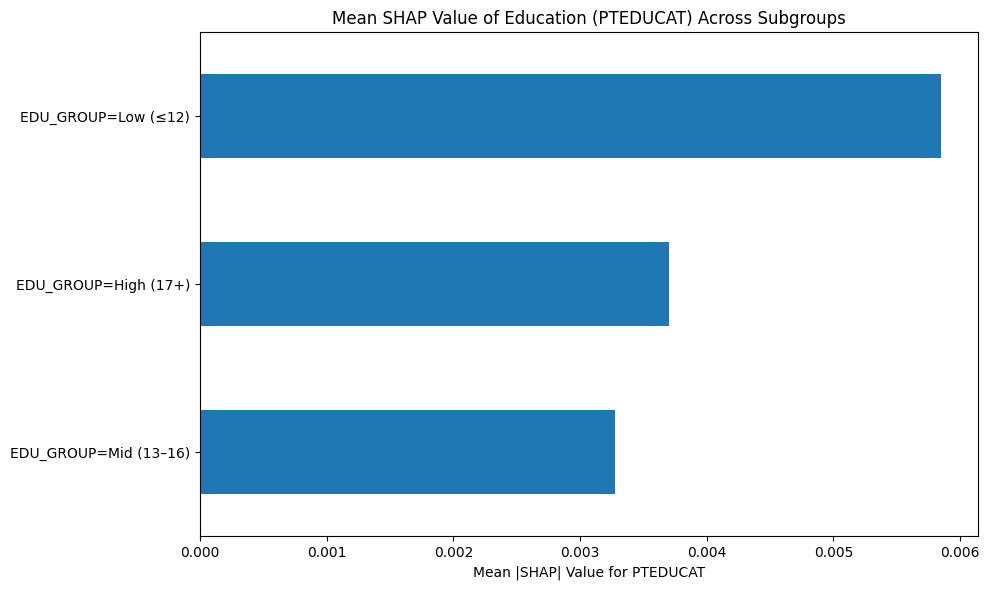

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define subgroup variables
subgroup_vars = ['PTGENDER_Male'] + [col for col in X_test_raw.columns if col.startswith("PTRACCAT_")]

# Add binned education groups
X_test_with_group = X_test_raw.copy()
X_test_with_group['EDU_GROUP'] = pd.cut(
    X_test_with_group['PTEDUCAT'],
    bins=[0, 12, 16, 25],
    labels=['Low (≤12)', 'Mid (13–16)', 'High (17+)']
)
subgroup_vars += ['EDU_GROUP']

# Store SHAP values of PTEDUCAT per subgroup
edu_shap_by_group = {}

for var in subgroup_vars:
    print(f"📊 Processing: {var}")
    values = X_test_with_group[var].dropna().unique()

    for val in values:
        if isinstance(val, (str, int)):
            mask = X_test_with_group[var] == val
            label = f"{var}={val}"
        else:
            continue

        # Subset data
        subset_indices = X_test_with_group.loc[mask].index
        X_sub_raw = X_test_raw.loc[subset_indices, feature_cols]
        if X_sub_raw.shape[0] < 30:
            print(f"⏭️ Skipping {label} (too few samples: {X_sub_raw.shape[0]})")
            continue

        # Transform input
        X_transformed = pipeline.transform(X_sub_raw)

        # SHAP values from TreeExplainer
        shap_vals = explainer.shap_values(X_transformed)

        # Aggregate SHAP values over samples and classes
        shap_combined = np.abs(shap_vals).mean(axis=(0, 2))  # shape: (n_features,)
        shap_combined = shap_combined.flatten()

        current_feature_cols = X_sub_raw.columns.tolist()

        if len(current_feature_cols) != len(shap_combined):
            print(f"❌ Mismatch for {label}: Features({len(current_feature_cols)}) vs SHAP({len(shap_combined)})")
            continue

        shap_df = pd.DataFrame({
            'Feature': current_feature_cols,
            'MeanSHAP': shap_combined
        }).set_index('Feature')

        # Store SHAP value for PTEDUCAT
        if 'PTEDUCAT' in shap_df.index:
            edu_value = shap_df.loc['PTEDUCAT', 'MeanSHAP']
            edu_shap_by_group[label] = edu_value
        else:
            print(f"⚠️ PTEDUCAT not found for {label}")

# Create summary series
edu_shap_df = pd.Series(edu_shap_by_group).sort_values(ascending=True)

# Save to CSV
edu_shap_df.to_csv("shap_pteducat_by_subgroup.csv")
print("✅ Saved: shap_pteducat_by_subgroup.csv")

# Plot results
if not edu_shap_df.empty and np.issubdtype(edu_shap_df.dtype, np.number):
    edu_shap_df.plot(kind='barh', figsize=(10, 6))
    plt.title("Mean SHAP Value of Education (PTEDUCAT) Across Subgroups")
    plt.xlabel("Mean |SHAP| Value for PTEDUCAT")
    plt.tight_layout()
    plt.savefig("shap_pteducat_by_subgroup.png")
    plt.show()
else:
    print("⚠️ Nothing to plot: SHAP values are empty or non-numeric.")



In [64]:
print(len(feature_cols))
print(feature_cols[:10])


46
['PTGENDER_Male', 'PTETHCAT_Not Hisp/Latino', 'PTETHCAT_Unknown', 'PTRACCAT_Asian', 'PTRACCAT_Black', 'PTRACCAT_Hawaiian/Other PI', 'PTRACCAT_More than one', 'PTRACCAT_Unknown', 'PTRACCAT_White', 'PTMARRY_Married']


In [65]:
import shap
import os
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(rf_model)
os.makedirs("shap_plots", exist_ok=True)

# === Plot SHAP summaries for PTGENDER_Male and PTEDUCAT subgroups ===
for group_var in ['PTGENDER_Male', 'PTEDUCAT']:
    if group_var not in X_test_raw.columns:
        continue
    for val in sorted(X_test_raw[group_var].dropna().unique()):
        mask = X_test_raw[group_var] == val
        X_sub = X_test_raw[mask].copy()
        if X_sub.shape[0] < 30:
            continue  # Skip small subgroups
        X_transformed = pipeline.transform(X_sub)
        shap_vals = explainer.shap_values(X_transformed)
        shap.summary_plot(shap_vals, X_transformed, feature_names=X_test_raw.columns, show=False)
        plt.title(f"SHAP Summary: {group_var} = {val}")
        plt.tight_layout()
        plt.savefig(f"shap_plots/shap_{group_var}_{val}.png")
        plt.close()

# === (Optional) Aggregate view: SHAP summaries by years of education ===
# You already handled this well, but we can clean and combine both


<Figure size 640x480 with 0 Axes>

In [66]:
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score

fair_metrics = {}

metric_frame = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'selection_rate': selection_rate,
    },
    y_true=y_test,
    y_pred=rf_model.predict(X_test),
    sensitive_features=X_test_raw[group_var]
    )


fair_metrics[group_var] = metric_frame.by_group

fairness_summary = pd.concat(fair_metrics).reset_index()
fairness_summary.rename(columns={'level_0': 'group_variable', 'level_1': 'group_value'}, inplace=True)
print(fairness_summary)

   group_variable  PTEDUCAT  accuracy  selection_rate
0        PTEDUCAT         6  1.000000        1.000000
1        PTEDUCAT         7  1.000000        0.000000
2        PTEDUCAT         8  1.000000        0.461538
3        PTEDUCAT         9  0.666667        0.333333
4        PTEDUCAT        10  0.944444        0.333333
5        PTEDUCAT        11  0.888889        0.666667
6        PTEDUCAT        12  0.849398        0.325301
7        PTEDUCAT        13  0.812500        0.229167
8        PTEDUCAT        14  0.901961        0.202614
9        PTEDUCAT        15  0.841270        0.206349
10       PTEDUCAT        16  0.892128        0.233236
11       PTEDUCAT        17  0.945455        0.109091
12       PTEDUCAT        18  0.880952        0.176871
13       PTEDUCAT        19  0.895833        0.125000
14       PTEDUCAT        20  0.900000        0.157143


In [67]:
# Automatically detect variables by visit
visit_data = {}

for visit in range(1, 5):
    visit_key = f"VISIT{visit}"
    target = f"DX_VISIT{visit}"
    
    predictors = []
    for col in df.columns:
        if col.endswith(f"_VISIT{visit}") and col != target:
            predictors.append(col)
    
    if target in df.columns and predictors:
        visit_data[visit_key] = {"predictors": predictors, "target": target}



=== Running Config: A_AllFeatures ===

=== Running Config: B_NoCognitive ===

=== Running Config: C_NoSiteEdu ===

=== Running Config: D_NoCognitive_NoSiteEdu ===
                    Config        Model  Accuracy  Precision  Recall  F1 Score
0            A_AllFeatures  HybridModel    0.8860     0.8860  0.8778    0.8815
1            B_NoCognitive  HybridModel    0.4483     0.4327  0.4119    0.4066
2              C_NoSiteEdu  HybridModel    0.8856     0.8845  0.8807    0.8821
3  D_NoCognitive_NoSiteEdu  HybridModel    0.4489     0.4126  0.4085    0.3848


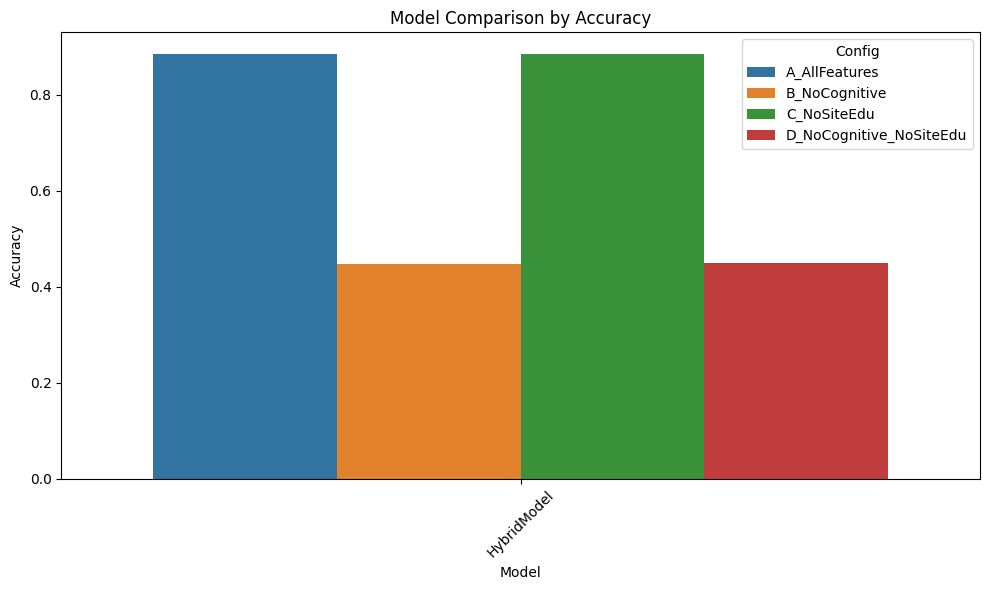

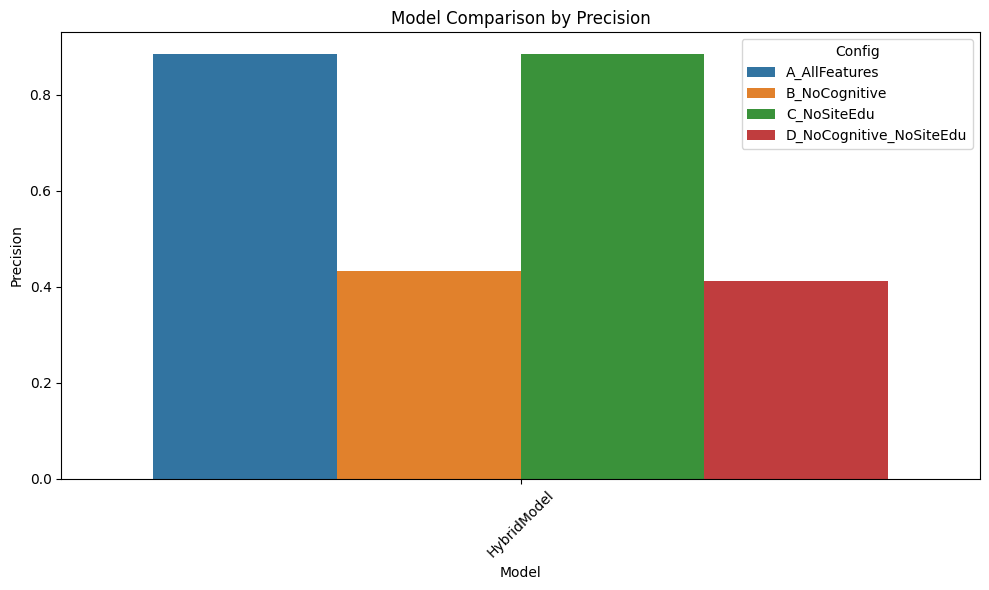

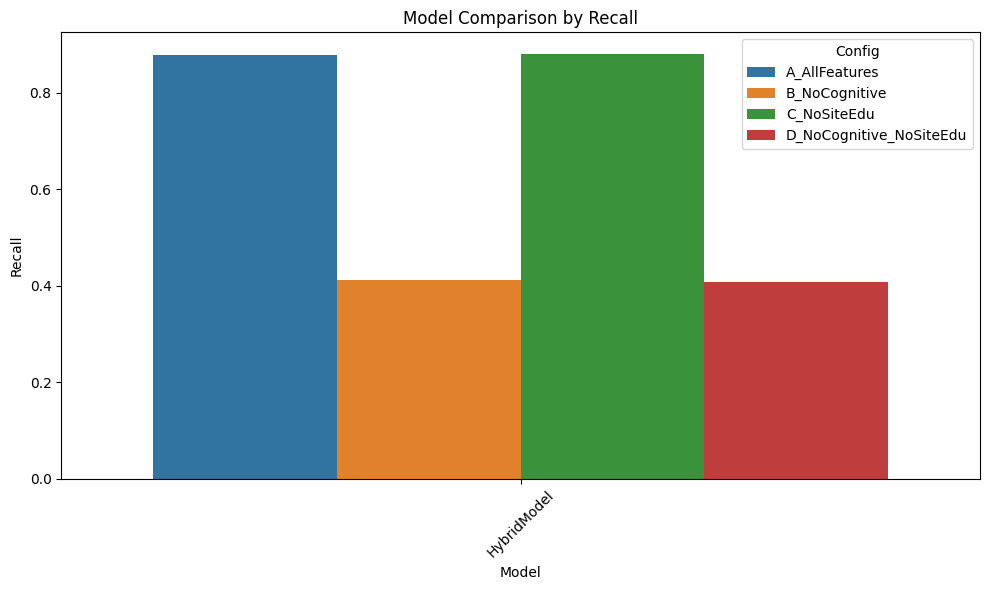

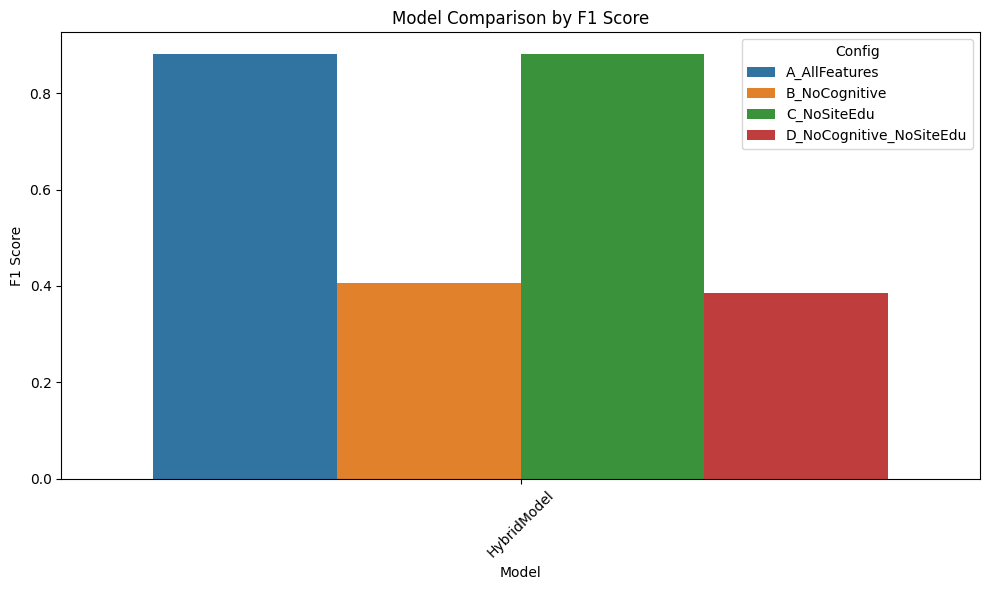

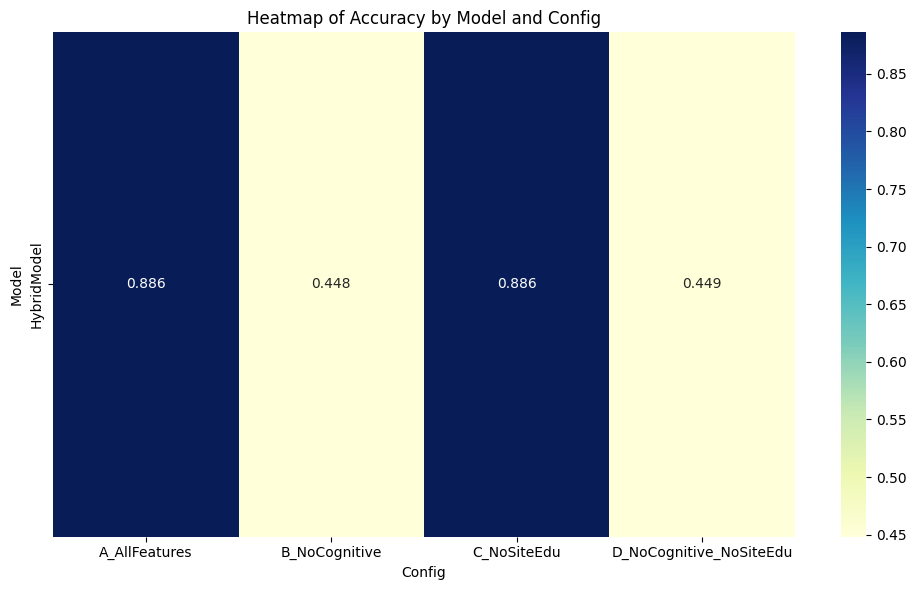

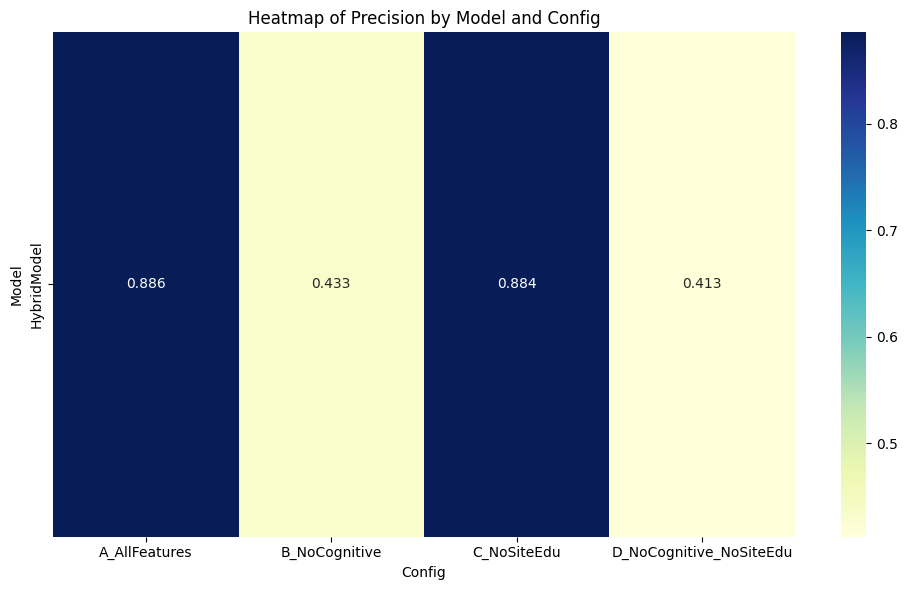

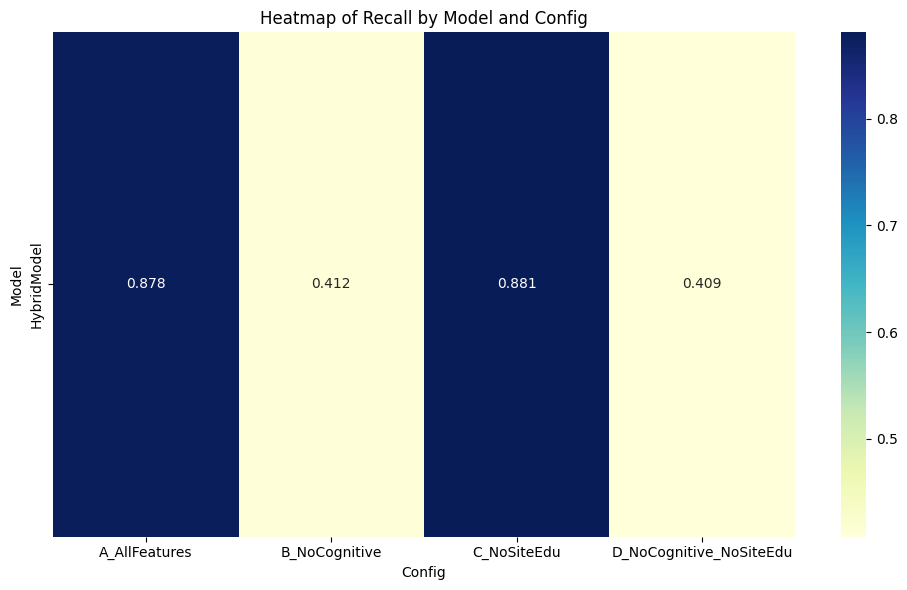

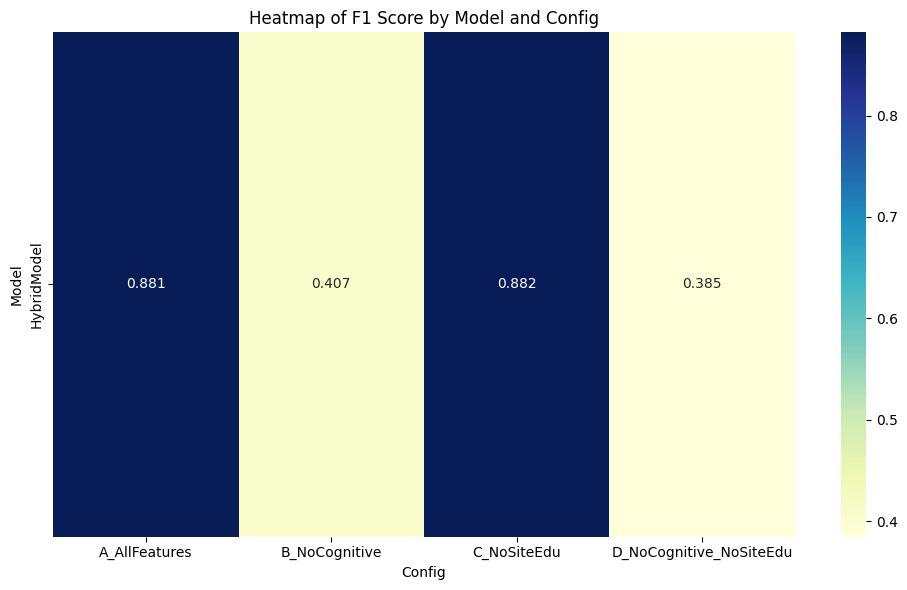

In [68]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# === Define base features ===
biomarkers = ['APOE4', 'ABETA', 'TAU', 'PTAU']
cognitive_base = ['CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE']
demographic_predictors = ['PTEDUCAT', 'RUCA_URBAN', 'RUCA_RURAL', 'RUCA_UNKNOWN']

# === Model Definitions ===
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "NaiveBayes": GaussianNB()
}

# === Configurations ===
configs = {
    "A_AllFeatures": {"exclude_cognitive": False, "exclude_demo": False},
    "B_NoCognitive": {"exclude_cognitive": True, "exclude_demo": False},
    "C_NoSiteEdu": {"exclude_cognitive": False, "exclude_demo": True},
    "D_NoCognitive_NoSiteEdu": {"exclude_cognitive": True, "exclude_demo": True}
}

config_results = {config_name: {
    "HybridModel": {"accuracy": [], "precision": [], "recall": [], "f1_score": []}
} for config_name in configs.keys()}

# === Run experiments ===
for config_name, config in configs.items():
    print(f"\n=== Running Config: {config_name} ===")

    for visit in range(1, 5):
        visit_key = f"VISIT{visit}"
        target = f"DX_VISIT{visit}"

        # Generate predictors dynamically for this visit
        bio = [f"{v}_VISIT{visit}" for v in biomarkers if f"{v}_VISIT{visit}" in df.columns]
        cog = [f"{v}_VISIT{visit}" for v in cognitive_base if f"{v}_VISIT{visit}" in df.columns]
        all_predictors = bio + cog + demographic_predictors

        # Drop if target doesn't exist
        if target not in df.columns:
            continue

        # Filter predictors
        predictors = []
        for p in all_predictors:
            is_cog = any(p.startswith(f"{c}_VISIT") for c in cognitive_base)
            is_demo = p in demographic_predictors
            if config["exclude_cognitive"] and is_cog:
                continue
            if config["exclude_demo"] and is_demo:
                continue
            predictors.append(p)

        # Prepare data
        data = df[predictors + [target]].copy()
        data.dropna(subset=[target], inplace=True)

        if data.empty or len(predictors) == 0:
            print(f"⚠️ Skipping {config_name} {visit_key} (empty dataset or no predictors)")
            continue

        # Encode categorical variables if needed
        for col in demographic_predictors:
            if col in data.columns:
                data[col] = data[col].astype("category").cat.codes

        # Process X and y
        imputer = SimpleImputer(strategy="median")
        X = imputer.fit_transform(data[predictors])
        X = StandardScaler().fit_transform(X)
        y = LabelEncoder().fit_transform(data[target].astype(str))

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )

        # Train Hybrid
        rf_model = models["RandomForest"]
        gb_model = models["GradientBoosting"]
        nb_model = models["NaiveBayes"]

        rf_model.fit(X_train, y_train)
        gb_model.fit(X_train, y_train)
        nb_model.fit(X_train, y_train)

        rf_preds = rf_model.predict(X_test)
        gb_preds = gb_model.predict(X_test)
        nb_preds = nb_model.predict(X_test)

        all_preds = np.vstack([rf_preds, gb_preds, nb_preds])
        final_preds, _ = mode(all_preds, axis=0, keepdims=False)

        acc = accuracy_score(y_test, final_preds)
        report = classification_report(y_test, final_preds, output_dict=True, zero_division=0)

        config_results[config_name]["HybridModel"]["accuracy"].append(acc)
        config_results[config_name]["HybridModel"]["precision"].append(report["macro avg"]["precision"])
        config_results[config_name]["HybridModel"]["recall"].append(report["macro avg"]["recall"])
        config_results[config_name]["HybridModel"]["f1_score"].append(report["macro avg"]["f1-score"])

# === Aggregate Results ===
summary_rows = []
for config_name, models_metrics in config_results.items():
    for model_name, metrics in models_metrics.items():
        summary_rows.append({
            "Config": config_name,
            "Model": model_name,
            "Accuracy": np.mean(metrics["accuracy"]),
            "Precision": np.mean(metrics["precision"]),
            "Recall": np.mean(metrics["recall"]),
            "F1 Score": np.mean(metrics["f1_score"])
        })

summary_df = pd.DataFrame(summary_rows)
print(summary_df.round(4))

# === Save & Plot ===
summary_df.to_csv("model_performance_comparison.csv", index=False)

metrics_to_plot = ["Accuracy", "Precision", "Recall", "F1 Score"]
for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=summary_df, x="Model", y=metric, hue="Config")
    plt.title(f"Model Comparison by {metric}")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

pivot_df = summary_df.pivot(index="Model", columns="Config")
for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_df[metric], annot=True, fmt=".3f", cmap="YlGnBu")
    plt.title(f"Heatmap of {metric} by Model and Config")
    plt.ylabel("Model")
    plt.xlabel("Config")
    plt.tight_layout()
    plt.show()


In [69]:
import pandas as pd
import numpy as np
from collections import defaultdict
import os

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import mode
import joblib

# === Load original dataset ===
df = pd.read_csv("DATA.csv")

# === Define feature groups ===
demographics = [
    'PTGENDER_Male', 'PTETHCAT_Not Hisp/Latino', 'PTETHCAT_Unknown',
    'PTRACCAT_Asian', 'PTRACCAT_Black', 'PTRACCAT_Hawaiian/Other PI',
    'PTRACCAT_More than one', 'PTRACCAT_Unknown', 'PTRACCAT_White',
    'PTMARRY_Married', 'PTMARRY_Widowed', 'PTMARRY_Never married', 'PTMARRY_Unknown'
]
rurality= ['RUCA_URBAN','RUCA_RURAL','RUCA_UNKNOWN']
biomarkers = ['APOE4', 'ABETA', 'TAU', 'PTAU']
cognitive = ['CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE']
other = ['PTEDUCAT', 'AGE']

# === LOCF for biomarkers and cognitive variables ===
all_vars = biomarkers + cognitive
var_groups = defaultdict(list)
for var in all_vars:
    for v in range(1, 5):
        col = f"{var}_VISIT{v}"
        if col in df.columns:
            var_groups[var].append(col)

for base, cols in var_groups.items():
    sorted_cols = sorted(cols, key=lambda x: int(x.split("VISIT")[1]))
    df[sorted_cols] = df[sorted_cols].apply(lambda row: row.ffill(axis=0), axis=1)

# === Build visit-agnostic dataset ===
all_visit_data = []
for visit in range(1, 5):
    visit_bio = [f"{v}_VISIT{visit}" for v in biomarkers if f"{v}_VISIT{visit}" in df.columns]
    visit_cog = [f"{v}_VISIT{visit}" for v in cognitive if f"{v}_VISIT{visit}" in df.columns]
    target = f"DX_VISIT{visit}"
    if target not in df.columns:
        continue

    predictors = demographics + rurality + visit_bio + visit_cog + other
    subset = df[predictors + [target]].copy()
    subset.dropna(subset=[target], inplace=True)
    subset.rename(columns={target: "DX"}, inplace=True)
    subset.columns = [col.replace(f"_VISIT{visit}", "") if f"_VISIT{visit}" in col else col for col in subset.columns]
    all_visit_data.append(subset)

combined_df = pd.concat(all_visit_data, axis=0)

# === Encode labels ===
le = LabelEncoder()
combined_df["DX_encoded"] = le.fit_transform(combined_df["DX"].astype(str))
joblib.dump(le, "models/label_encoder_visit_agnostic.pkl")

# === Define features and target ===
X_raw = combined_df.drop(columns=["DX", "DX_encoded"])
y = combined_df["DX_encoded"]

# === Train-test split ===
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, stratify=y, test_size=0.2, random_state=42)

# === Preprocessing pipeline ===
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k=50))
])
pipeline.fit(X_train_raw, y_train)
X_train = pipeline.transform(X_train_raw)
X_test = pipeline.transform(X_test_raw)
joblib.dump(pipeline, "models/pipeline_visit_agnostic.pkl")

# === Define models ===
models = {
    "LogisticRegression": LogisticRegression(max_iter=5000, class_weight='balanced'),
    "RandomForest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "SVC": SVC(probability=True, class_weight='balanced', random_state=42),
    "NaiveBayes": GaussianNB()
}

# === Train and evaluate ===
model_results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_train_np = np.array(y_train)

for name, model in models.items():
    f1_scores = []
    for train_idx, val_idx in skf.split(X_train, y_train_np):
        model.fit(X_train[train_idx], y_train_np[train_idx])
        y_val_pred = model.predict(X_train[val_idx])
        report = classification_report(y_train_np[val_idx], y_val_pred, output_dict=True, zero_division=0)
        f1_scores.append(report["macro avg"]["f1-score"])

    model.fit(X_train, y_train_np)
    joblib.dump(model, f"models/{name}_visit_agnostic.pkl")
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    model_results[name] = {
        "cv_f1_mean": np.mean(f1_scores),
        "accuracy": acc,
        "precision": report["macro avg"]["precision"],
        "recall": report["macro avg"]["recall"],
        "f1_score": report["macro avg"]["f1-score"],
        "confusion_matrix": cm
    }

# === Hybrid voting model ===
pred_rf = models["RandomForest"].predict(X_test)
pred_gb = models["GradientBoosting"].predict(X_test)
pred_nb = models["NaiveBayes"].predict(X_test)

hybrid_preds = mode(np.vstack([pred_rf, pred_gb, pred_nb]), axis=0).mode.ravel()
hybrid_report = classification_report(y_test, hybrid_preds, output_dict=True, zero_division=0)
model_results["HybridModel"] = {
    "accuracy": accuracy_score(y_test, hybrid_preds),
    "precision": hybrid_report["macro avg"]["precision"],
    "recall": hybrid_report["macro avg"]["recall"],
    "f1_score": hybrid_report["macro avg"]["f1-score"],
    "confusion_matrix": confusion_matrix(y_test, hybrid_preds)
}

joblib.dump((models["RandomForest"], models["GradientBoosting"], models["NaiveBayes"]),
            "models/hybrid_models_visit_agnostic.pkl")

# === Print summary ===
summary_df = pd.DataFrame({
    name: {
        "CV F1": f"{res.get('cv_f1_mean', 0):.4f}",
        "Test Acc": f"{res['accuracy']:.4f}",
        "Precision": f"{res['precision']:.4f}",
        "Recall": f"{res['recall']:.4f}",
        "F1 Score": f"{res['f1_score']:.4f}"
    }
    for name, res in model_results.items()
}).T.sort_values(by="F1 Score", ascending=False)

print(summary_df)


                     CV F1 Test Acc Precision  Recall F1 Score
HybridModel         0.0000   0.8978    0.8968  0.8984   0.8974
GradientBoosting    0.8963   0.8957    0.8983  0.8922   0.8948
RandomForest        0.8973   0.8936    0.8970  0.8897   0.8928
LogisticRegression  0.8752   0.8810    0.8754  0.8910   0.8816
SVC                 0.8585   0.8599    0.8568  0.8743   0.8615
NaiveBayes          0.3951   0.4251    0.6927  0.5260   0.3878


In [70]:

# === Define feature groups ===
demographics = [
    'PTGENDER_Male', 'PTETHCAT_Not Hisp/Latino', 'PTETHCAT_Unknown',
    'PTRACCAT_Asian', 'PTRACCAT_Black', 'PTRACCAT_Hawaiian/Other PI',
    'PTRACCAT_More than one', 'PTRACCAT_Unknown', 'PTRACCAT_White',
    'PTMARRY_Married', 'PTMARRY_Widowed', 'PTMARRY_Never married', 'PTMARRY_Unknown'
]
rurality= ['RUCA_URBAN','RUCA_RURAL','RUCA_UNKNOWN']
biomarkers = ['APOE4', 'ABETA', 'TAU', 'PTAU']
cognitive = ['CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE']
other = ['PTEDUCAT', 'AGE']

# === LOCF on biomarkers and cognitive predictors ===
all_vars = biomarkers + cognitive
var_groups = defaultdict(list)
for var in all_vars:
    for v in range(1, 5):
        col = f"{var}_VISIT{v}"
        if col in df.columns:
            var_groups[var].append(col)

for base, cols in var_groups.items():
    sorted_cols = sorted(cols, key=lambda x: int(x.split("VISIT")[1]))
    df[sorted_cols] = df[sorted_cols].T.ffill().T
# === Create visit-agnostic dataset ===
all_visit_data = []
for visit in range(1, 5):
    visit_bio = [f"{v}_VISIT{visit}" for v in biomarkers if f"{v}_VISIT{visit}" in df.columns]
    visit_cog = [f"{v}_VISIT{visit}" for v in cognitive if f"{v}_VISIT{visit}" in df.columns]
    target = f"DX_VISIT{visit}"
    if target not in df.columns:
        continue

    predictors = demographics + rurality + visit_bio + visit_cog + other
    subset = df[predictors + [target]].copy()
    subset.dropna(subset=[target], inplace=True)
    subset.rename(columns={target: "DX"}, inplace=True)
    subset.columns = [col.replace(f"_VISIT{visit}", "") if f"_VISIT{visit}" in col else col for col in subset.columns]
    all_visit_data.append(subset)

combined_df = pd.concat(all_visit_data, axis=0)

# === Encode target ===
le = LabelEncoder()
combined_df["DX_encoded"] = le.fit_transform(combined_df["DX"].astype(str))

# === Split ===
X_raw = combined_df.drop(columns=["DX", "DX_encoded"])
y = combined_df["DX_encoded"]
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, stratify=y, test_size=0.2, random_state=42)

# === Preprocessing pipeline ===
pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("select", SelectKBest(score_func=f_classif, k=50))
])
pipeline.fit(X_train_raw, y_train)
X_train = pipeline.transform(X_train_raw)
X_test = pipeline.transform(X_test_raw)

# === Models ===
models = {
    "RandomForest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "NaiveBayes": GaussianNB()
}
for name, model in models.items():
    model.fit(X_train, y_train)

# === Hybrid Voting Prediction ===
pred_rf = models["RandomForest"].predict(X_test)
pred_gb = models["GradientBoosting"].predict(X_test)
pred_nb = models["NaiveBayes"].predict(X_test)
hybrid_preds = mode(np.vstack([pred_rf, pred_gb, pred_nb]), axis=0).mode.ravel()

# === Prepare evaluation dataframe ===
y_test_decoded = le.inverse_transform(y_test)
y_pred_decoded = le.inverse_transform(hybrid_preds)
eval_df = X_test_raw.copy()
eval_df["true_label"] = y_test_decoded
eval_df["pred_label"] = y_pred_decoded
eval_df["AGE"] = df.loc[X_test_raw.index, "AGE"]
eval_df["PTEDUCAT"] = df.loc[X_test_raw.index, "PTEDUCAT"]
eval_df["PTGENDER_Male"] = df.loc[X_test_raw.index, "PTGENDER_Male"]
eval_df["SITE"] = df.loc[X_test_raw.index, rurality].idxmax(axis=1)
eval_df["PTMARRY_Married"] = df.loc[X_test_raw.index, "PTMARRY_Married"]

# === Binning ===
eval_df["AGE_GROUP"] = pd.cut(eval_df["AGE"], bins=[0, 65, 75, 90], labels=["<65", "65–75", "75+"])
eval_df["EDUC_GROUP"] = pd.cut(eval_df["PTEDUCAT"], bins=[0, 12, 16, 25], labels=["≤12", "13–16", ">16"])

# === Subgroup Evaluation ===
def evaluate_subgroup(df, group_column):
    results = []
    for group in df[group_column].dropna().unique():
        sub = df[df[group_column] == group]
        if len(sub) < 20:
            continue
        report = classification_report(sub["true_label"], sub["pred_label"], output_dict=True, zero_division=0)
        results.append({
            "Group": group,
            "Samples": len(sub),
            "Accuracy": accuracy_score(sub["true_label"], sub["pred_label"]),
            "F1_macro": report["macro avg"]["f1-score"]
        })
    return pd.DataFrame(results).sort_values(by="F1_macro", ascending=False)

# Run for different subgroups
group_results = {
    "Gender": evaluate_subgroup(eval_df, "PTGENDER_Male"),
    "Age Group": evaluate_subgroup(eval_df, "AGE_GROUP"),
    "Education Group": evaluate_subgroup(eval_df, "EDUC_GROUP"),
    "Married": evaluate_subgroup(eval_df, "PTMARRY_Married"),
    "Site": evaluate_subgroup(eval_df, "SITE")
}

# Combine all
results_df = pd.concat(group_results, names=["Factor", "Index"]).reset_index(level=0)
print(results_df)


                Factor         Group  Samples  Accuracy  F1_macro
Index                                                            
0               Gender           1.0      757  0.896962  0.896129
1               Gender           0.0      671  0.898659  0.895619
2            Age Group           <65      168  0.910714  0.904439
1            Age Group           75+      601  0.895175  0.896904
0            Age Group         65–75      654  0.897554  0.889802
2      Education Group           ≤12      214  0.901869  0.898172
1      Education Group         13–16      607  0.892916  0.892171
0      Education Group           >16      607  0.901153  0.890680
1              Married           0.0      362  0.908840  0.911339
0              Married           1.0     1066  0.893996  0.894806
2                 Site    RUCA_URBAN      526  0.908745  0.911551
0                 Site    RUCA_RURAL      517  0.912959  0.910381
1                 Site  RUCA_UNKNOWN      385  0.862338  0.860039


In [71]:
from sklearn.metrics import recall_score

def fairness_metrics(df, group_col, positive_class):
    metrics = []
    for group in df[group_col].dropna().unique():
        sub = df[df[group_col] == group]
        if len(sub) < 20:
            continue
        pred_pos = (sub["pred_label"] == positive_class).mean()
        true_pos = (sub["true_label"] == positive_class).mean()
        recall = recall_score(sub["true_label"] == positive_class, sub["pred_label"] == positive_class)
        metrics.append({
            "Group": group,
            "Samples": len(sub),
            "Predicted Positive Rate": pred_pos,
            "True Positive Rate": true_pos,
            "Equal Opportunity (Recall)": recall
        })
    return pd.DataFrame(metrics)

# Use like this
fairness_by_gender = fairness_metrics(eval_df, "PTGENDER_Male", positive_class="AD")
fairness_by_site = fairness_metrics(eval_df, "SITE", positive_class="AD")




🧠 Hybrid Model Generalization on ADNIMERGE_cleaned.csv
Accuracy: 0.8809

              precision    recall  f1-score   support

          CN       0.91      0.91      0.91      4020
    Dementia       0.92      0.82      0.87      2449
         MCI       0.85      0.89      0.87      4989

    accuracy                           0.88     11458
   macro avg       0.89      0.87      0.88     11458
weighted avg       0.88      0.88      0.88     11458



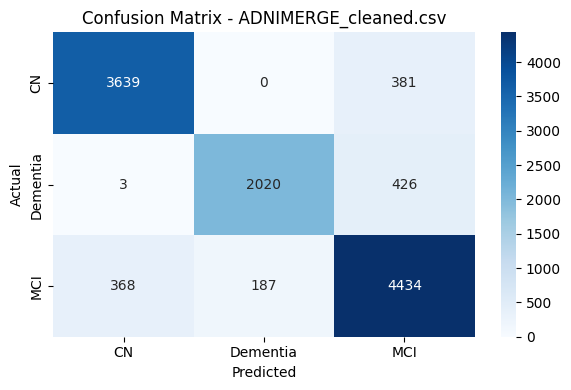

In [72]:
# === Apply final trained model to ADNIMERGE_cleaned.csv with enhancements ===
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import mode
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load dataset
check_df = pd.read_csv("ADNIMERGE_cleaned.csv", low_memory=False)

# === Optionally include cognitive variables for comparison ===
cognitive_vars = ['CDRSB', 'ADAS11', 'ADAS13', 'ADASQ4', 'MMSE']
include_cognitive = True  # Change to False to exclude cognitive predictors
if not include_cognitive:
    check_df.drop(columns=[c for c in cognitive_vars if c in check_df.columns], inplace=True, errors='ignore')

# Convert all object columns with numeric-like values to numeric (e.g., '>1700')
for col in check_df.columns:
    if check_df[col].dtype == object:
        check_df[col] = pd.to_numeric(check_df[col].str.replace(r'>|<', '', regex=True), errors='coerce')

# One-hot encode categorical variables
cat_vars = ['PTGENDER', 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'SITE']
check_df = pd.get_dummies(check_df, columns=[c for c in cat_vars if c in check_df.columns], drop_first=True)

# Load training pipeline and match feature columns
pipeline = joblib.load("models/pipeline_visit_agnostic.pkl")
trained_cols = pipeline.named_steps['imputer'].feature_names_in_

# Add missing columns as 0s and ensure numeric dtype
for col in trained_cols:
    if col not in check_df.columns:
        check_df[col] = 0

check_df = check_df[trained_cols].apply(pd.to_numeric, errors='coerce')
X_check = pipeline.transform(check_df)

# Load models and label encoder
le = joblib.load("models/label_encoder_visit_agnostic.pkl")
rf, gb, nb = joblib.load("models/hybrid_models_visit_agnostic.pkl")

# Predict using hybrid model
pred_rf = rf.predict(X_check)
pred_gb = gb.predict(X_check)
pred_nb = nb.predict(X_check)
hybrid_preds = mode(np.vstack([pred_rf, pred_gb, pred_nb]), axis=0).mode.ravel()
pred_labels = le.inverse_transform(hybrid_preds)

# Save predictions
check_df['Predicted_DX'] = pred_labels
check_df.to_csv("adnimerge_cleaned_with_hybrid_predictions.csv", index=False)

# Evaluate if true DX present
y_raw = pd.read_csv("ADNIMERGE_cleaned.csv", usecols=['DX'])['DX'].astype(str)
valid_idx = y_raw.notna() & y_raw.isin(le.classes_)

if valid_idx.sum() == 0:
    print("⚠️ No valid DX labels found that match training classes. Evaluation skipped.")
else:
    y_true = le.transform(y_raw[valid_idx])
    hybrid_eval = hybrid_preds[valid_idx.values]

    report = classification_report(y_true, hybrid_eval, target_names=le.classes_)
    acc = accuracy_score(y_true, hybrid_eval)
    cm = confusion_matrix(y_true, hybrid_eval)

    print("\n\n🧠 Hybrid Model Generalization on ADNIMERGE_cleaned.csv")
    print(f"Accuracy: {acc:.4f}\n")
    print(report)

    # Confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title("Confusion Matrix - ADNIMERGE_cleaned.csv")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
